In [1]:
# Import non-UniVI modules
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import re

import torch
from torch.utils.data import DataLoader, Subset

import scipy.sparse as sp


In [2]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler, normalize

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

import matplotlib.pyplot as plt


In [3]:
# Import required UniVI modules
from univi import (
    ModalityConfig,
    UniVIConfig,
    TrainingConfig,
    UniVIMultiModalVAE,
    matching,
    UniVITrainer,
    write_univi_latent,
    MultiModalDataset,
)

import univi as uv
import univi.evaluation as ue
import univi.plotting as up

# Double check UniVI module version
print("Installed version is univi v" + str(uv.__version__))


Installed version is univi v0.4.5


In [4]:
print("torch:", torch.__version__)
print("torch.cuda.is_available():", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.mps.is_available() else "cpu")
print("Using device:", device)


torch: 2.10.0
torch.cuda.is_available(): False
Using device: mps


In [5]:
MULTIOME_DATA_ROOT = Path("./data/10x_Genomics_Multiome_data")

MULTIOME_RNA_PATH = MULTIOME_DATA_ROOT / "10x-Multiome-Pbmc10k-RNA.h5ad"
MULTIOME_ATAC_PATH = MULTIOME_DATA_ROOT / "10x-Multiome-Pbmc10k-ATAC.h5ad"

print("Multiome RNA file:", MULTIOME_RNA_PATH)
print("Multiome ATAC file:", MULTIOME_ATAC_PATH)


Multiome RNA file: data/10x_Genomics_Multiome_data/10x-Multiome-Pbmc10k-RNA.h5ad
Multiome ATAC file: data/10x_Genomics_Multiome_data/10x-Multiome-Pbmc10k-ATAC.h5ad


In [6]:
multiome_rna = sc.read_h5ad(MULTIOME_RNA_PATH)
multiome_atac = sc.read_h5ad(MULTIOME_ATAC_PATH)

print(multiome_rna)
print(multiome_atac)

print("Multiome RNA obs names head:", multiome_rna.obs_names[:5].tolist())
print("Multiome ATAC obs names head:", multiome_atac.obs_names[:5].tolist())


AnnData object with n_obs × n_vars = 9631 × 29095
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'tag', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'
AnnData object with n_obs × n_vars = 9631 × 107194
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
    var: 'feature_types', 'genome',

In [7]:
from univi.data import align_paired_obs_names

adata_dict = {'rna': multiome_rna, 'atac': multiome_atac}

align_paired_obs_names(adata_dict)


{'rna': AnnData object with n_obs × n_vars = 9631 × 29095
     obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
     var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'tag', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: 'hvg',
 'atac': AnnData object with n_obs × n_vars = 9631 × 107194
     obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type'
     var: 'fe

In [8]:
multiome_rna = adata_dict['rna'].copy()
multiome_atac = adata_dict['atac'].copy()


In [9]:
rna_raw  = multiome_rna.copy()
atac_raw = multiome_atac.copy()


In [10]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import anndata as ad

# ----------------------------
# helpers
# ----------------------------
def _to_csr(X):
    return X if sp.issparse(X) else sp.csr_matrix(X)

def ensure_counts_in_layer(adata: ad.AnnData, counts_layer="counts") -> ad.AnnData:
    """Make sure raw counts exist in adata.layers[counts_layer]."""
    a = adata.copy()
    if counts_layer not in a.layers:
        a.layers[counts_layer] = a.X.copy()
    # keep counts sparse if possible
    a.layers[counts_layer] = _to_csr(a.layers[counts_layer])
    return a

def set_X_to_layer(adata: ad.AnnData, layer: str) -> ad.AnnData:
    """Set .X to a given layer (e.g. raw counts)."""
    a = adata.copy()
    if layer not in a.layers:
        raise KeyError(f"Layer {layer!r} not found.")
    a.X = a.layers[layer]
    return a

def stratified_split_indices(labels, train_frac=0.80, val_frac=0.10, seed=0, min_per_class=1):
    """
    Stratified train/val/test split.
    test_frac is implied as 1 - train_frac - val_frac.
    """
    assert 0 < train_frac < 1 and 0 <= val_frac < 1
    assert train_frac + val_frac < 1
    rng = np.random.default_rng(seed)

    y = pd.Series(labels).astype("category")
    idx_all = np.arange(y.shape[0])

    train_idx, val_idx, test_idx = [], [], []
    for ct in y.cat.categories:
        idx_ct = idx_all[(y.values == ct)]
        if idx_ct.size < min_per_class:
            # dump tiny classes into train (or handle however you prefer)
            train_idx.extend(idx_ct.tolist())
            continue

        rng.shuffle(idx_ct)
        n = idx_ct.size
        n_tr = int(np.floor(train_frac * n))
        n_va = int(np.floor(val_frac * n))

        train_idx.extend(idx_ct[:n_tr].tolist())
        val_idx.extend(idx_ct[n_tr:n_tr+n_va].tolist())
        test_idx.extend(idx_ct[n_tr+n_va:].tolist())

    train_idx = np.asarray(train_idx, dtype=int)
    val_idx   = np.asarray(val_idx, dtype=int)
    test_idx  = np.asarray(test_idx, dtype=int)

    rng.shuffle(train_idx); rng.shuffle(val_idx); rng.shuffle(test_idx)
    return train_idx, val_idx, test_idx

# ----------------------------
# raw-count "preprocess"
# ----------------------------
def preprocess_splits_raw_counts(
    rna: ad.AnnData,
    atac: ad.AnnData,
    train_idx: np.ndarray,
    val_idx: np.ndarray,
    test_idx: np.ndarray,
    *,
    counts_layer: str = "counts",
    set_X: bool = True,
):
    """
    Returns train/val/test AnnData for RNA and ATAC using raw counts only.
    If set_X=True, each returned AnnData will have .X == raw counts.
    """
    rna = ensure_counts_in_layer(rna, counts_layer=counts_layer)
    atac = ensure_counts_in_layer(atac, counts_layer=counts_layer)

    rna_tr, rna_va, rna_te = rna[train_idx].copy(), rna[val_idx].copy(), rna[test_idx].copy()
    atac_tr, atac_va, atac_te = atac[train_idx].copy(), atac[val_idx].copy(), atac[test_idx].copy()

    if set_X:
        rna_tr  = set_X_to_layer(rna_tr,  counts_layer)
        rna_va  = set_X_to_layer(rna_va,  counts_layer)
        rna_te  = set_X_to_layer(rna_te,  counts_layer)
        atac_tr = set_X_to_layer(atac_tr, counts_layer)
        atac_va = set_X_to_layer(atac_va, counts_layer)
        atac_te = set_X_to_layer(atac_te, counts_layer)

    return rna_tr, atac_tr, rna_va, atac_va, rna_te, atac_te


In [ ]:
import numpy as np
import scipy.sparse as sp

def binarize_layer(adata, layer="counts", out_layer="bin"):
    a = adata.copy()
    X = a.layers[layer] if layer in a.layers else a.X
    if sp.issparse(X):
        Xb = X.copy()
        Xb.data = np.ones_like(Xb.data, dtype=np.float32)
    else:
        Xb = (X > 0).astype(np.float32)
    a.layers[out_layer] = Xb
    a.X = a.layers[out_layer]  # if your dataset reads from .X
    return a

atac_bin = binarize_layer(atac_raw, layer="counts", out_layer="bin")


In [ ]:
atac_raw_orig = atac_raw.copy()
atac_raw = atac_bin.copy()


In [11]:
CELLTYPE_KEY = "cell_type"
SEED = 0
COUNTS_LAYER = "counts"

assert CELLTYPE_KEY in rna_raw.obs.columns
assert CELLTYPE_KEY in atac_raw.obs.columns

# important: labels should correspond to the same ordering as rna_raw
y = rna_raw.obs[CELLTYPE_KEY].to_numpy()

train_idx, val_idx, test_idx = stratified_split_indices(
    y, train_frac=0.80, val_frac=0.10, seed=SEED, min_per_class=1
)

rna_tr, atac_tr, rna_va, atac_va, rna_te, atac_te = preprocess_splits_raw_counts(
    rna_raw, atac_raw,
    train_idx, val_idx, test_idx,
    counts_layer=COUNTS_LAYER,
    set_X=True,   # .X will be counts
)

print("train/val/test:", rna_tr.n_obs, rna_va.n_obs, rna_te.n_obs)


train/val/test: 7698 956 977


In [12]:
adata_dict = {
    "rna":  rna_tr.concatenate(rna_va, rna_te, batch_key=None),
    "atac": atac_tr.concatenate(atac_va, atac_te, batch_key=None),
}

adata_dict = align_paired_obs_names(adata_dict)
dataset = MultiModalDataset(adata_dict=adata_dict, X_key="X", device=None)

n_tr, n_va, n_te = rna_tr.n_obs, rna_va.n_obs, rna_te.n_obs
TRAIN_IDX = np.arange(0, n_tr)
VAL_IDX   = np.arange(n_tr, n_tr + n_va)
TEST_IDX  = np.arange(n_tr + n_va, n_tr + n_va + n_te)


/var/folders/fl/dl2g54g52svg861xm9w8vp6xtdpc9w/T/ipykernel_76984/3868671342.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  "rna":  rna_tr.concatenate(rna_va, rna_te, batch_key=None),
/var/folders/fl/dl2g54g52svg861xm9w8vp6xtdpc9w/T/ipykernel_76984/3868671342.py:3: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  "atac": atac_tr.concatenate(atac_va, atac_te, batch_key=None),


In [14]:
#pin_memory = (device == "mps")
pin_memory = False

batch_size = 256
num_workers = 0


train_dict = {"rna": rna_tr, "atac": atac_tr}
val_dict   = {"rna": rna_va, "atac": atac_va}
test_dict  = {"rna": rna_te, "atac": atac_te}


# Build datasets (CPU tensors; trainer/model moves to GPU)
train_ds = MultiModalDataset(adata_dict=train_dict, X_key="X", device=None)
val_ds   = MultiModalDataset(adata_dict=val_dict,   X_key="X", device=None)
test_ds  = MultiModalDataset(adata_dict=test_dict,  X_key="X", device=None)


train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
    drop_last=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    drop_last=False,
)

test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
    drop_last=False,
)

print("n_train / n_val / n_test:", train_ds.n_cells, val_ds.n_cells, test_ds.n_cells)
print("batches:", len(train_loader), len(val_loader), len(test_loader))

# sanity check one batch
x = next(iter(train_loader))
print({k: v.shape for k, v in x.items()})


n_train / n_val / n_test: 7698 956 977
batches: 30 4 4
{'rna': torch.Size([256, 29095]), 'atac': torch.Size([256, 107194])}


In [15]:
'''
FOSCTTM mean:          0.07973345957826079
FOSCTTM sem:           0.005462308340337411
Recall@1:              0.07574206755373593
Recall@5:              0.23439099283520984
Recall@10:             0.3510747185261003
Recall@25:             0.5394063459570113
Recall@50:             0.7072671443193449
Recall@100:            0.8413510747185261
Modality mixing mean:  0.4307830110421078
Modality entropy mean: 0.9305325635349494
Label transfer ACC:    0.8300921187308086
'''
'''
univi_cfg = UniVIConfig(
    latent_dim=60,
    beta=1.15,
    gamma=3.25,
    encoder_dropout=0.10,
    decoder_dropout=0.05,
    encoder_batchnorm=True,
    decoder_batchnorm=False,
    kl_anneal_start=75,
    kl_anneal_end=150,
    align_anneal_start=100,
    align_anneal_end=175,

    # ---- MoE gating (NEW) ----
    #use_moe_gating=True,
    #moe_gating_type="per_modality",   # or "shared"
    #moe_gating_hidden=[64],           # tiny MLP; you can do [32] too
    #moe_gating_dropout=0.0,
    #moe_gating_batchnorm=False,
    #moe_gating_activation="relu",
    #moe_gate_eps=1e-6,

    modalities=[
        ModalityConfig(
            name="rna",
            input_dim=rna_tr.n_vars,
            #encoder_hidden=[512, 256, 128],
            #decoder_hidden=[128, 256, 512],
            encoder_hidden=[2048, 1024, 512, 256, 128],
            decoder_hidden=[128, 256, 512, 1024, 2048],
            #likelihood="gaussian",
            likelihood="nb",
        ),
        ModalityConfig(
            name="atac",
            input_dim=atac_tr.n_vars,
            #encoder_hidden=[128, 64],
            #decoder_hidden=[64, 128],
            encoder_hidden=[2048, 1024, 512, 256, 128],
            decoder_hidden=[128, 256, 512, 1024, 2048],
            #likelihood="gaussian",
            likelihood="bernoulli",
        ),
    ],
)
'''


'\nunivi_cfg = UniVIConfig(\n    latent_dim=60,\n    beta=1.15,\n    gamma=3.25,\n    encoder_dropout=0.10,\n    decoder_dropout=0.05,\n    encoder_batchnorm=True,\n    decoder_batchnorm=False,\n    kl_anneal_start=75,\n    kl_anneal_end=150,\n    align_anneal_start=100,\n    align_anneal_end=175,\n\n    # ---- MoE gating (NEW) ----\n    #use_moe_gating=True,\n    #moe_gating_type="per_modality",   # or "shared"\n    #moe_gating_hidden=[64],           # tiny MLP; you can do [32] too\n    #moe_gating_dropout=0.0,\n    #moe_gating_batchnorm=False,\n    #moe_gating_activation="relu",\n    #moe_gate_eps=1e-6,\n\n    modalities=[\n        ModalityConfig(\n            name="rna",\n            input_dim=rna_tr.n_vars,\n            #encoder_hidden=[512, 256, 128],\n            #decoder_hidden=[128, 256, 512],\n            encoder_hidden=[2048, 1024, 512, 256, 128],\n            decoder_hidden=[128, 256, 512, 1024, 2048],\n            #likelihood="gaussian",\n            likelihood="nb",\n     

In [16]:
univi_cfg = UniVIConfig(
    latent_dim=100,
    beta=1.25,
    gamma=4.35,
    encoder_dropout=0.075,
    decoder_dropout=0.035,
    encoder_batchnorm=True,
    decoder_batchnorm=False,
    kl_anneal_start=50,
    kl_anneal_end=100,
    align_anneal_start=75,
    align_anneal_end=125,

    # ---- MoE gating (NEW) ----
    #use_moe_gating=True,
    #moe_gating_type="per_modality",   # or "shared"
    #moe_gating_hidden=[64],           # tiny MLP; you can do [32] too
    #moe_gating_dropout=0.0,
    #moe_gating_batchnorm=False,
    #moe_gating_activation="relu",
    #moe_gate_eps=1e-6,

    modalities=[
        ModalityConfig(
            name="rna",
            input_dim=rna_tr.n_vars,
            #encoder_hidden=[512, 256, 128],
            #decoder_hidden=[128, 256, 512],
            encoder_hidden=[5048, 2048, 1024, 512, 256],
            decoder_hidden=[256, 512, 1024, 2048, 5048],
            #likelihood="gaussian",
            likelihood="nb",
        ),
        ModalityConfig(
            name="atac",
            input_dim=atac_tr.n_vars,
            #encoder_hidden=[128, 64],
            #decoder_hidden=[64, 128],
            encoder_hidden=[5048, 2048, 1024, 512, 256],
            decoder_hidden=[256, 512, 1024, 2048, 5048],
            #likelihood="gaussian",
            #likelihood="bernoulli",
            likelihood="poisson",
        ),
    ],
)


In [17]:
model = UniVIMultiModalVAE(
    univi_cfg,
    loss_mode="v1",
    #loss_mode="lite"
    #v1_recon="cross",
    v1_recon="avg",
    #v1_recon_mix=0.5,
    normalize_v1_terms=True,
).to(device)


In [18]:
print("use_moe_gating:", model.use_moe_gating)
print("moe_gating_type:", model.moe_gating_type)
print("shared_gate_net:", model.shared_gate_net is not None)
print("gate_nets:", list(model.gate_nets.keys())[:5], "… n=", len(model.gate_nets))


use_moe_gating: False
moe_gating_type: per_modality
shared_gate_net: False
gate_nets: [] … n= 0


In [19]:
train_cfg = TrainingConfig(
    n_epochs=5000,
    batch_size=batch_size,
    lr=1e-3,
    weight_decay=1e-4,
    device=device,
    log_every=25,
    grad_clip=5.0,
    num_workers=0,
    seed=42,
    early_stopping=True,
    best_epoch_warmup=75,
    patience=30,
    min_delta=0.0,
)


In [20]:
trainer = UniVITrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    train_cfg=train_cfg,
    device=device,
)


[2026-02-20 19:38:56,386] [UniVITrainer] [INFO] TrainingConfig:
[2026-02-20 19:38:56,387] [UniVITrainer] [INFO]   n_epochs: 5000
[2026-02-20 19:38:56,388] [UniVITrainer] [INFO]   batch_size: 256
[2026-02-20 19:38:56,388] [UniVITrainer] [INFO]   lr: 0.001
[2026-02-20 19:38:56,388] [UniVITrainer] [INFO]   weight_decay: 0.0001
[2026-02-20 19:38:56,389] [UniVITrainer] [INFO]   device: 'mps'
[2026-02-20 19:38:56,389] [UniVITrainer] [INFO]   log_every: 25
[2026-02-20 19:38:56,389] [UniVITrainer] [INFO]   grad_clip: 5.0
[2026-02-20 19:38:56,389] [UniVITrainer] [INFO]   num_workers: 0
[2026-02-20 19:38:56,389] [UniVITrainer] [INFO]   seed: 42
[2026-02-20 19:38:56,390] [UniVITrainer] [INFO]   early_stopping: True
[2026-02-20 19:38:56,390] [UniVITrainer] [INFO]   patience: 30
[2026-02-20 19:38:56,390] [UniVITrainer] [INFO]   min_delta: 0.0
[2026-02-20 19:38:56,390] [UniVITrainer] [INFO]   best_epoch_warmup: 75


In [21]:
history = trainer.fit()

# history is a dict with keys like "train_loss", "val_loss", "beta", "gamma"
print("Training finished.")
print("Best val loss:", np.min(history["val_loss"]))


Training UniVI:   0%|          | 0/5000 [00:00<?, ?it/s]

[2026-02-20 19:40:35,931] [UniVITrainer] [INFO] [Epoch 001] Train loss=5202222.7670 (beta=0.000, gamma=0.000)
[2026-02-20 19:40:39,680] [UniVITrainer] [INFO] [Epoch 001] Val loss=18853.5430 (beta=1.250, gamma=4.350)
[2026-02-20 20:12:26,816] [UniVITrainer] [INFO] [Epoch 025] Train loss=15266.1574 (beta=0.000, gamma=0.000)
[2026-02-20 20:12:30,267] [UniVITrainer] [INFO] [Epoch 025] Val loss=107378.9199 (beta=1.250, gamma=4.350)
[2026-02-20 20:44:55,606] [UniVITrainer] [INFO] [Epoch 050] Train loss=15053.9578 (beta=0.000, gamma=0.000)
[2026-02-20 20:44:59,050] [UniVITrainer] [INFO] [Epoch 050] Val loss=298878.8555 (beta=1.250, gamma=4.350)
[2026-02-20 21:16:28,808] [UniVITrainer] [INFO] [Epoch 074] Best tracking warmup ends next epoch (best_epoch_warmup=75).
[2026-02-20 21:17:47,174] [UniVITrainer] [INFO] [Epoch 075] Train loss=14928.9890 (beta=0.625, gamma=0.000)
[2026-02-20 21:17:50,634] [UniVITrainer] [INFO] [Epoch 075] Val loss=16809.1738 (beta=1.250, gamma=4.350)
[2026-02-20 21:17:5

Training finished.
Best val loss: 15951.635009765625


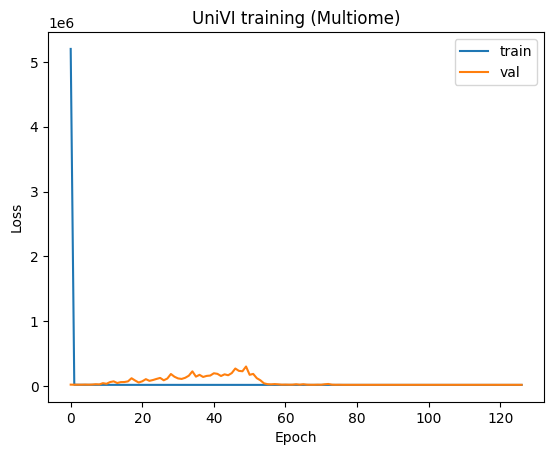

In [22]:
plt.figure()
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("UniVI training (Multiome)")
plt.show()


In [23]:
import torch
'''
ckpt = {
    "model_state_dict": model.state_dict(),
    "model_config": univi_cfg,          # if picklable
    "train_cfg": train_cfg,             # optional, if picklable
    "history": getattr(trainer, "history", None),
    # optional fields if trainer exposes them:
    "best_epoch": getattr(trainer, "best_epoch", None),
    "best_metric": getattr(trainer, "best_metric", None),
}
torch.save(ckpt, "./saved_models_2-20-2026/Multiome_raw_all_features_nb-poisson/univi_model_state.pt")
'''

In [24]:
'''
#ckpt = torch.load("./saved_models_2-20-2026/Multiome_raw_all_features_nb-burnoulli/univi_model_state.pt", map_location=device)
ckpt = torch.load("./saved_models_2-20-2026/Multiome_raw_all_features_nb-poisson/univi_model_state.pt", map_location=device)

model = UniVI(ckpt["model_config"]).to(device)  # or UniVI(univi_cfg) if you prefer
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

print("Best epoch:", ckpt.get("best_epoch"))
'''

'\n#ckpt = torch.load("./saved_models_2-20-2026/Multiome_raw_all_features_nb-burnoulli/univi_model_state.pt", map_location=device)\nckpt = torch.load("./saved_models_2-20-2026/Multiome_raw_all_features_nb-poisson/univi_model_state.pt", map_location=device)\n\nmodel = UniVI(ckpt["model_config"]).to(device)  # or UniVI(univi_cfg) if you prefer\nmodel.load_state_dict(ckpt["model_state_dict"])\nmodel.eval()\n\nprint("Best epoch:", ckpt.get("best_epoch"))\n'

In [25]:
import numpy as np
import scipy.sparse as sp

from univi.evaluation import (
    encode_adata,
    encode_fused_adata_pair,
    cross_modal_predict,
    denoise_adata,
    denoise_from_multimodal,
    evaluate_alignment,
    reconstruction_metrics,
    # NEW (generation + recon error workflows)
    generate_from_latent,
    fit_label_latent_gaussians,
    sample_latent_by_label,
    evaluate_cross_reconstruction,
)
from univi.plotting import (
    set_style,
    umap,
    umap_by_modality,
    compare_raw_vs_denoised_umap_features,
    plot_confusion_matrix,
    write_gates_to_obs,
    plot_moe_gate_summary,
    # NEW (reconstruction error plots)
    plot_reconstruction_error_summary,
    plot_featurewise_reconstruction_scatter,
)

set_style(font_scale=1.2, dpi=150)
device = "mps"  # or "mps" (Mac), or "cpu"


In [26]:
def to_dense(X):
    return X.toarray() if sp.issparse(X) else np.asarray(X)


In [27]:
rna = rna_te
atac = atac_te


In [28]:
Z_rna = encode_adata(
    model,
    adata=rna,
    modality="rna",
    device=device,
    layer=None,          # uses adata.X by default
    X_key="X",
    batch_size=1024,
    latent="moe_mean",   # {"moe_mean","moe_sample","modality_mean","modality_sample"}
    random_state=0,
)
rna.obsm["X_univi"] = Z_rna


In [29]:
Z_atac = encode_adata(
    model,
    adata=atac,
    modality="atac",
    device=device,
    layer=None,          # uses adata.X by default
    X_key="X",
    batch_size=1024,
    latent="moe_mean",   # {"moe_mean","moe_sample","modality_mean","modality_sample"}
    random_state=0,
)
atac.obsm["X_univi"] = Z_atac


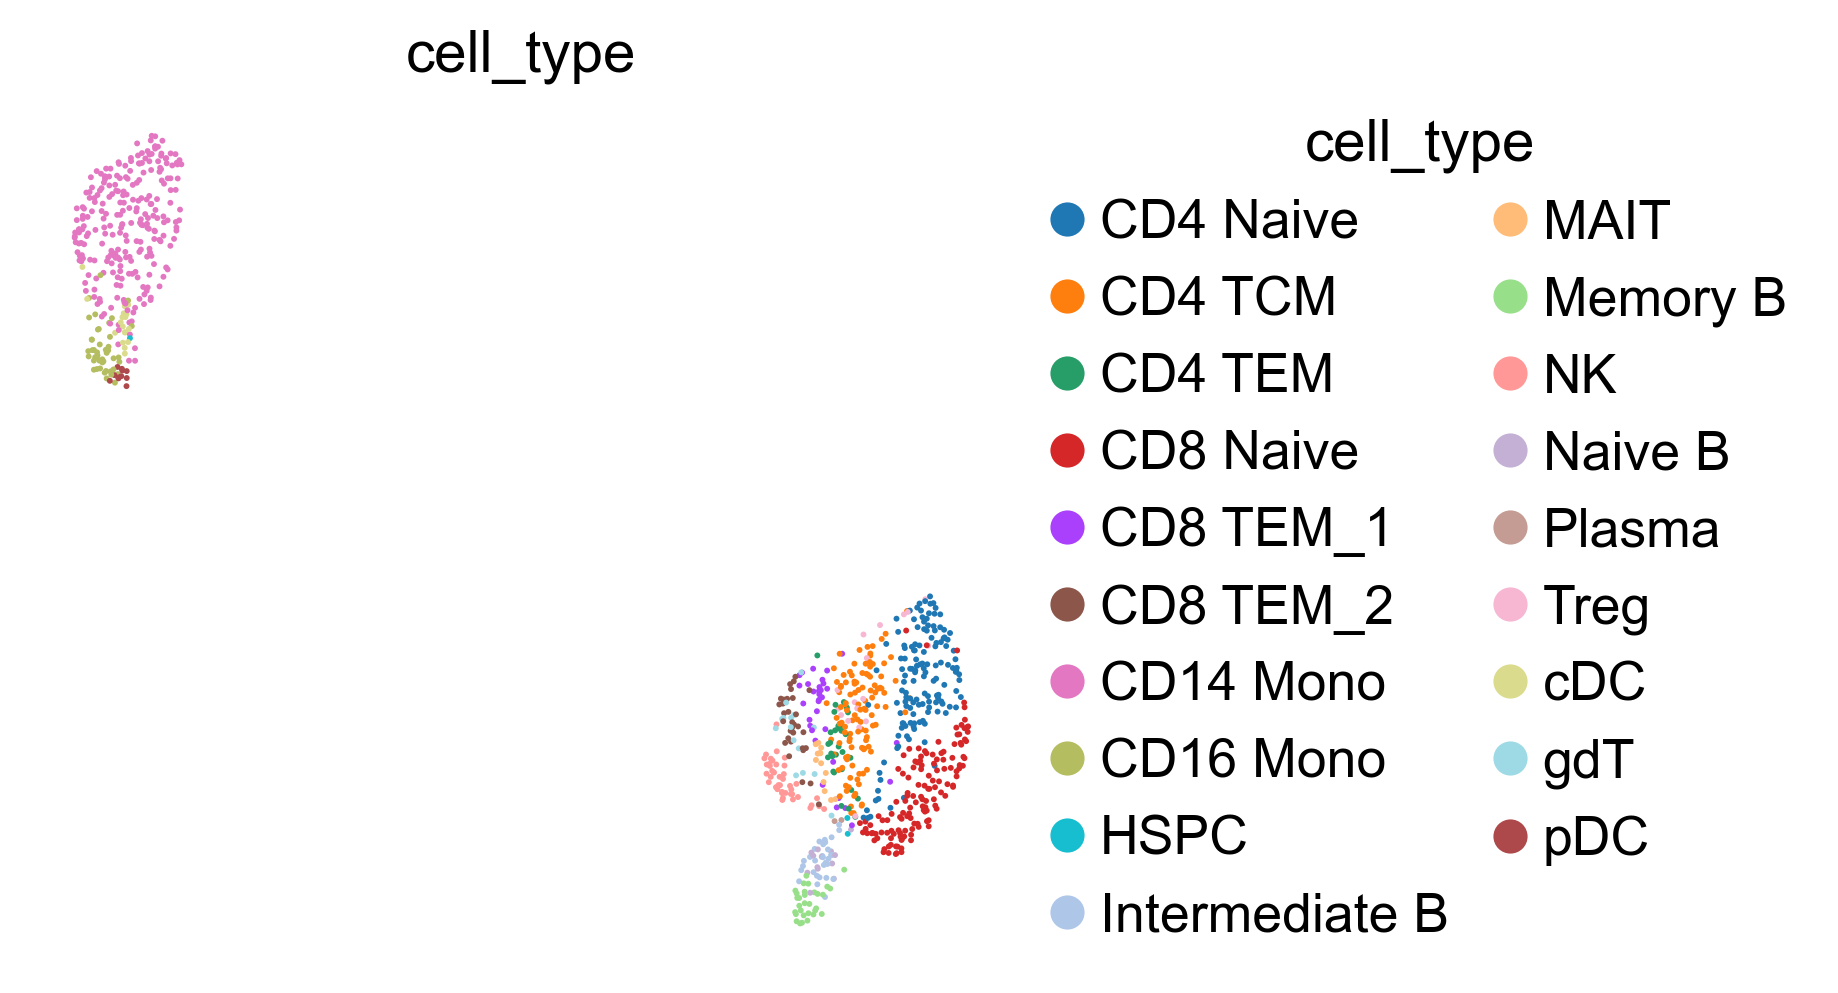

In [30]:
umap(
    rna,
    obsm_key="X_univi",
    color=["cell_type"],
    legend="outside",
    legend_subset_topk=25,
    #savepath="umap_rna_univi.png",
    savepath=None,
    size=8,
    show=True,
)


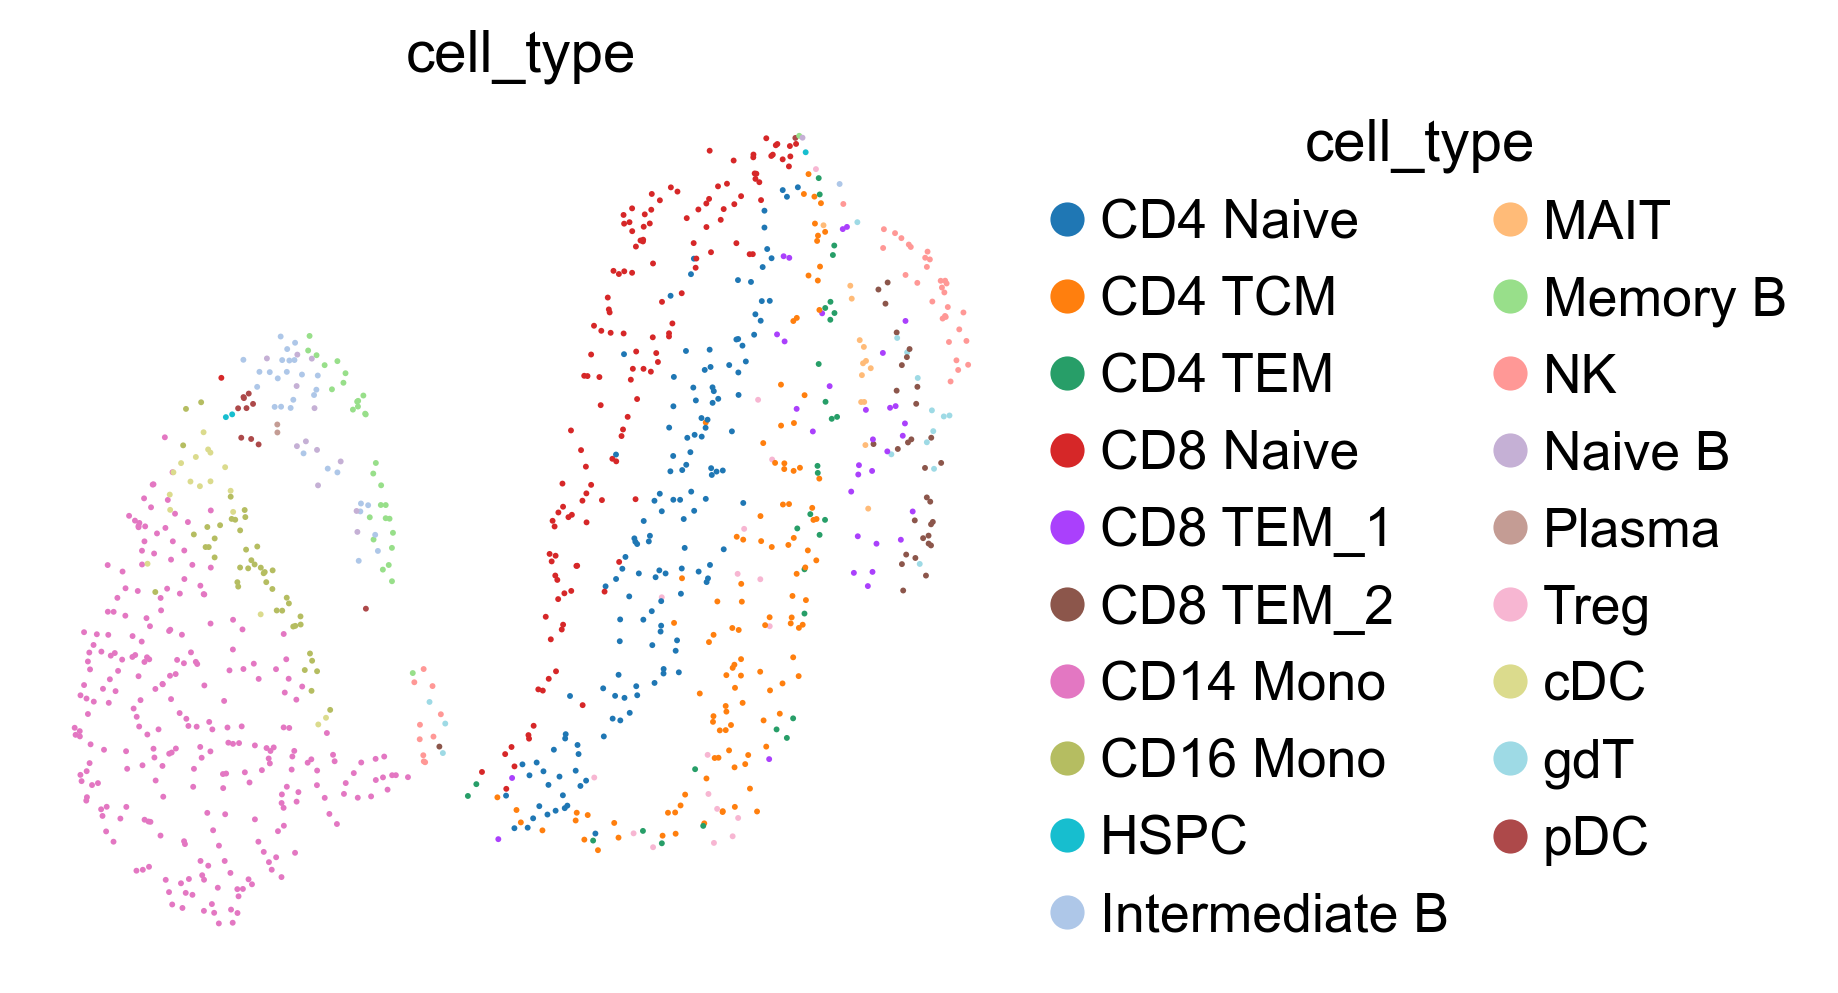

In [31]:
umap(
    atac,
    obsm_key="X_univi",
    color=["cell_type"],
    legend="outside",
    legend_subset_topk=25,
    #savepath="umap_rna_univi.png",
    savepath=None,
    size=8,
    show=True,
)


In [32]:
fused = encode_fused_adata_pair(
    model,
    adata_by_mod={"rna": rna, "atac": atac},   # same obs_names, same order
    device=device,
    batch_size=1024,
    use_mean=True,
    return_gates=True,
    return_gate_logits=True,
    write_to_adatas=True,                   # writes obsm + gate columns
    fused_obsm_key="X_univi_fused",
    gate_prefix="gate",
)

# fused["Z_fused"] -> (n_cells, latent_dim)
# fused["gates"]  -> (n_cells, n_modalities) or None (if fused transformer posterior is used)


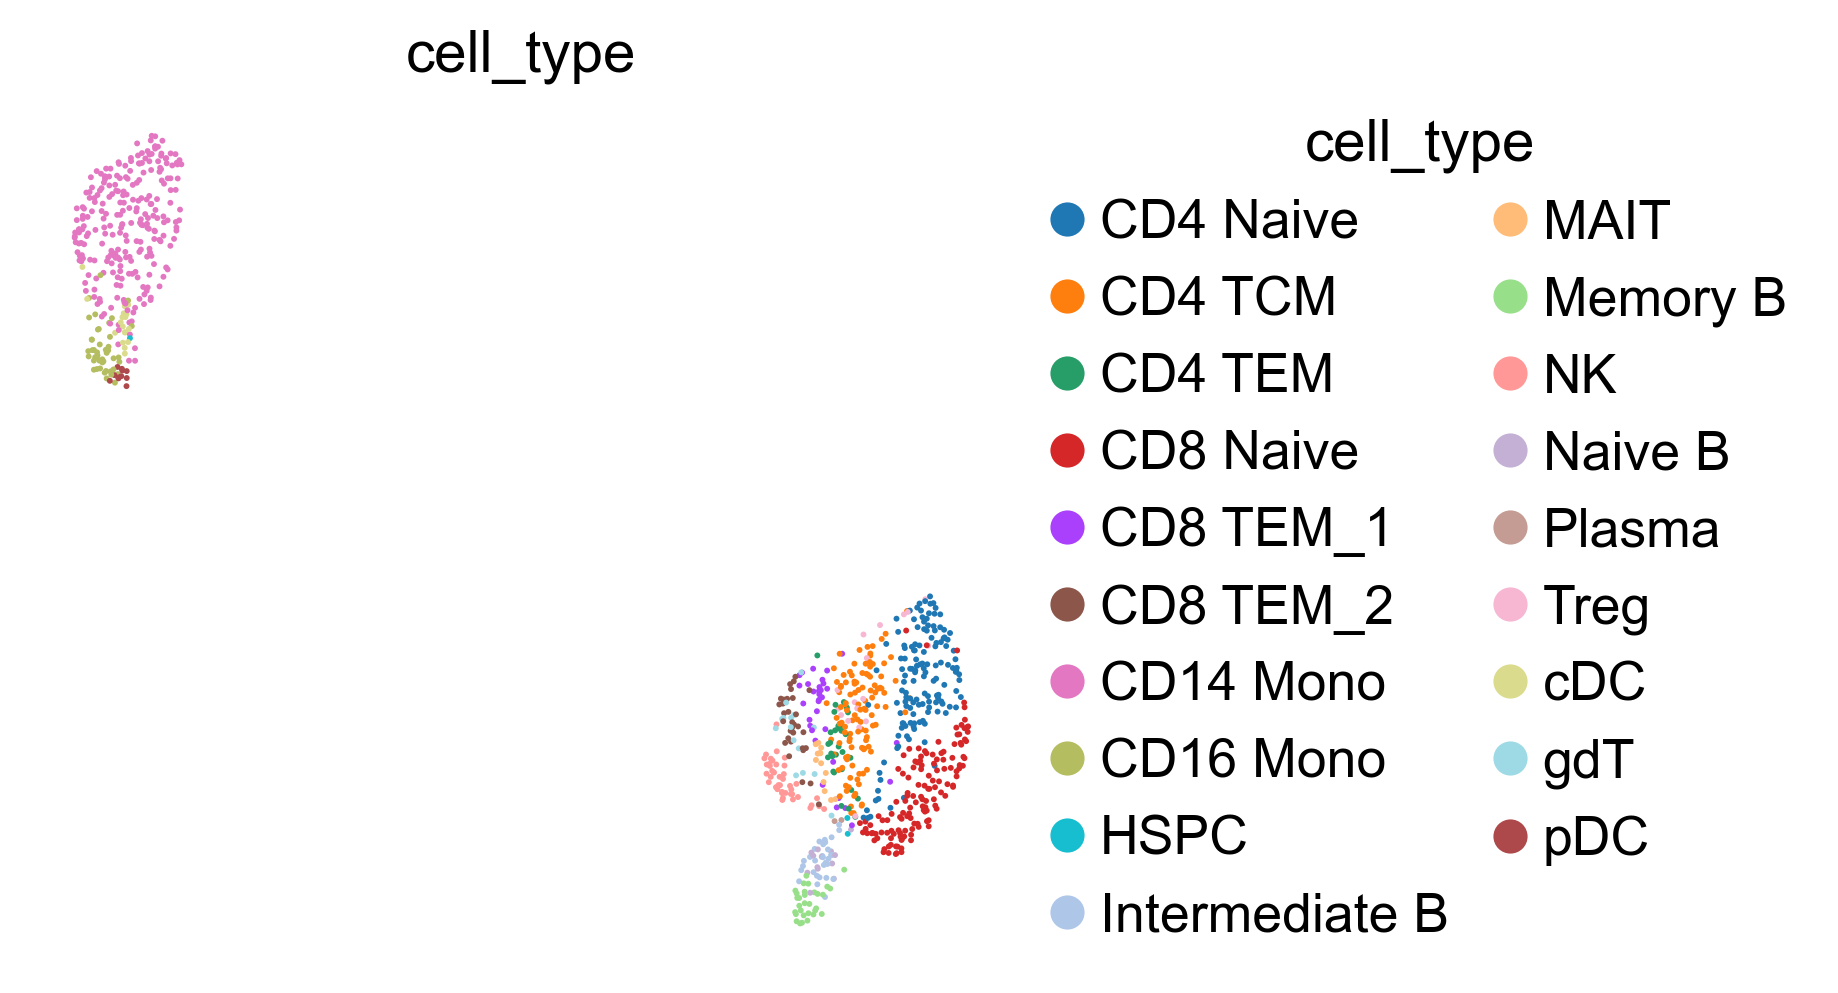

In [33]:
umap(
    rna,
    obsm_key="X_univi_fused",
    color=["cell_type"],
    legend="outside",
    #savepath="umap_fused.png",
    savepath=None,
    size=8,
    show=True,
)


/opt/homebrew/Cellar/micromamba/2.5.0_1/envs/univi_v0.3.9/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


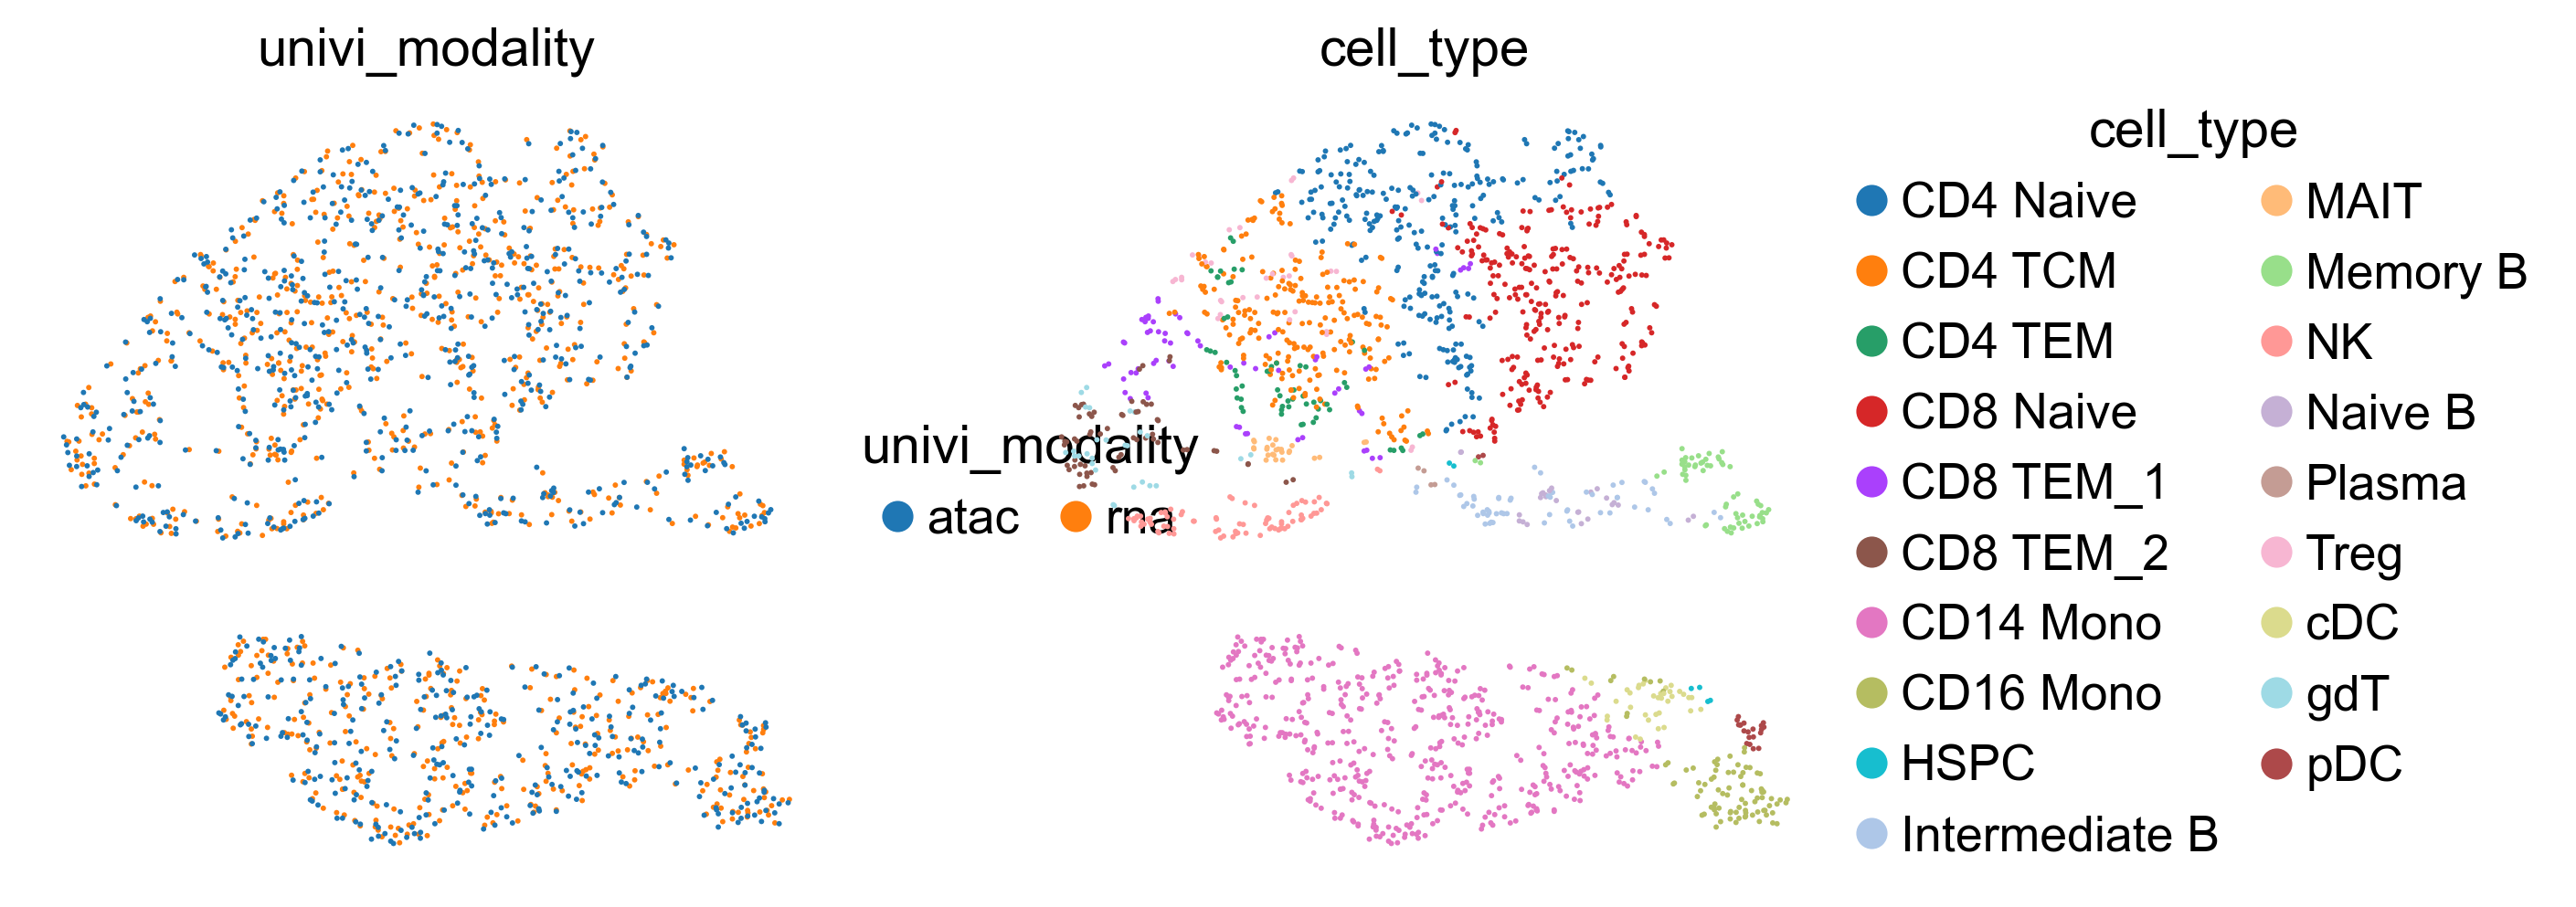

In [34]:
from univi.plotting import umap_by_modality

# make sure both adatas have the fused embedding (encode_fused_adata_pair with write_to_adatas=True does this)
# rna.obsm["X_univi_fused"]
# adt.obsm["X_univi_fused"]

umap_by_modality(
    {"rna": rna, "atac": atac},
    obsm_key="X_univi_fused",
    color=["univi_modality", "cell_type"],
    legend="outside",
    size=8,
    show=True,
    savepath=None,
)


In [35]:
atac_hat_from_rna = cross_modal_predict(
    model,
    adata_src=rna,
    src_mod="rna",
    tgt_mod="atac",
    device=device,
    layer=None,
    X_key="X",
    batch_size=512,
    use_moe=True,
)
atac.layers["imputed_from_rna"] = atac_hat_from_rna


In [36]:
rna_hat_from_atac = cross_modal_predict(
    model,
    adata_src=atac,
    src_mod="atac",
    tgt_mod="rna",
    device=device,
    layer=None,
    X_key="X",
    batch_size=512,
    use_moe=True,
)
rna.layers["imputed_from_atac"] = rna_hat_from_atac


In [37]:
denoise_adata(
    model,
    adata=rna,                         # output written here
    modality="rna",
    device=device,
    out_layer="denoised_fused",
    overwrite_X=False,
    batch_size=512,
    adata_by_mod={"rna": rna, "atac": atac},
    layer_by_mod={"rna": None, "atac": None},  # None -> use .X
    X_key_by_mod={"rna": "X", "atac": "X"},
    use_mean=True,
)


AnnData object with n_obs × n_vars = 977 × 29095
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'gate_rna', 'gate_atac', 'gate_logit_rna', 'gate_logit_atac'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'tag', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'X_univi', 'X_umap', 'X_univi_fused'
    layers: 'counts', 'imputed_from_atac', 'denoised_fused'
    obsp: 'distances', 'connectivities'

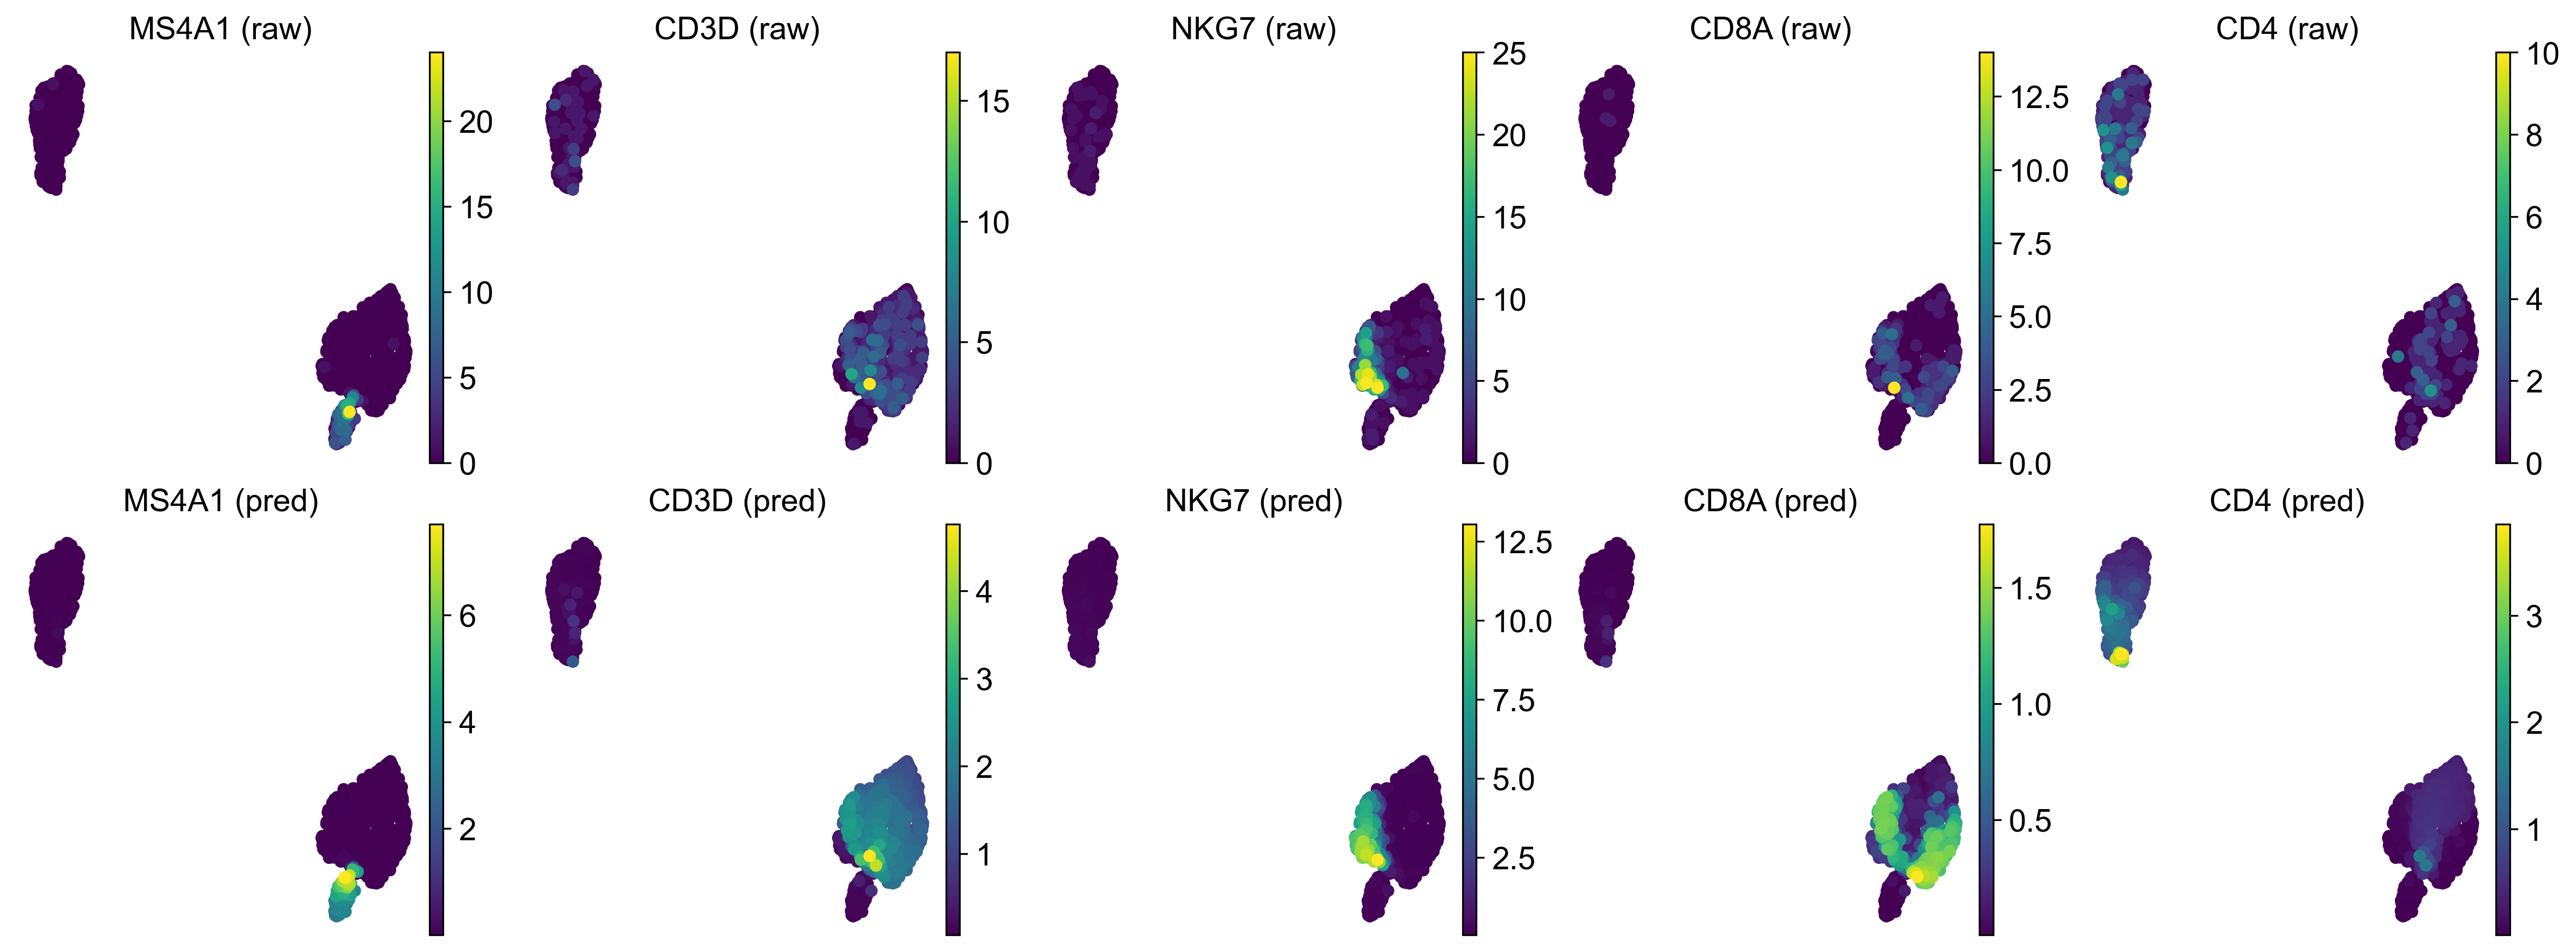

In [38]:
compare_raw_vs_denoised_umap_features(
    rna,
    #obsm_key="X_univi",
    obsm_key="X_univi_fused",
    features=["MS4A1", "CD3D", "NKG7", "CD8A", "CD4"],
    raw_layer=None,
    denoised_layer="denoised_fused",
    #savepath="umap_raw_vs_denoised.png",
    show=True,
)


In [39]:
denoise_adata(
    model,
    adata=atac,                         # output written here
    modality="atac",
    device=device,
    out_layer="denoised_fused",
    overwrite_X=False,
    batch_size=512,
    adata_by_mod={"rna": rna, "atac": atac},
    layer_by_mod={"rna": None, "atac": None},  # None -> use .X
    X_key_by_mod={"rna": "X", "atac": "X"},
    use_mean=True,
)


AnnData object with n_obs × n_vars = 977 × 107194
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'gate_rna', 'gate_atac', 'gate_logit_rna', 'gate_logit_atac'
    var: 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'n_counts'
    uns: 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'X_univi', 'X_umap', 'X_univi_fused'
    layers: 'counts', 'imputed_from_rna', 'denoised_fused'
    obsp: 'distances', 'connectivities'

In [40]:
print(atac.var_names[40000:40100])

Index(['chr17:2302259-2305369', 'chr17:2335725-2338805',
       'chr17:2343436-2343817', 'chr17:2352937-2354269',
       'chr17:2370517-2370533', 'chr17:2372337-2372516',
       'chr17:2379540-2381472', 'chr17:2382137-2383941',
       'chr17:2384458-2389064', 'chr17:2390064-2405677',
       'chr17:2407282-2407683', 'chr17:2415783-2417228',
       'chr17:2438567-2440518', 'chr17:2478470-2478854',
       'chr17:2482009-2482843', 'chr17:2486128-2486219',
       'chr17:2487323-2487355', 'chr17:2489344-2489708',
       'chr17:2510822-2513072', 'chr17:2530996-2531881',
       'chr17:2542502-2542829', 'chr17:2571928-2572459',
       'chr17:2592511-2597659', 'chr17:2601324-2601383',
       'chr17:2602786-2603408', 'chr17:2606250-2607050',
       'chr17:2613313-2613921', 'chr17:2622714-2624957',
       'chr17:2628912-2629429', 'chr17:2647921-2648387',
       'chr17:2655417-2656101', 'chr17:2659245-2659821',
       'chr17:2675039-2675893', 'chr17:2685717-2687269',
       'chr17:2687812-2687820',

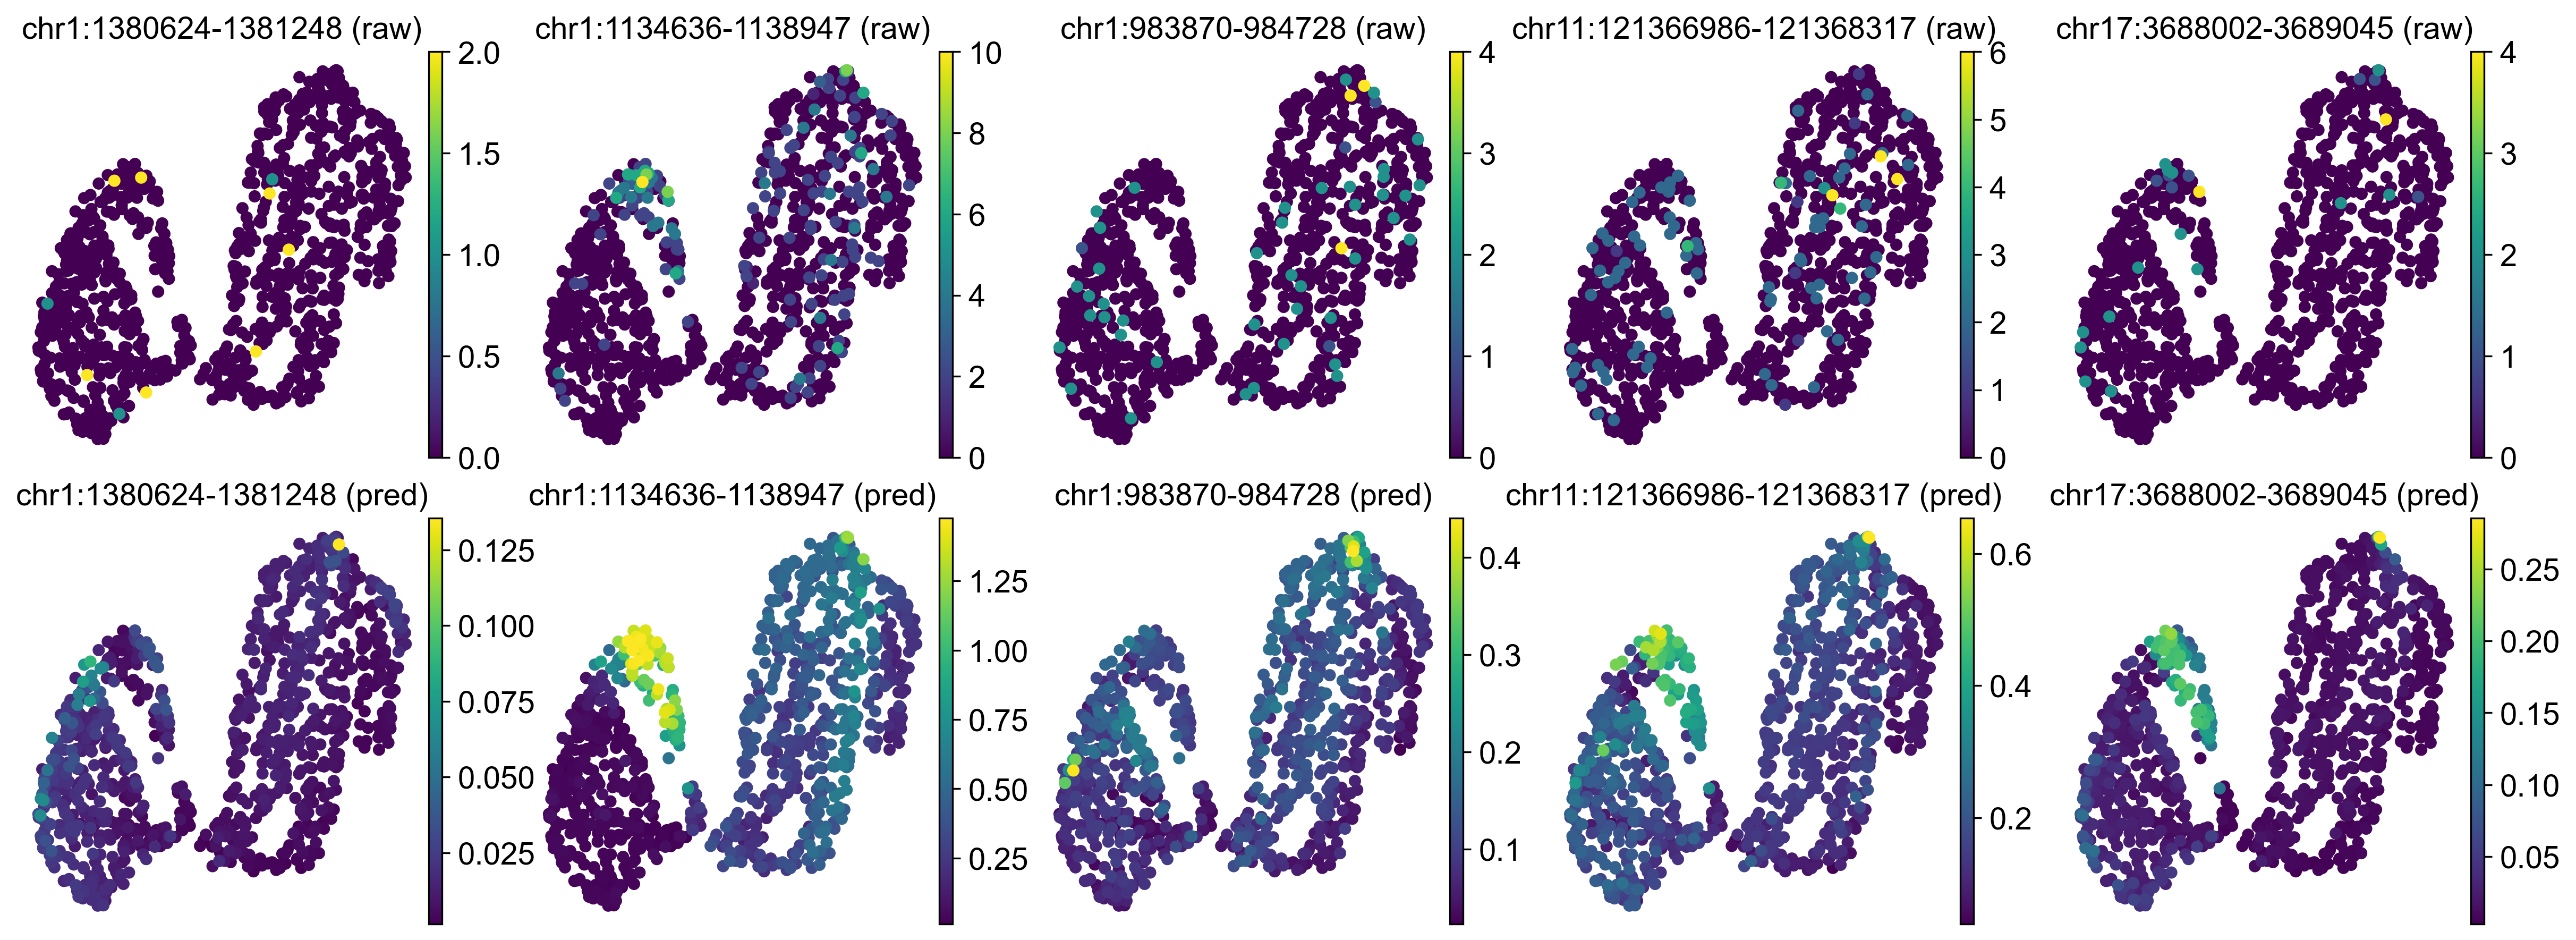

In [41]:
compare_raw_vs_denoised_umap_features(
    atac,
    obsm_key="X_univi",
    features=['chr1:1380624-1381248', 'chr1:1134636-1138947', 'chr1:983870-984728', 'chr11:121366986-121368317', 'chr17:3688002-3689045'],
    raw_layer=None,
    denoised_layer="denoised_fused",
    #savepath="umap_raw_vs_denoised.png",
    savepath=None,
    show=True,
)


In [42]:
from univi.evaluation import to_dense, encode_moe_gates_from_tensors
from univi.plotting import write_gates_to_obs, plot_moe_gate_summary

gate = encode_moe_gates_from_tensors(
    model,
    x_dict={"rna": to_dense(rna.X), "atac": to_dense(atac.X)},
    device=device,
    batch_size=1024,
    modality_order=["rna", "atac"],
    kind="router_x_precision",  # will fall back to "effective_precision" if router logits are unavailable
    return_logits=True,
)

W    = gate["weights"]         # (n_cells, n_modalities), rows sum to 1
mods = gate["modality_order"]  # e.g. ["rna", "adt"]

print("Requested kind:", gate.get("requested_kind"))
print("Effective kind:", gate.get("kind"))
print("Per-modality mean:", gate.get("per_modality_mean"))
print("Has logits:", gate.get("logits") is not None)


Requested kind: router_x_precision
Effective kind: router_x_precision
Per-modality mean: {'rna': 0.516030490398407, 'atac': 0.4839695692062378}
Has logits: True


In [43]:
write_gates_to_obs(
    rna,
    gates=W,
    modality_names=mods,
    gate_prefix="moe_gate",          # creates obs cols: moe_gate_{mod}
    gate_logits=gate.get("logits"),  # optional; may be None
)


/opt/homebrew/Cellar/micromamba/2.5.0_1/envs/univi_v0.3.9/lib/python3.10/site-packages/univi/plotting.py:580: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = df.groupby(groupby)[cols].mean()


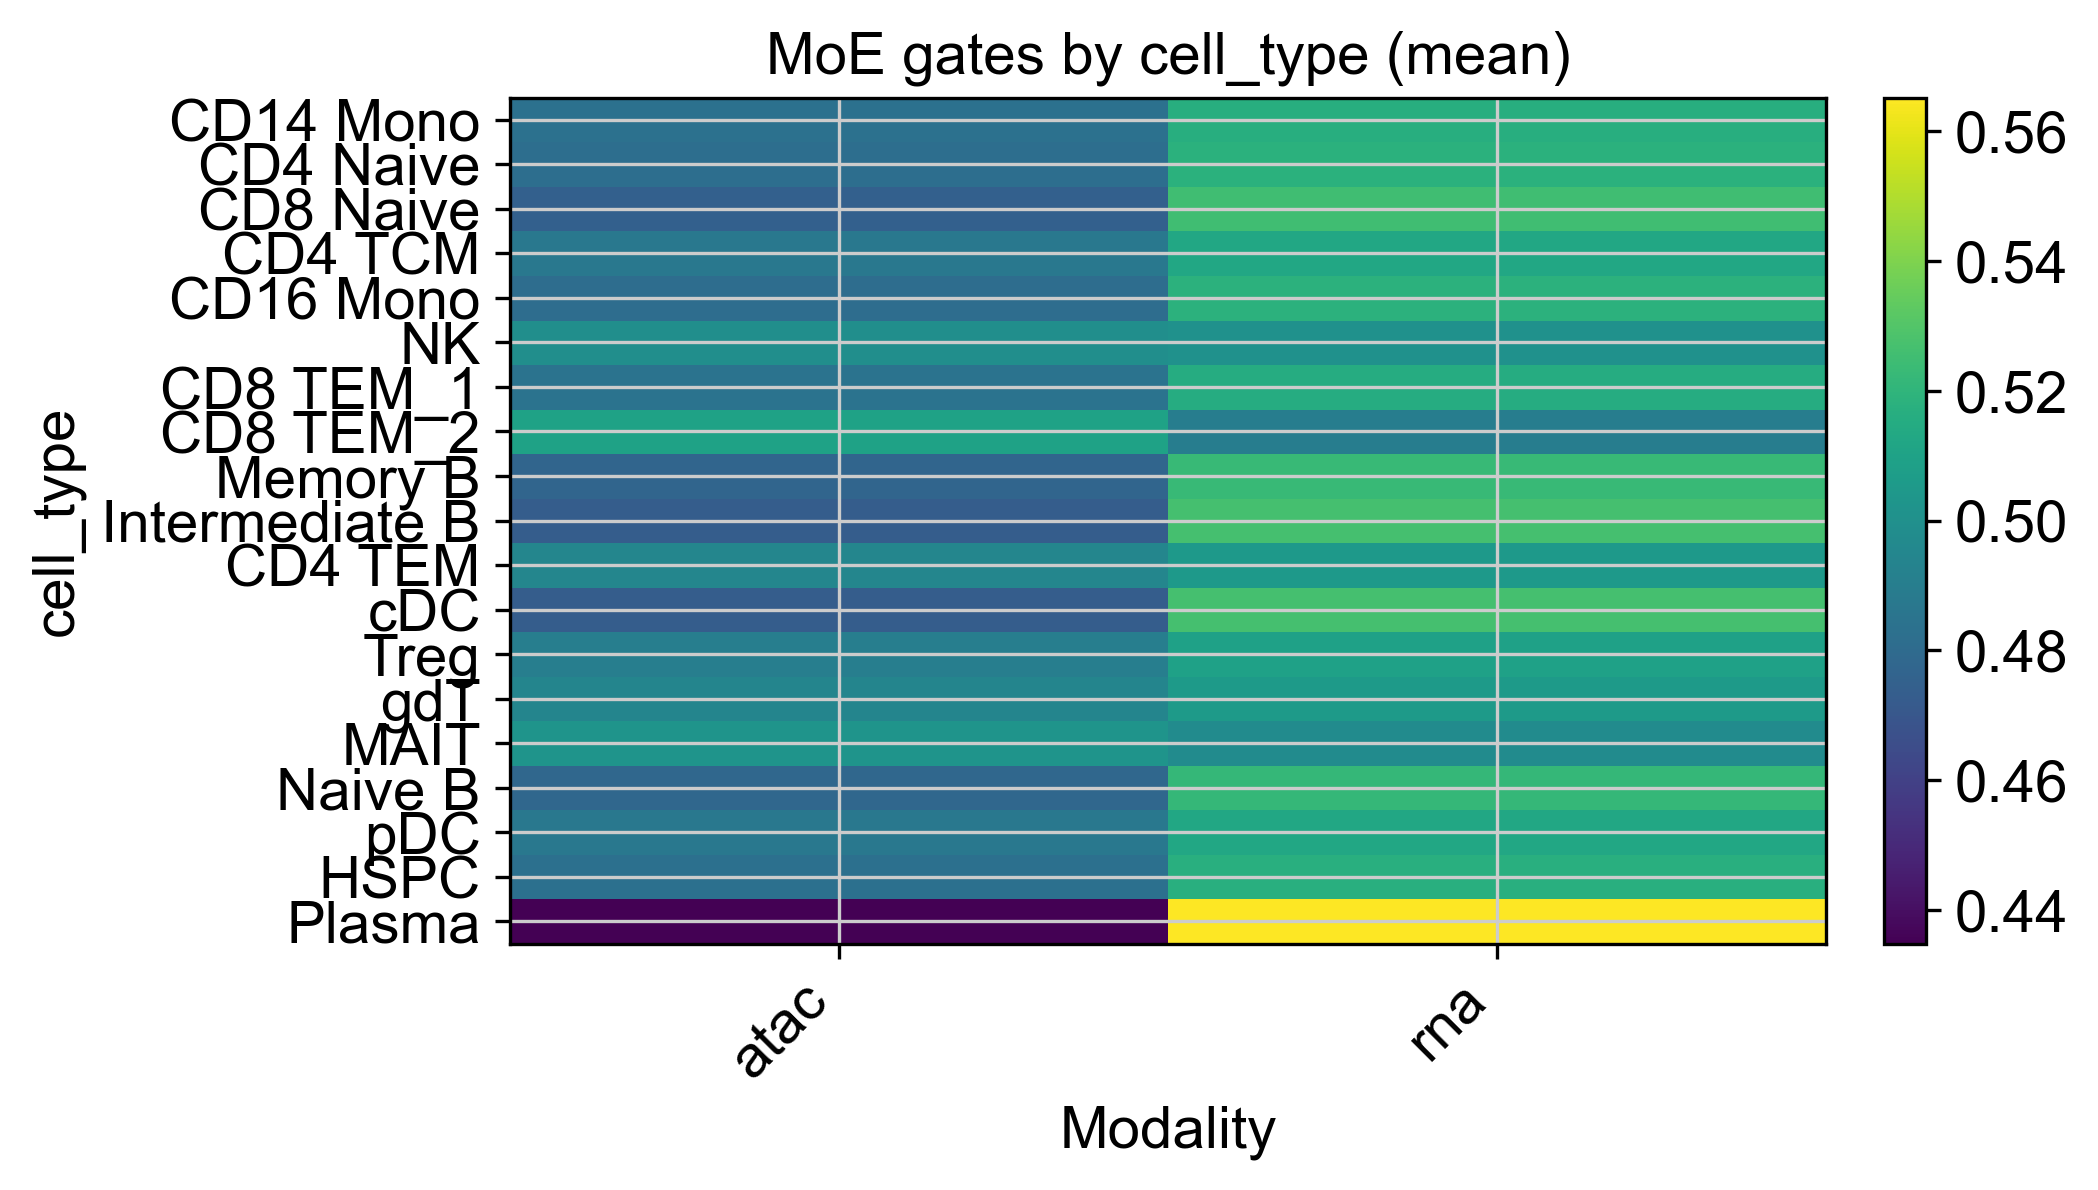

In [44]:
plot_moe_gate_summary(
    rna,
    gate_prefix="moe_gate",
    groupby="cell_type",           # or "celltype.l2", "batch", etc.
    agg="mean",
    #savepath="moe_gates_by_celltype.png",
    show=False,
)


In [45]:
print(rna)
print(atac)


AnnData object with n_obs × n_vars = 977 × 29095
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'gate_rna', 'gate_atac', 'gate_logit_rna', 'gate_logit_atac', 'moe_gate_rna', 'moe_gate_atac', 'moe_gate_logit_rna', 'moe_gate_logit_atac'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'tag', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'X_univi', 'X_umap', 'X_univi_fused'
    layers: 'counts', 'imputed_from_atac', 'denoised_fused'
    obsp: 'distances', 'connectivities'
AnnData obje

In [46]:
metrics = evaluate_alignment(
    Z1=rna.obsm["X_univi"],
    Z2=atac.obsm["X_univi"],
    metric="euclidean",
    recall_ks=(1, 5, 10, 25, 50, 100),
    k_mixing=20,
    k_entropy=30,
    labels_source=rna.obs["cell_type"].to_numpy(),
    labels_target=atac.obs["cell_type"].to_numpy(),
    compute_bidirectional_transfer=True,
    k_transfer=3,
    json_safe=True,
)

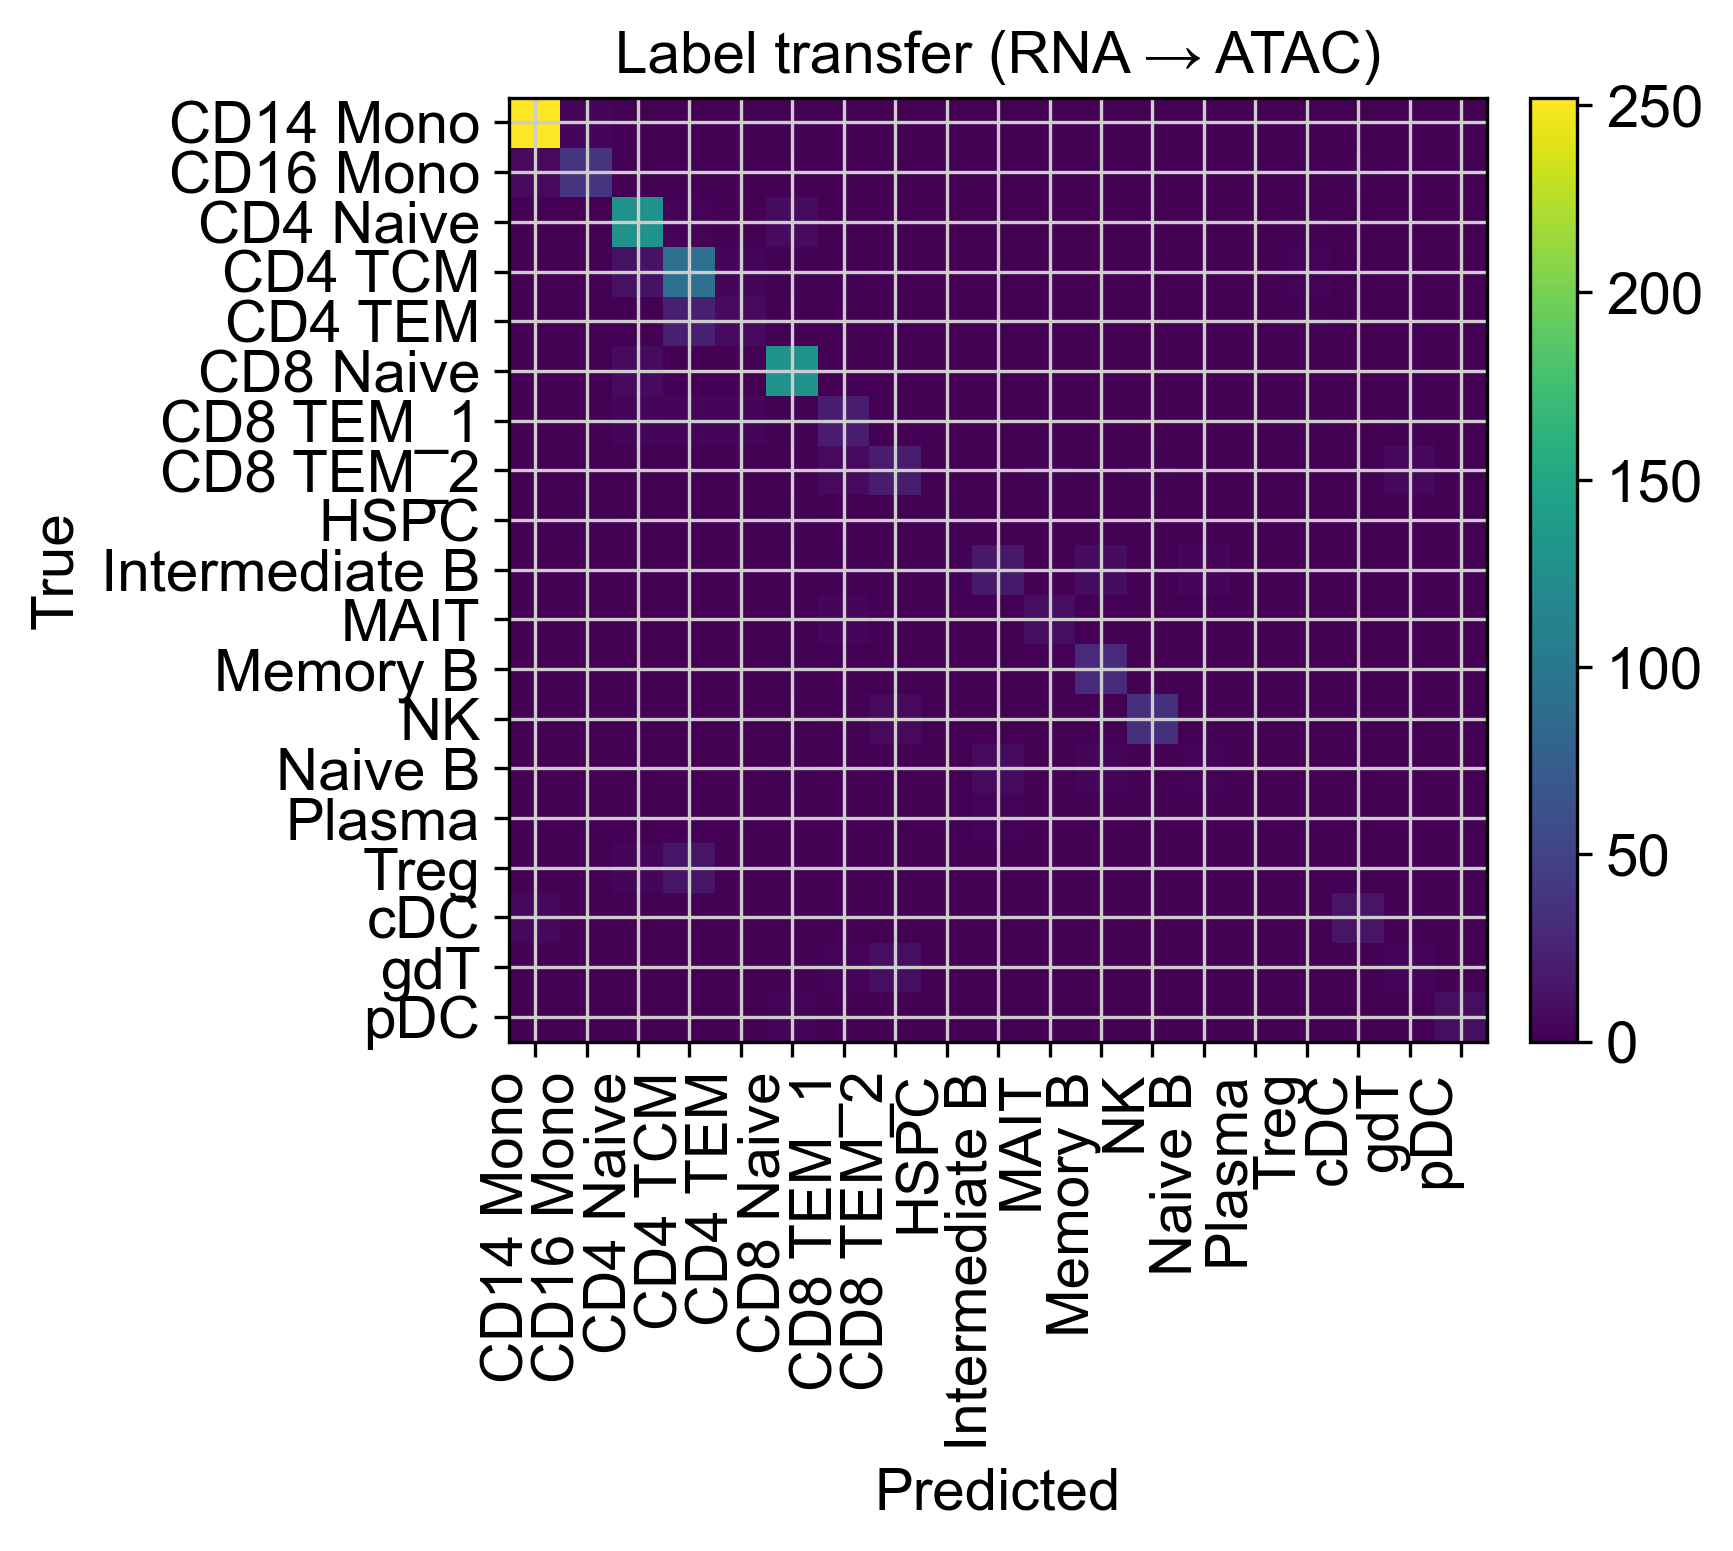

In [47]:
plot_confusion_matrix(
    np.asarray(metrics["label_transfer_cm"]),
    labels=np.asarray(metrics["label_transfer_label_order"]),
    title="Label transfer (RNA → ATAC)",
    normalize=None,
    #savepath="label_transfer_confusion.png",
    show=False,
)


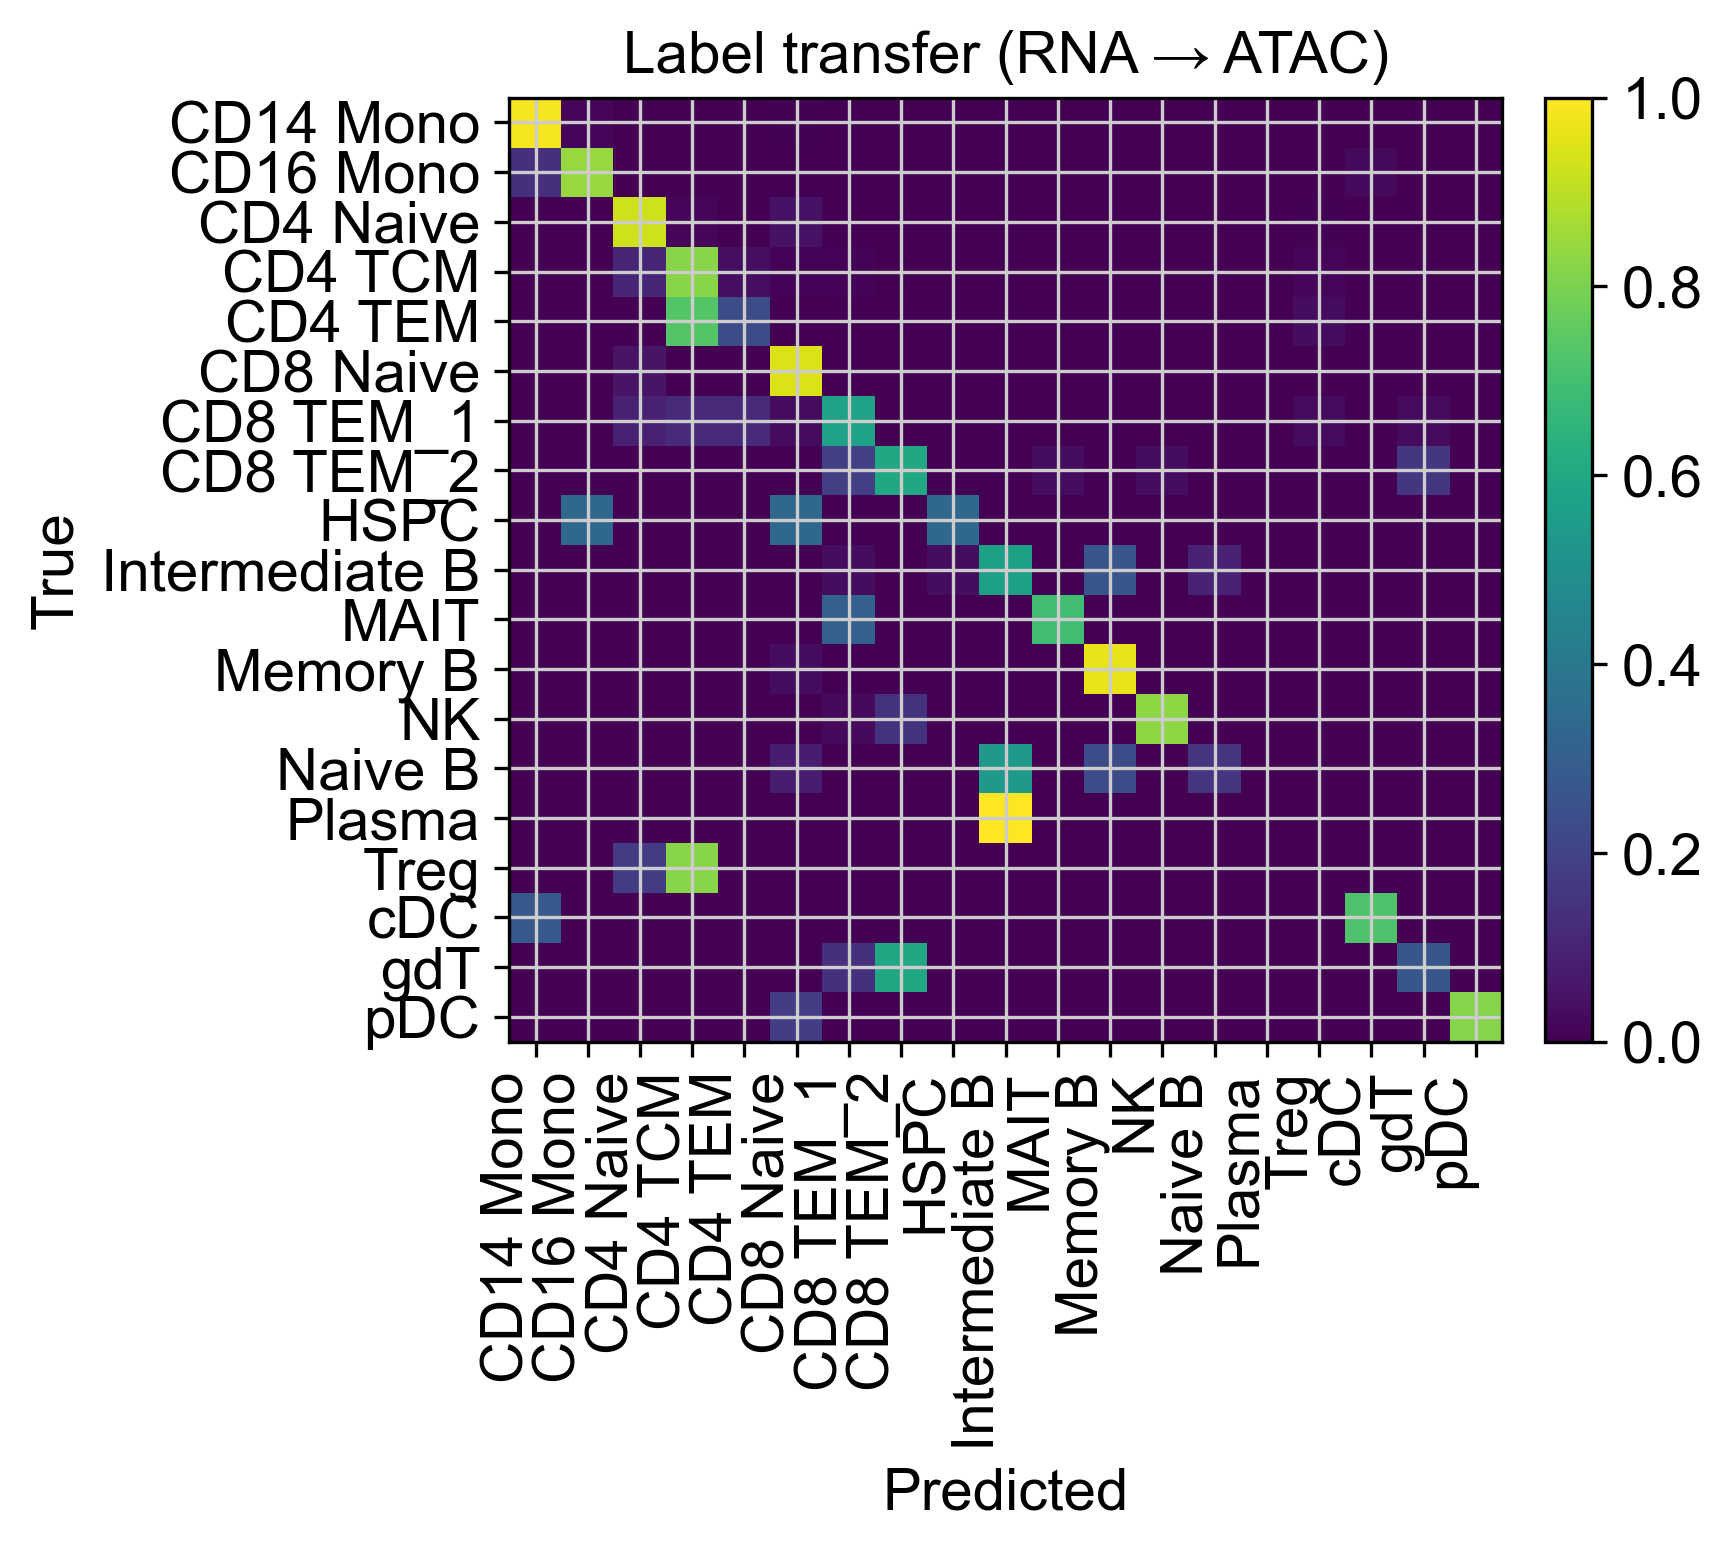

In [48]:
plot_confusion_matrix(
    np.asarray(metrics["label_transfer_cm"]),
    labels=np.asarray(metrics["label_transfer_label_order"]),
    title="Label transfer (RNA → ATAC)",
    normalize="true",
    #savepath="label_transfer_confusion.png",
    show=False,
)


In [49]:
#print(metrics)
print(f"FOSCTTM mean:          {metrics['foscttm_mean']}")
print(f"FOSCTTM sem:           {metrics['foscttm_sem']}")

print(f"Recall@1:              {metrics['recall_at_k']['1']['mean']}")
print(f"Recall@5:              {metrics['recall_at_k']['5']['mean']}")
print(f"Recall@10:             {metrics['recall_at_k']['10']['mean']}")
print(f"Recall@25:             {metrics['recall_at_k']['25']['mean']}")
print(f"Recall@50:             {metrics['recall_at_k']['50']['mean']}")
print(f"Recall@100:            {metrics['recall_at_k']['100']['mean']}")

print(f"Modality mixing mean:  {metrics['modality_mixing_mean']}")
print(f"Modality entropy mean: {metrics['modality_entropy_mean']}")
print(f"Label transfer ACC:    {metrics['label_transfer_acc']}")


FOSCTTM mean:          0.0997743174076717
FOSCTTM sem:           0.0059880036786272
Recall@1:              0.04503582395087001
Recall@5:              0.18935516888433981
Recall@10:             0.3070624360286592
Recall@25:             0.4841351074718526
Recall@50:             0.6345957011258956
Recall@100:            0.7799385875127943
Modality mixing mean:  0.4085721607294273
Modality entropy mean: 0.9096708197981699
Label transfer ACC:    0.8229273285568065


In [50]:
import re
import gzip
from pathlib import Path
from typing import Optional, Iterable, Dict, List, Tuple, Union

import numpy as np
import pandas as pd
import scipy.sparse as sp
import anndata as ad
import matplotlib.pyplot as plt


In [51]:
# -----------------------------
# Basic matrix helpers
# -----------------------------
def _to_dense(X):
    return X.toarray() if sp.issparse(X) else np.asarray(X)

def _row_to_dense(X, i: int):
    x = X[i]
    return x.toarray().ravel() if sp.issparse(x) else np.asarray(x).ravel()

def _ensure_float32(x):
    return np.asarray(x, dtype=np.float32)

def _copy_matrix_like(X):
    return X.copy() if sp.issparse(X) else np.array(X, copy=True)


In [52]:
# -----------------------------
# Genomic coordinate parsing helpers
# -----------------------------
_coord_pat = re.compile(r"^(chr[^:]+):(\d+)-(\d+)$")

def parse_peak_name(s: str):
    """
    Parse 'chr:start-end' peak names. Returns (chrom, start, end) or None.
    """
    m = _coord_pat.match(str(s))
    if m is None:
        return None
    chrom, st, en = m.group(1), int(m.group(2)), int(m.group(3))
    return chrom, st, en

def ensure_atac_peak_coords(atac: ad.AnnData,
                            chrom_col: str = "chrom",
                            start_col: str = "chromStart",
                            end_col: str = "chromEnd") -> ad.AnnData:
    """
    Ensure atac.var has chrom/start/end columns.
    If missing, try parsing atac.var_names like 'chr1:100-200'.
    """
    v = atac.var.copy()

    have_cols = all(c in v.columns for c in [chrom_col, start_col, end_col])
    if have_cols:
        # normalize dtypes
        v[chrom_col] = v[chrom_col].astype(str)
        v[start_col] = v[start_col].astype(int)
        v[end_col] = v[end_col].astype(int)
        atac.var = v
        return atac

    parsed = [parse_peak_name(x) for x in atac.var_names.astype(str)]
    ok = np.array([p is not None for p in parsed], dtype=bool)
    if not ok.all():
        bad_n = (~ok).sum()
        raise ValueError(
            f"Could not parse {bad_n} ATAC peak names from atac.var_names. "
            f"Need columns [{chrom_col}, {start_col}, {end_col}] or var_names like chr:start-end."
        )

    v[chrom_col] = [p[0] for p in parsed]
    v[start_col] = [p[1] for p in parsed]
    v[end_col]   = [p[2] for p in parsed]
    atac.var = v
    return atac


In [53]:
# -----------------------------
# GTF parser (gene entries) -> gene table with TSS (robust)
# -----------------------------
def _parse_gtf_attributes(attr_str: str) -> Dict[str, str]:
    out = {}
    for field in attr_str.strip().split(";"):
        field = field.strip()
        if not field:
            continue
        if " " not in field:
            continue
        k, v = field.split(" ", 1)
        out[k] = v.strip().strip('"')
    return out

def read_gtf_gene_table(gtf_path, feature_type: str = "gene", keep_biotypes=None) -> pd.DataFrame:
    """
    Parse GTF gene rows and return columns:
      chrom, start, end, strand, gene_id, gene_name, gene_biotype, tss
    Robust to missing gene_name (falls back to gene_id).
    """
    gtf_path = str(gtf_path)
    opener = gzip.open if gtf_path.endswith(".gz") else open

    rows = []
    with opener(gtf_path, "rt") as f:
        for line in f:
            if not line or line.startswith("#"):
                continue
            parts = line.rstrip("\n").split("\t")
            if len(parts) != 9:
                continue

            chrom, source, feat, start, end, score, strand, frame, attrs = parts
            if feat != feature_type:
                continue

            a = _parse_gtf_attributes(attrs)

            # Common alternatives across GTF/GFF-ish annotations
            gene_id = (
                a.get("gene_id")
                or a.get("ID")
                or a.get("gene")
                or a.get("Name")
            )
            if gene_id is None:
                continue

            gene_name = (
                a.get("gene_name")
                or a.get("gene_symbol")
                or a.get("Name")
                or a.get("gene")
                or gene_id
            )

            gene_biotype = (
                a.get("gene_biotype")
                or a.get("gene_type")
                or a.get("biotype")
                or None
            )

            start_i = int(start)
            end_i = int(end)
            tss = start_i if strand == "+" else end_i

            rows.append({
                "chrom": str(chrom),
                "start": start_i,
                "end": end_i,
                "strand": strand,
                "gene_id": str(gene_id),
                "gene_name": str(gene_name),  # always exists now
                "gene_biotype": gene_biotype,
                "tss": int(tss),
            })

    genes = pd.DataFrame(rows)
    if genes.empty:
        raise ValueError(f"No '{feature_type}' entries parsed from {gtf_path}")

    # Clean gene_id versions (optional but usually helpful)
    genes["gene_id"] = genes["gene_id"].astype(str).str.replace(r"\.\d+$", "", regex=True)
    genes["gene_name"] = genes["gene_name"].astype(str)

    if keep_biotypes is not None and "gene_biotype" in genes.columns:
        keep_biotypes = set(keep_biotypes)
        genes = genes[genes["gene_biotype"].isin(keep_biotypes)].copy()

    # Keep one row per gene_id (first occurrence)
    genes = genes.drop_duplicates(subset=["gene_id"]).reset_index(drop=True)
    return genes


In [54]:
# -----------------------------
# Map RNA features to GTF genes
# -----------------------------
def annotate_rna_var_with_gtf(
    rna: ad.AnnData,
    genes_gtf: pd.DataFrame,
    rna_gene_id_col: Optional[str] = "gene_id",
    rna_gene_name_col: Optional[str] = None,  # if None, use rna.var_names
) -> ad.AnnData:
    """
    Add/overwrite RNA var columns:
      gene_id, gene_name, chrom, start, end, strand, tss
    using GTF matching by gene_id first, then gene_name.
    Robust to missing gene_name in genes_gtf (falls back to gene_id).
    """
    v = rna.var.copy()

    # RNA-side queries
    if rna_gene_id_col is not None and rna_gene_id_col in v.columns:
        v["_gene_id_query"] = v[rna_gene_id_col].astype(str).str.replace(r"\.\d+$", "", regex=True)
    else:
        v["_gene_id_query"] = pd.Series([None] * v.shape[0], index=v.index, dtype="object")

    if rna_gene_name_col is not None and rna_gene_name_col in v.columns:
        v["_gene_name_query"] = v[rna_gene_name_col].astype(str)
    else:
        v["_gene_name_query"] = v.index.astype(str)  # fallback to var_names

    g = genes_gtf.copy()

    # Ensure required columns exist in GTF table
    if "gene_id" not in g.columns:
        raise KeyError("genes_gtf is missing required column 'gene_id'")
    if "gene_name" not in g.columns:
        g["gene_name"] = g["gene_id"].astype(str)  # fallback
    for c in ["chrom", "start", "end", "strand", "tss"]:
        if c not in g.columns:
            raise KeyError(f"genes_gtf is missing required column '{c}'")

    g["gene_id"] = g["gene_id"].astype(str).str.replace(r"\.\d+$", "", regex=True)
    g["gene_name"] = g["gene_name"].astype(str)

    g_by_id = g.drop_duplicates("gene_id").set_index("gene_id")
    g_by_name = g.drop_duplicates("gene_name").set_index("gene_name")

    matched = []
    for _, row in v.iterrows():
        rec = None
        gid = row["_gene_id_query"]
        gname = row["_gene_name_query"]

        if gid is not None and gid in g_by_id.index:
            rec = g_by_id.loc[gid]
        elif gname in g_by_name.index:
            rec = g_by_name.loc[gname]

        if rec is None:
            matched.append({
                "gene_id": gid if gid is not None else None,
                "gene_name": gname if gname is not None else None,
                "chrom": None,
                "start": np.nan,
                "end": np.nan,
                "strand": None,
                "tss": np.nan,
            })
        else:
            if isinstance(rec, pd.DataFrame):
                rec = rec.iloc[0]
            rec_gene_id = str(rec["gene_id"]) if "gene_id" in rec.index else (str(gid) if gid is not None else None)
            rec_gene_name = str(rec["gene_name"]) if "gene_name" in rec.index else rec_gene_id

            matched.append({
                "gene_id": rec_gene_id,
                "gene_name": rec_gene_name,
                "chrom": str(rec["chrom"]) if pd.notna(rec["chrom"]) else None,
                "start": int(rec["start"]) if pd.notna(rec["start"]) else np.nan,
                "end": int(rec["end"]) if pd.notna(rec["end"]) else np.nan,
                "strand": str(rec["strand"]) if pd.notna(rec["strand"]) else None,
                "tss": int(rec["tss"]) if pd.notna(rec["tss"]) else np.nan,
            })

    ann = pd.DataFrame(matched, index=v.index)

    for col in ann.columns:
        v[col] = ann[col].values

    v = v.drop(columns=[c for c in ["_gene_id_query", "_gene_name_query"] if c in v.columns])
    rna.var = v
    return rna


In [55]:
# REQUIRED: point this to your annotation
GTF_PATH = "./data/Homo_sapiens_GRCh38.p13.gencode.annotation.gtf"

# Example filter: keep protein-coding + lncRNA (customize)
genes_gtf = read_gtf_gene_table(
    GTF_PATH,
    feature_type="gene",
    keep_biotypes=None,
)

print(genes_gtf.columns.tolist())
display(genes_gtf.head())


['chrom', 'start', 'end', 'strand', 'gene_id', 'gene_name', 'gene_biotype', 'tss']


chrom  start    end strand          gene_id    gene_name  \
0  chr1  11869  14409      +  ENSG00000223972      DDX11L1   
1  chr1  14404  29570      -  ENSG00000227232       WASH7P   
2  chr1  17369  17436      -  ENSG00000278267    MIR6859-1   
3  chr1  29554  31109      +  ENSG00000243485  MIR1302-2HG   
4  chr1  30366  30503      +  ENSG00000284332    MIR1302-2   

                         gene_biotype    tss  
0  transcribed_unprocessed_pseudogene  11869  
1              unprocessed_pseudogene  29570  
2                               miRNA  17436  
3                              lncRNA  29554  
4                               miRNA  30366

In [56]:
# normalize RNA-side gene_id once
if "gene_id" not in rna.var.columns:
    rna.var["gene_id"] = rna.var["gene_ids"].astype(str)
rna.var["gene_id"] = rna.var["gene_id"].astype(str).str.replace(r"\.\d+$", "", regex=True)

rna = annotate_rna_var_with_gtf(
    rna,
    genes_gtf,
    rna_gene_id_col="gene_id",      # now normalized
    rna_gene_name_col="gene_name",  # you do have this
)

print("RNA gene coords mapped:", rna.var["tss"].notna().sum(), "/", rna.n_vars)
display(rna.var[["gene_id","gene_name","chrom","start","end","strand","tss"]].head())


RNA gene coords mapped: 29053 / 29095


gene_id      gene_name chrom     start       end strand  \
genes                                                                         
AL627309.1  ENSG00000238009   RP11-34P13.7  chr1   89295.0  133723.0      -   
AL627309.5  ENSG00000241860  RP11-34P13.13  chr1  141474.0  173862.0      -   
AL627309.4  ENSG00000241599   RP11-34P13.9  chr1  160446.0  161525.0      +   
AP006222.2  ENSG00000286448     AP006222.3  chr1  266855.0  268655.0      +   
AL669831.2  ENSG00000229905  RP11-206L10.4  chr1  760911.0  761989.0      +   

                 tss  
genes                 
AL627309.1  133723.0  
AL627309.5  173862.0  
AL627309.4  160446.0  
AP006222.2  266855.0  
AL669831.2  760911.0

In [57]:
# -----------------------------
# Peak <-> gene promoter mapping
# -----------------------------
def build_promoter_peak_gene_links(
    atac: ad.AnnData,
    rna: ad.AnnData,
    promoter_upstream: int = 2000,
    promoter_downstream: int = 500,
    peak_chrom_col: str = "chrom",
    peak_start_col: str = "chromStart",
    peak_end_col: str = "chromEnd",
) -> pd.DataFrame:
    """
    Returns long-form table of promoter-linked peak-gene pairs:
      peak_idx, peak_name, gene_idx, gene_name, gene_id, link_type, distance_to_tss
    Overlap criterion: peak overlaps [TSS-upstream, TSS+downstream] (strand-aware upstream/downstream)
    """
    vA = atac.var.copy()
    vR = rna.var.copy()

    need_rna_cols = ["chrom", "tss", "strand"]
    for c in need_rna_cols:
        if c not in vR.columns:
            raise ValueError(f"rna.var missing required column '{c}'. Run GTF annotation first.")

    # valid RNA genes with coords
    gene_mask = vR["chrom"].notna() & vR["tss"].notna() & vR["strand"].notna()
    vR2 = vR.loc[gene_mask].copy()

    # peak arrays
    p_ch = vA[peak_chrom_col].astype(str).values
    p_st = vA[peak_start_col].astype(int).values
    p_en = vA[peak_end_col].astype(int).values
    p_nm = atac.var_names.astype(str).values

    rows = []
    # group genes by chromosome to reduce work
    for chrom, gsub in vR2.groupby(vR2["chrom"].astype(str)):
        p_idx_chr = np.where(p_ch == str(chrom))[0]
        if p_idx_chr.size == 0:
            continue

        pst = p_st[p_idx_chr]
        pen = p_en[p_idx_chr]

        for g_idx, g in gsub.iterrows():
            tss = int(g["tss"])
            strand = str(g["strand"])

            if strand == "+":
                prom_start = tss - promoter_upstream
                prom_end   = tss + promoter_downstream
            else:
                # upstream/downstream reversed on negative strand
                prom_start = tss - promoter_downstream
                prom_end   = tss + promoter_upstream

            # overlap peak with promoter interval
            hit = (pen >= prom_start) & (pst <= prom_end)
            hit_idx_local = np.where(hit)[0]
            if hit_idx_local.size == 0:
                continue

            g_idx_pos = rna.var_names.get_loc(g_idx) if g_idx in rna.var_names else np.where(rna.var_names == g_idx)[0][0]

            for jloc in hit_idx_local:
                pi = int(p_idx_chr[jloc])
                # distance of peak midpoint to TSS
                pmid = 0.5 * (p_st[pi] + p_en[pi])
                d_tss = int(round(pmid - tss))
                rows.append({
                    "peak_idx": pi,
                    "peak_name": p_nm[pi],
                    "gene_idx": int(g_idx_pos),
                    "gene_var_name": str(g_idx),
                    "gene_id": str(g.get("gene_id", "")) if pd.notna(g.get("gene_id", None)) else None,
                    "gene_name": str(g.get("gene_name", g_idx)),
                    "chrom": str(chrom),
                    "link_type": "promoter",
                    "distance_to_tss": d_tss,
                    "weight": 1.0,
                })

    links = pd.DataFrame(rows)
    if links.empty:
        return links

    # de-dup if any
    links = links.drop_duplicates(subset=["peak_idx", "gene_idx", "link_type"]).reset_index(drop=True)
    return links


In [58]:
# -----------------------------
# Optional: enhancer <-> gene mapping from external table
# -----------------------------
def build_enhancer_peak_gene_links_from_table(
    atac: ad.AnnData,
    rna: ad.AnnData,
    enhancer_gene_df: pd.DataFrame,
    enh_chrom_col: str = "chrom",
    enh_start_col: str = "start",
    enh_end_col: str = "end",
    gene_name_col: Optional[str] = "gene_name",
    gene_id_col: Optional[str] = None,
    score_col: Optional[str] = None,
    peak_chrom_col: str = "chrom",
    peak_start_col: str = "chromStart",
    peak_end_col: str = "chromEnd",
) -> pd.DataFrame:
    """
    Overlap ATAC peaks with enhancer intervals and map to RNA genes by gene_name or gene_id.
    Returns same schema as promoter links with link_type='enhancer'.
    """
    vA = atac.var.copy()
    vR = rna.var.copy()

    # peak arrays
    p_ch = vA[peak_chrom_col].astype(str).values
    p_st = vA[peak_start_col].astype(int).values
    p_en = vA[peak_end_col].astype(int).values
    p_nm = atac.var_names.astype(str).values

    # gene lookup
    gene_name_to_idx = {}
    gene_id_to_idx = {}
    for i, (vn, row) in enumerate(vR.iterrows()):
        gname = str(row["gene_name"]) if "gene_name" in vR.columns and pd.notna(row["gene_name"]) else str(vn)
        gid = str(row["gene_id"]) if "gene_id" in vR.columns and pd.notna(row["gene_id"]) else None
        gene_name_to_idx.setdefault(gname, i)
        if gid is not None:
            gene_id_to_idx.setdefault(gid, i)

    rows = []
    df = enhancer_gene_df.copy()
    for c in [enh_chrom_col, enh_start_col, enh_end_col]:
        if c not in df.columns:
            raise ValueError(f"enhancer_gene_df missing column '{c}'")

    for _, r in df.iterrows():
        chrom = str(r[enh_chrom_col])
        st = int(r[enh_start_col])
        en = int(r[enh_end_col])

        # resolve target gene
        g_idx = None
        gene_name = None
        gene_id = None
        if gene_id_col is not None and gene_id_col in df.columns and pd.notna(r.get(gene_id_col, None)):
            gene_id = str(r[gene_id_col])
            g_idx = gene_id_to_idx.get(gene_id, None)
        if g_idx is None and gene_name_col is not None and gene_name_col in df.columns and pd.notna(r.get(gene_name_col, None)):
            gene_name = str(r[gene_name_col])
            g_idx = gene_name_to_idx.get(gene_name, None)

        if g_idx is None:
            continue

        if gene_name is None:
            rv = vR.iloc[g_idx]
            gene_name = str(rv["gene_name"]) if "gene_name" in vR.columns and pd.notna(rv.get("gene_name", None)) else str(vR.index[g_idx])
        if gene_id is None:
            rv = vR.iloc[g_idx]
            gene_id = str(rv["gene_id"]) if "gene_id" in vR.columns and pd.notna(rv.get("gene_id", None)) else None

        # overlap peaks
        mask_chr = (p_ch == chrom)
        if not np.any(mask_chr):
            continue
        idx_chr = np.where(mask_chr)[0]
        hit = (p_en[idx_chr] >= st) & (p_st[idx_chr] <= en)
        hit_idx = idx_chr[np.where(hit)[0]]

        if hit_idx.size == 0:
            continue

        w = float(r[score_col]) if (score_col is not None and score_col in df.columns and pd.notna(r.get(score_col, None))) else 1.0

        # optional TSS distance if available
        tss = None
        if "tss" in vR.columns and pd.notna(vR.iloc[g_idx].get("tss", np.nan)):
            tss = int(vR.iloc[g_idx]["tss"])

        for pi in hit_idx:
            pmid = 0.5 * (p_st[pi] + p_en[pi])
            d_tss = int(round(pmid - tss)) if tss is not None else np.nan
            rows.append({
                "peak_idx": int(pi),
                "peak_name": p_nm[pi],
                "gene_idx": int(g_idx),
                "gene_var_name": str(vR.index[g_idx]),
                "gene_id": gene_id,
                "gene_name": gene_name,
                "chrom": chrom,
                "link_type": "enhancer",
                "distance_to_tss": d_tss,
                "weight": w,
            })

    links = pd.DataFrame(rows)
    if links.empty:
        return links

    links = links.drop_duplicates(subset=["peak_idx", "gene_idx", "link_type"]).reset_index(drop=True)
    return links


In [59]:
# Build promoter links
prom_links = build_promoter_peak_gene_links(
    atac, rna,
    promoter_upstream=2000,
    promoter_downstream=500,
)

print("Promoter links:", prom_links.shape)
display(prom_links.head())


Promoter links: (20676, 10)


peak_idx           peak_name  gene_idx gene_var_name          gene_id  \
0         0  chr1:816881-817647         6        FAM87B  ENSG00000177757   
1         1  chr1:819912-823500         7     LINC01128  ENSG00000228794   
2         3  chr1:826612-827979         8     LINC00115  ENSG00000225880   
3        11  chr1:903617-907386        10    AL645608.6  ENSG00000272438   
4        12  chr1:910105-910710        11    AL645608.2  ENSG00000230699   

      gene_name chrom link_type  distance_to_tss  weight  
0        FAM87B  chr1  promoter             -107     1.0  
1     LINC01128  chr1  promoter            -3432     1.0  
2     LINC00115  chr1  promoter             -226     1.0  
3  RP11-54O7.16  chr1  promoter              668     1.0  
4   RP11-54O7.1  chr1  promoter            -1028     1.0

In [60]:
# OPTIONAL enhancer links (only if you have an enhancer-gene map)
# enhancer_df = pd.read_csv("/path/to/enhancer_gene_links.tsv", sep="\t")
# enh_links = build_enhancer_peak_gene_links_from_table(
#     atac, rna, enhancer_df,
#     enh_chrom_col="chrom", enh_start_col="start", enh_end_col="end",
#     gene_name_col="gene_name",  # or gene_id_col="gene_id"
#     score_col=None,
# )
# print("Enhancer links:", enh_links.shape)
# display(enh_links.head())

# If no enhancer file, use empty table for now
enh_links = pd.DataFrame(columns=prom_links.columns if prom_links is not None and not prom_links.empty else [
    "peak_idx","peak_name","gene_idx","gene_var_name","gene_id","gene_name","chrom","link_type","distance_to_tss","weight"
])

# Combine
peak_gene_links = pd.concat([prom_links, enh_links], axis=0, ignore_index=True)
if not peak_gene_links.empty:
    # keep max weight per (peak,gene,link_type)
    peak_gene_links = (
        peak_gene_links.sort_values(["peak_idx","gene_idx","link_type","weight"], ascending=[True, True, True, False])
        .drop_duplicates(subset=["peak_idx","gene_idx","link_type"])
        .reset_index(drop=True)
    )

print("Combined peak-gene links:", peak_gene_links.shape)
display(peak_gene_links.head(20))


Combined peak-gene links: (20676, 10)


/var/folders/fl/dl2g54g52svg861xm9w8vp6xtdpc9w/T/ipykernel_76984/3924784074.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  peak_gene_links = pd.concat([prom_links, enh_links], axis=0, ignore_index=True)


peak_idx             peak_name gene_idx gene_var_name          gene_id  \
0         0    chr1:816881-817647        6        FAM87B  ENSG00000177757   
1         1    chr1:819912-823500        7     LINC01128  ENSG00000228794   
2         3    chr1:826612-827979        8     LINC00115  ENSG00000225880   
3        11    chr1:903617-907386       10    AL645608.6  ENSG00000272438   
4        12    chr1:910105-910710       11    AL645608.2  ENSG00000230699   
5        14    chr1:920493-926443       12     LINC02593  ENSG00000223764   
6        14    chr1:920493-926443       13        SAMD11  ENSG00000187634   
7        19    chr1:958518-963388       14         NOC2L  ENSG00000188976   
8        19    chr1:958518-963388       15        KLHL17  ENSG00000187961   
9        20    chr1:965294-968061       16       PLEKHN1  ENSG00000187583   
10       26   chr1:994735-1006799       17    AL645608.7  ENSG00000272512   
11       26   chr1:994735-1006799       18          HES4  ENSG00000188290   
12       26   chr1:994735-1006799       19         ISG15  ENSG00000187608   
13       29  chr1:1012606-1015854       20    AL645608.1  ENSG00000224969   
14       30  chr1:1016432-1028059       21          AGRN  ENSG00000188157   
15       42  chr1:1115011-1118473       22      C1orf159  ENSG00000131591   
16       44  chr1:1134636-1138947       24     LINC01342  ENSG00000223823   
17       49  chr1:1165365-1172585       25    AL390719.2  ENSG00000272141   
18       49  chr1:1165365-1172585       27        TTLL10  ENSG00000162571   
19       50  chr1:1173115-1174478       27        TTLL10  ENSG00000162571   

        gene_name chrom link_type distance_to_tss  weight  
0          FAM87B  chr1  promoter            -107     1.0  
1       LINC01128  chr1  promoter           -3432     1.0  
2       LINC00115  chr1  promoter            -226     1.0  
3    RP11-54O7.16  chr1  promoter             668     1.0  
4     RP11-54O7.1  chr1  promoter           -1028     1.0  
5       LINC02593  chr1  promoter            2452     1.0  
6          SAMD11  chr1  promoter            -455     1.0  
7           NOC2L  chr1  promoter            1644     1.0  
8          KLHL17  chr1  promoter             369     1.0  
9         PLEKHN1  chr1  promoter             196     1.0  
10   RP11-54O7.17  chr1  promoter            2716     1.0  
11           HES4  chr1  promoter             595     1.0  
12          ISG15  chr1  promoter            -371     1.0  
13   RP11-54O7.11  chr1  promoter            1037     1.0  
14           AGRN  chr1  promoter            2126     1.0  
15       C1orf159  chr1  promoter             381     1.0  
16      LINC01342  chr1  promoter            -226     1.0  
17  RP11-465B22.8  chr1  promoter            -382     1.0  
18         TTLL10  chr1  promoter           -4905     1.0  
19         TTLL10  chr1  promoter             -84     1.0

In [61]:
# -----------------------------
# Gene set -> peak selection
# -----------------------------
def _normalize_gene_list(gene_list: Iterable[str]) -> List[str]:
    return [str(g).strip() for g in gene_list if str(g).strip()]

def select_peaks_for_gene_set(
    peak_gene_links: pd.DataFrame,
    gene_set: Iterable[str],
    match_on: str = "gene_name",     # "gene_name" or "gene_id"
    include_link_types: Tuple[str, ...] = ("promoter", "enhancer"),
    dedup: bool = True,
) -> Dict[str, Union[np.ndarray, pd.DataFrame, List[str]]]:
    """
    Returns peak indices and metadata for peaks linked to genes in gene_set.
    """
    if peak_gene_links is None or peak_gene_links.empty:
        return {"peak_idx": np.array([], dtype=int), "links": pd.DataFrame(), "genes_found": [], "genes_missing": list(_normalize_gene_list(gene_set))}

    genes = _normalize_gene_list(gene_set)
    if match_on not in ("gene_name", "gene_id"):
        raise ValueError("match_on must be 'gene_name' or 'gene_id'")

    df = peak_gene_links.copy()
    df = df[df["link_type"].isin(include_link_types)].copy()

    # exact matching
    q = set(genes)
    mask = df[match_on].astype(str).isin(q)
    sub = df.loc[mask].copy()

    genes_found = sorted(sub[match_on].dropna().astype(str).unique().tolist())
    genes_missing = sorted(list(q - set(genes_found)))

    if sub.empty:
        return {"peak_idx": np.array([], dtype=int), "links": sub, "genes_found": genes_found, "genes_missing": genes_missing}

    if dedup:
        peak_idx = np.sort(sub["peak_idx"].astype(int).unique())
    else:
        peak_idx = sub["peak_idx"].astype(int).values

    return {
        "peak_idx": peak_idx,
        "links": sub.reset_index(drop=True),
        "genes_found": genes_found,
        "genes_missing": genes_missing,
    }


In [62]:
# Example gene set (replace with your set)
gene_set = ["IL7R", "LTB", "MALAT1"]  # just example symbols

sel = select_peaks_for_gene_set(
    peak_gene_links,
    gene_set,
    match_on="gene_name",
    include_link_types=("promoter", "enhancer"),  # change to ("promoter",) if you want strict promoter-only
)

print("Genes found:", sel["genes_found"])
print("Genes missing:", sel["genes_missing"])
print("Selected peaks:", len(sel["peak_idx"]))
display(sel["links"].head(30))


Genes found: ['IL7R', 'LTB', 'MALAT1']
Genes missing: []
Selected peaks: 3


peak_idx                peak_name gene_idx gene_var_name          gene_id  \
0    17884  chr11:65495700-65511442    15945        MALAT1  ENSG00000251562   
1    79149   chr5:35850992-35860227     7753          IL7R  ENSG00000168685   
2    85701   chr6:31570764-31583399     9360           LTB  ENSG00000227507   

  gene_name  chrom link_type distance_to_tss  weight  
0    MALAT1  chr11  promoter            5883     1.0  
1      IL7R   chr5  promoter            2914     1.0  
2       LTB   chr6  promoter           -5440     1.0

In [63]:
# -----------------------------
# Create perturbed ATAC AnnData from existing cells
# -----------------------------
def _get_atac_input_matrix(atac: ad.AnnData, layer: Optional[str] = None):
    if layer is None or layer == "X":
        return atac.X
    if layer not in atac.layers:
        raise KeyError(f"Layer '{layer}' not found in atac.layers")
    return atac.layers[layer]

def _set_atac_input_matrix(atac_new: ad.AnnData, X_new, layer: Optional[str] = None):
    if layer is None or layer == "X":
        atac_new.X = X_new
    else:
        atac_new.layers[layer] = X_new

def subset_cells_to_adata(atac: ad.AnnData, cell_idx: Union[int, np.ndarray, List[int]]) -> ad.AnnData:
    if np.isscalar(cell_idx):
        return atac[[int(cell_idx)]].copy()
    idx = np.asarray(cell_idx, dtype=int)
    return atac[idx].copy()

def perturb_atac_peaks(
    atac_src: ad.AnnData,
    peak_idx: Union[np.ndarray, List[int]],
    *,
    cell_idx: Optional[Union[int, List[int], np.ndarray]] = None,
    input_layer: Optional[str] = None,  # the layer used for ATAC->RNA prediction
    mode: str = "set",                  # "set", "off", "on", "scale", "add"
    value: float = 0.0,                 # used for set/scale/add
    clip_min: Optional[float] = 0.0,
    clip_max: Optional[float] = 1.0,
    keep_other_layers: bool = True,
) -> Tuple[ad.AnnData, ad.AnnData]:
    """
    Returns (baseline_adata, perturbed_adata), same cells/features, perturbation applied to selected peaks only.

    mode:
      - 'off'   -> set selected peaks to 0
      - 'on'    -> set selected peaks to 1
      - 'set'   -> set selected peaks to `value`
      - 'scale' -> selected peaks *= value
      - 'add'   -> selected peaks += value
    """
    peak_idx = np.unique(np.asarray(peak_idx, dtype=int))
    if peak_idx.size == 0:
        raise ValueError("peak_idx is empty; no peaks selected for perturbation")

    if cell_idx is None:
        base = atac_src.copy()
    else:
        base = subset_cells_to_adata(atac_src, cell_idx)

    pert = base.copy()

    Xb = _get_atac_input_matrix(base, layer=input_layer)
    Xp = _get_atac_input_matrix(pert, layer=input_layer)

    # Convert to editable format
    if sp.issparse(Xp):
        # LIL is convenient for column assignment in subsets; convert back after
        Xp_edit = Xp.tolil(copy=True)
        Xb_view = Xb  # baseline not edited
        is_sparse = True
    else:
        Xp_edit = np.array(Xp, copy=True)
        Xb_view = Xb
        is_sparse = False

    # Apply perturbation
    if mode == "off":
        set_val = 0.0
        if is_sparse:
            Xp_edit[:, peak_idx] = set_val
        else:
            Xp_edit[:, peak_idx] = set_val

    elif mode == "on":
        set_val = 1.0
        if is_sparse:
            Xp_edit[:, peak_idx] = set_val
        else:
            Xp_edit[:, peak_idx] = set_val

    elif mode == "set":
        set_val = float(value)
        if is_sparse:
            Xp_edit[:, peak_idx] = set_val
        else:
            Xp_edit[:, peak_idx] = set_val

    elif mode == "scale":
        if is_sparse:
            # operate row-by-row for sparse LIL; easiest is dense slice if small, else CSR multiply
            Xtmp = Xp_edit.tocsr(copy=True)
            Xtmp[:, peak_idx] = Xtmp[:, peak_idx].multiply(float(value))
            Xp_edit = Xtmp.tolil(copy=True)
        else:
            Xp_edit[:, peak_idx] *= float(value)

    elif mode == "add":
        if is_sparse:
            Xtmp = Xp_edit.tocsr(copy=True)
            Xtmp[:, peak_idx] = Xtmp[:, peak_idx] + float(value)
            Xp_edit = Xtmp.tolil(copy=True)
        else:
            Xp_edit[:, peak_idx] += float(value)
    else:
        raise ValueError("mode must be one of {'set','off','on','scale','add'}")

    # Clip if desired
    if clip_min is not None or clip_max is not None:
        if is_sparse:
            Xtmp = Xp_edit.tocsr(copy=True)
            if Xtmp.nnz > 0:
                data = Xtmp.data
                if clip_min is not None:
                    data = np.maximum(data, clip_min)
                if clip_max is not None:
                    data = np.minimum(data, clip_max)
                Xtmp.data = data
                Xtmp.eliminate_zeros()
            Xp_new = Xtmp
        else:
            Xp_new = Xp_edit
            if clip_min is not None:
                Xp_new = np.maximum(Xp_new, clip_min)
            if clip_max is not None:
                Xp_new = np.minimum(Xp_new, clip_max)
    else:
        Xp_new = Xp_edit.tocsr(copy=True) if is_sparse else Xp_edit

    # Write back
    _set_atac_input_matrix(pert, Xp_new, layer=input_layer)

    return base, pert


In [64]:
# -----------------------------
# Run ATAC->RNA predictions before/after perturbation
# -----------------------------
def predict_rna_from_atac_adata(
    model,
    atac_in: ad.AnnData,
    *,
    device=None,
    atac_input_layer: Optional[str] = None,
    batch_size: int = 256,
    use_moe: bool = True,
):
    """
    Thin wrapper around your existing cross_modal_predict function.
    Returns dense ndarray [n_cells, n_genes] (or whatever cross_modal_predict returns converted to array).
    """
    y = cross_modal_predict(
        model,
        adata_src=atac_in,
        src_mod="atac",
        tgt_mod="rna",
        device=device,
        layer=atac_input_layer,
        X_key="X",
        batch_size=batch_size,
        use_moe=use_moe,
    )
    return y

def run_atac_ablation_to_rna(
    model,
    atac: ad.AnnData,
    rna: ad.AnnData,
    peak_idx: Union[np.ndarray, List[int]],
    *,
    cell_idx: Optional[Union[int, List[int], np.ndarray]] = None,
    atac_input_layer: Optional[str] = None,
    mode: str = "off",
    value: float = 0.0,
    clip_min: Optional[float] = 0.0,
    clip_max: Optional[float] = 1.0,
    device=None,
    batch_size: int = 256,
    use_moe: bool = True,
    return_observed_rna: bool = True,
    rna_obs_layer: Optional[str] = None,
):
    base_atac, pert_atac = perturb_atac_peaks(
        atac,
        peak_idx,
        cell_idx=cell_idx,
        input_layer=atac_input_layer,
        mode=mode,
        value=value,
        clip_min=clip_min,
        clip_max=clip_max,
    )

    pred_base = np.asarray(
        predict_rna_from_atac_adata(
            model, base_atac,
            device=device,
            atac_input_layer=atac_input_layer,
            batch_size=batch_size,
            use_moe=use_moe
        )
    )
    pred_pert = np.asarray(
        predict_rna_from_atac_adata(
            model, pert_atac,
            device=device,
            atac_input_layer=atac_input_layer,
            batch_size=batch_size,
            use_moe=use_moe
        )
    )

    out = {
        "base_atac": base_atac,
        "pert_atac": pert_atac,
        "pred_base": pred_base,
        "pred_pert": pred_pert,
        "delta_pred": pred_pert - pred_base,
        "peak_idx": np.unique(np.asarray(peak_idx, dtype=int)),
        "mode": mode,
        "value": value,
    }

    if return_observed_rna:
        # align observed RNA rows to selected cells if needed
        if cell_idx is None:
            rna_sub = rna
        elif np.isscalar(cell_idx):
            rna_sub = rna[[int(cell_idx)]].copy()
        else:
            rna_sub = rna[np.asarray(cell_idx, dtype=int)].copy()

        Xo = rna_sub.X if (rna_obs_layer is None or rna_obs_layer == "X") else rna_sub.layers[rna_obs_layer]
        out["obs_rna"] = _to_dense(Xo)

    return out


In [65]:
# -----------------------------
# Gene-level delta summaries
# -----------------------------
def _gene_name_series(rna: ad.AnnData) -> pd.Series:
    if "gene_name" in rna.var.columns:
        return rna.var["gene_name"].astype(str)
    return pd.Series(rna.var_names.astype(str), index=rna.var_names)

def gene_indices_from_list(
    rna: ad.AnnData,
    genes: Iterable[str],
    match_on: str = "gene_name",  # "gene_name" or "gene_id" or "var_names"
) -> np.ndarray:
    genes = [str(g) for g in genes]
    if match_on == "gene_name":
        if "gene_name" in rna.var.columns:
            s = rna.var["gene_name"].astype(str).values
        else:
            s = rna.var_names.astype(str).values
    elif match_on == "gene_id":
        if "gene_id" not in rna.var.columns:
            raise KeyError("rna.var['gene_id'] not found")
        s = rna.var["gene_id"].astype(str).values
    elif match_on == "var_names":
        s = rna.var_names.astype(str).values
    else:
        raise ValueError("match_on must be 'gene_name', 'gene_id', or 'var_names'")

    lookup = {}
    for i, x in enumerate(s):
        lookup.setdefault(x, i)

    idx = [lookup[g] for g in genes if g in lookup]
    return np.unique(np.asarray(idx, dtype=int))

def summarize_delta_by_gene(
    rna: ad.AnnData,
    pred_base: np.ndarray,
    pred_pert: np.ndarray,
    *,
    obs_rna: Optional[np.ndarray] = None,
    sort_by: str = "mean_delta_abs",  # or "mean_delta"
) -> pd.DataFrame:
    """
    pred_base/pred_pert shape [n_cells, n_genes]
    """
    pb = np.asarray(pred_base)
    pp = np.asarray(pred_pert)
    d = pp - pb

    gene_name = rna.var["gene_name"].astype(str).values if "gene_name" in rna.var.columns else rna.var_names.astype(str).values
    gene_id = rna.var["gene_id"].astype(str).values if "gene_id" in rna.var.columns else np.array([None] * rna.n_vars, dtype=object)

    df = pd.DataFrame({
        "gene_idx": np.arange(rna.n_vars, dtype=int),
        "gene_var_name": rna.var_names.astype(str).values,
        "gene_name": gene_name,
        "gene_id": gene_id,
        "mean_pred_base": pb.mean(axis=0),
        "mean_pred_pert": pp.mean(axis=0),
        "mean_delta": d.mean(axis=0),
        "mean_delta_abs": np.abs(d).mean(axis=0),
        "median_delta": np.median(d, axis=0),
        "frac_pos_delta": (d > 0).mean(axis=0),
        "frac_neg_delta": (d < 0).mean(axis=0),
    })

    if obs_rna is not None:
        o = np.asarray(obs_rna)
        if o.ndim == 2 and o.shape[1] == rna.n_vars:
            df["mean_obs"] = o.mean(axis=0)

    ascending = False
    if sort_by not in df.columns:
        sort_by = "mean_delta_abs"
    df = df.sort_values(sort_by, ascending=ascending).reset_index(drop=True)
    return df

def summarize_target_gene_set_response(
    rna: ad.AnnData,
    delta_pred: np.ndarray,
    gene_set: Iterable[str],
    match_on: str = "gene_name"
) -> pd.DataFrame:
    idx = gene_indices_from_list(rna, gene_set, match_on=match_on)
    if idx.size == 0:
        return pd.DataFrame(columns=["gene_idx","gene_name","gene_id","mean_delta","median_delta","mean_abs_delta"])

    d = np.asarray(delta_pred)[:, idx]
    sub = rna.var.iloc[idx].copy()

    out = pd.DataFrame({
        "gene_idx": idx,
        "gene_var_name": rna.var_names[idx].astype(str),
        "gene_name": sub["gene_name"].astype(str).values if "gene_name" in sub.columns else rna.var_names[idx].astype(str),
        "gene_id": sub["gene_id"].astype(str).values if "gene_id" in sub.columns else [None] * idx.size,
        "mean_delta": d.mean(axis=0),
        "median_delta": np.median(d, axis=0),
        "mean_abs_delta": np.abs(d).mean(axis=0),
        "frac_pos_delta": (d > 0).mean(axis=0),
        "frac_neg_delta": (d < 0).mean(axis=0),
    }).sort_values("mean_abs_delta", ascending=False).reset_index(drop=True)

    return out


In [66]:
# -----------------------------
# Null peak sets matched by chromosome/width (optional but very useful)
# -----------------------------
def sample_matched_null_peak_sets(
    atac: ad.AnnData,
    target_peak_idx: np.ndarray,
    n_sets: int = 100,
    *,
    peak_chrom_col: str = "chrom",
    peak_start_col: str = "chromStart",
    peak_end_col: str = "chromEnd",
    match_chrom: bool = True,
    match_width: bool = True,
    random_state: int = 0,
) -> List[np.ndarray]:
    rng = np.random.default_rng(random_state)
    v = atac.var.copy()

    p_ch = v[peak_chrom_col].astype(str).values
    p_st = v[peak_start_col].astype(int).values
    p_en = v[peak_end_col].astype(int).values
    p_w = (p_en - p_st).astype(int)

    tgt = np.unique(np.asarray(target_peak_idx, dtype=int))
    all_idx = np.arange(atac.n_vars, dtype=int)

    out = []
    for _ in range(n_sets):
        chosen = []
        used = set(tgt.tolist())  # avoid picking actual target peaks
        for pi in tgt:
            cand = all_idx.copy()
            if match_chrom:
                cand = cand[p_ch[cand] == p_ch[pi]]
            if match_width:
                # exact width if possible, else nearest width bucket
                exact = cand[p_w[cand] == p_w[pi]]
                if exact.size > 0:
                    cand = exact
                else:
                    # width tolerance fallback
                    tol = max(25, int(round(0.1 * p_w[pi])))
                    near = cand[np.abs(p_w[cand] - p_w[pi]) <= tol]
                    if near.size > 0:
                        cand = near

            # remove target/used
            cand = np.array([x for x in cand if x not in used], dtype=int)
            if cand.size == 0:
                # fallback to anything not used/target
                cand = np.array([x for x in all_idx if x not in used], dtype=int)
            pick = int(rng.choice(cand))
            chosen.append(pick)
            used.add(pick)
        out.append(np.array(chosen, dtype=int))
    return out


In [67]:
def null_test_target_gene_set_response(
    model,
    atac: ad.AnnData,
    rna: ad.AnnData,
    target_peak_idx: np.ndarray,
    target_gene_set: Iterable[str],
    *,
    cell_idx: Optional[Union[int, List[int], np.ndarray]] = None,
    atac_input_layer: Optional[str] = None,
    mode: str = "off",
    value: float = 0.0,
    n_null: int = 50,
    device=None,
    batch_size: int = 256,
    use_moe: bool = True,
    random_state: int = 0,
):
    # observed target perturbation
    res_target = run_atac_ablation_to_rna(
        model, atac, rna, target_peak_idx,
        cell_idx=cell_idx,
        atac_input_layer=atac_input_layer,
        mode=mode, value=value,
        device=device, batch_size=batch_size, use_moe=use_moe,
        return_observed_rna=False
    )
    tgt_df = summarize_target_gene_set_response(rna, res_target["delta_pred"], target_gene_set, match_on="gene_name")
    tgt_score = float(tgt_df["mean_abs_delta"].mean()) if not tgt_df.empty else np.nan

    # nulls
    null_sets = sample_matched_null_peak_sets(
        atac, np.asarray(target_peak_idx, dtype=int),
        n_sets=n_null, random_state=random_state
    )

    null_scores = []
    for ns in null_sets:
        res_null = run_atac_ablation_to_rna(
            model, atac, rna, ns,
            cell_idx=cell_idx,
            atac_input_layer=atac_input_layer,
            mode=mode, value=value,
            device=device, batch_size=batch_size, use_moe=use_moe,
            return_observed_rna=False
        )
        null_df = summarize_target_gene_set_response(rna, res_null["delta_pred"], target_gene_set, match_on="gene_name")
        score = float(null_df["mean_abs_delta"].mean()) if not null_df.empty else np.nan
        null_scores.append(score)

    null_scores = np.array(null_scores, dtype=float)
    p_emp = np.mean(null_scores >= tgt_score) if np.isfinite(tgt_score) else np.nan

    return {
        "target_result": res_target,
        "target_gene_summary": tgt_df,
        "target_score": tgt_score,
        "null_scores": null_scores,
        "empirical_p_ge": p_emp,
    }


In [68]:
# -----------------------------
# Visualization helpers
# -----------------------------
def plot_top_rna_deltas(
    delta_gene_df: pd.DataFrame,
    top_n: int = 30,
    metric: str = "mean_delta_abs",
    title: Optional[str] = None,
):
    if delta_gene_df.empty:
        print("No gene delta summary to plot.")
        return
    d = delta_gene_df.head(top_n).copy()
    ylab = d["gene_name"].astype(str).values if "gene_name" in d.columns else d["gene_var_name"].astype(str).values
    x = d[metric].values

    plt.figure(figsize=(8, max(4, 0.25 * len(d))))
    plt.barh(np.arange(len(d)), x)
    plt.yticks(np.arange(len(d)), ylab, fontsize=8)
    plt.gca().invert_yaxis()
    plt.xlabel(metric)
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_null_distribution(null_scores: np.ndarray, target_score: float, title: str = "Null test"):
    x = np.asarray(null_scores, dtype=float)
    x = x[np.isfinite(x)]
    plt.figure(figsize=(6, 4))
    plt.hist(x, bins=20, alpha=0.8)
    plt.axvline(target_score, linewidth=2)
    plt.xlabel("Mean abs ΔRNA in target gene set")
    plt.ylabel("Count")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [69]:
# ============================================================
# EXAMPLE: gene-set-guided ATAC ablation/activation -> RNA
# ============================================================

# 1) Define the gene set you want to perturb through chromatin
gene_set = ["IL7R", "LTB", "MALAT1"]  # replace with your real pathway / signature genes

# 2) Select linked peaks (promoter only or promoter+enhancer)
sel = select_peaks_for_gene_set(
    peak_gene_links,
    gene_set,
    match_on="gene_name",
    include_link_types=("promoter", "enhancer"),  # or ("promoter",)
)
target_peak_idx = sel["peak_idx"]

print(f"Genes found: {sel['genes_found']}")
print(f"Genes missing: {sel['genes_missing']}")
print(f"Target peaks selected: {len(target_peak_idx)}")
display(sel["links"].sort_values(["gene_name", "link_type"]).head(50))


Genes found: ['IL7R', 'LTB', 'MALAT1']
Genes missing: []
Target peaks selected: 3


peak_idx                peak_name gene_idx gene_var_name          gene_id  \
1    79149   chr5:35850992-35860227     7753          IL7R  ENSG00000168685   
2    85701   chr6:31570764-31583399     9360           LTB  ENSG00000227507   
0    17884  chr11:65495700-65511442    15945        MALAT1  ENSG00000251562   

  gene_name  chrom link_type distance_to_tss  weight  
1      IL7R   chr5  promoter            2914     1.0  
2       LTB   chr6  promoter           -5440     1.0  
0    MALAT1  chr11  promoter            5883     1.0

In [70]:
# 3) Choose cells to perturb
#    - single cell: cell_idx = 0
#    - subset by cell type: cell_idx = np.where(atac.obs['celltype.l2'] == 'Treg')[0]
#    - all cells: cell_idx = None
cell_idx = 23  # or an integer / array of row indices


In [71]:
# 4) Run perturbation
#    If your ATAC->RNA model expects atac.layers["bin"], set atac_input_layer="bin"
#    If it expects atac.X, set atac_input_layer=None
res = run_atac_ablation_to_rna(
    model=model,
    atac=atac,
    rna=rna,
    peak_idx=target_peak_idx,
    cell_idx=cell_idx,
    #atac_input_layer="bin",   # <-- change if needed
    atac_input_layer=None,
    mode="on",                 # "off", "on", "set", "scale", "add"
    value=50.0,                # only used for set/scale/add
    clip_min=0.0,
    clip_max=1.0,
    device=device,             # if you have `device`
    batch_size=256,
    use_moe=True,
    return_observed_rna=True,
    rna_obs_layer=None,        # or "counts" depending on what you want to compare against
)

print("pred_base shape:", res["pred_base"].shape)
print("pred_pert shape:", res["pred_pert"].shape)
print("delta_pred shape:", res["delta_pred"].shape)


pred_base shape: (1, 29095)
pred_pert shape: (1, 29095)
delta_pred shape: (1, 29095)


In [72]:
# 5) Summarize all genes and target genes
df_delta_all = summarize_delta_by_gene(
    rna,
    pred_base=res["pred_base"],
    pred_pert=res["pred_pert"],
    obs_rna=res.get("obs_rna", None),
    sort_by="mean_delta_abs",
)

df_delta_targets = summarize_target_gene_set_response(
    rna,
    delta_pred=res["delta_pred"],
    gene_set=gene_set,
    match_on="gene_name",
)

display(df_delta_targets.head(50))
display(df_delta_all.head(50))


gene_idx gene_var_name gene_name          gene_id  mean_delta  \
0     15945        MALAT1    MALAT1  ENSG00000251562   -4.727631   
1      9360           LTB       LTB  ENSG00000227507   -0.695827   
2      7753          IL7R      IL7R  ENSG00000168685   -0.288124   

   median_delta  mean_abs_delta  frac_pos_delta  frac_neg_delta  
0     -4.727631        4.727631             0.0             1.0  
1     -0.695827        0.695827             0.0             1.0  
2     -0.288124        0.288124             0.0             1.0

gene_idx gene_var_name  gene_name          gene_id  mean_pred_base  \
0      15945        MALAT1     MALAT1  ENSG00000251562      153.083954   
1      29072        MT-CO1     MT-CO1  ENSG00000198804       35.892490   
2      28252        TMSB4X     TMSB4X  ENSG00000205542       18.357428   
3      10506          ACTB       ACTB  ENSG00000075624       15.628654   
4      29077        MT-ND3     MT-ND3  ENSG00000198840       49.391941   
5      29076        MT-CO3     MT-CO3  ENSG00000198938       50.298729   
6       2211         PTPRC      PTPRC  ENSG00000081237        6.618241   
7       7785          FYB1       FYB1  ENSG00000082074        3.448219   
8       5417         FOXP1      FOXP1  ENSG00000114861        4.100180   
9      29073        MT-CO2     MT-CO2  ENSG00000198712       62.346771   
10     29079        MT-ND4     MT-ND4  ENSG00000198886       29.382816   
11      3507        TMSB10     TMSB10  ENSG00000034510       12.400236   
12      5967         MBNL1      MBNL1  ENSG00000152601        8.647568   
13      7077          LEF1       LEF1  ENSG00000138795        1.454949   
14     16340         MAML2      MAML2  ENSG00000184384        2.537967   
15      9289         HLA-A      HLA-A  ENSG00000206503        9.598475   
16      9150        RIPOR2     RIPOR2  ENSG00000111913        6.319277   
17     29075       MT-ATP6    MT-ATP6  ENSG00000198899       56.764908   
18     10217          UTRN       UTRN  ENSG00000152818        2.467445   
19     24044        SMCHD1     SMCHD1  ENSG00000101596        3.290846   
20      4579        DOCK10     DOCK10  ENSG00000135905        4.181532   
21      9360           LTB        LTB  ENSG00000227507       10.477270   
22      9345         HLA-B      HLA-B  ENSG00000234745       13.296588   
23      8344      CDC42SE2   CDC42SE2  ENSG00000158985        3.643855   
24      1683        S100A4     S100A4  ENSG00000196154        8.019573   
25      8229         CAMK4      CAMK4  ENSG00000152495        2.872108   
26     22480          PFN1       PFN1  ENSG00000108518        5.774929   
27     23371         SKAP1      SKAP1  ENSG00000141293        4.590117   
28     12613        PABPC1     PABPC1  ENSG00000070756        6.751267   
29     29070        MT-ND1     MT-ND1  ENSG00000198888       20.922598   
30     29082        MT-CYB     MT-CYB  ENSG00000198727       36.357891   
31     21483         PRKCB      PRKCB  ENSG00000166501        1.382583   
32      7257        INPP4B     INPP4B  ENSG00000109452        5.293774   
33     23894        RNF213     RNF213  ENSG00000173821        3.372329   
34     19412         PRKCH      PRKCH  ENSG00000027075        3.244936   
35     23623          DDX5       DDX5  ENSG00000108654        3.575746   
36     26952         TSHZ2      TSHZ2  ENSG00000182463        0.469488   
37     26754        SAMHD1     SAMHD1  ENSG00000101347        2.019665   
38      8623          CD74       CD74  ENSG00000019582        1.345403   
39      9096         ATXN1      ATXN1  ENSG00000124788        2.270167   
40     17793          BTG1       BTG1  ENSG00000133639        4.462545   
41      5367          FHIT       FHIT  ENSG00000189283        0.786221   
42     15942         NEAT1      NEAT1  ENSG00000245532        3.650234   
43     28333          SAT1       SAT1  ENSG00000130066        1.042851   
44     19703         FOXN3      FOXN3  ENSG00000053254        2.624654   
45     14122         CELF2      CELF2  ENSG00000048740        3.697648   
46      8066       SERINC5    SERINC5  ENSG00000164300        1.976537   
47     17013       ARHGDIB    ARHGDIB  ENSG00000111348        3.017009   
48      5483     MTRNR2L12  MTRNR2L12  ENSG00000269028        6.101759   
49     20817        AKAP13     AKAP13  ENSG00000170776        3.048493   

    mean_pred_pert  mean_delta  mean_delta_abs  median_delta  frac_pos_delta  \
0       148.356323   -4.727631        4.727631     -4.727631             0.0   
1        37.744057    1.851566        1.851566      1.851566         

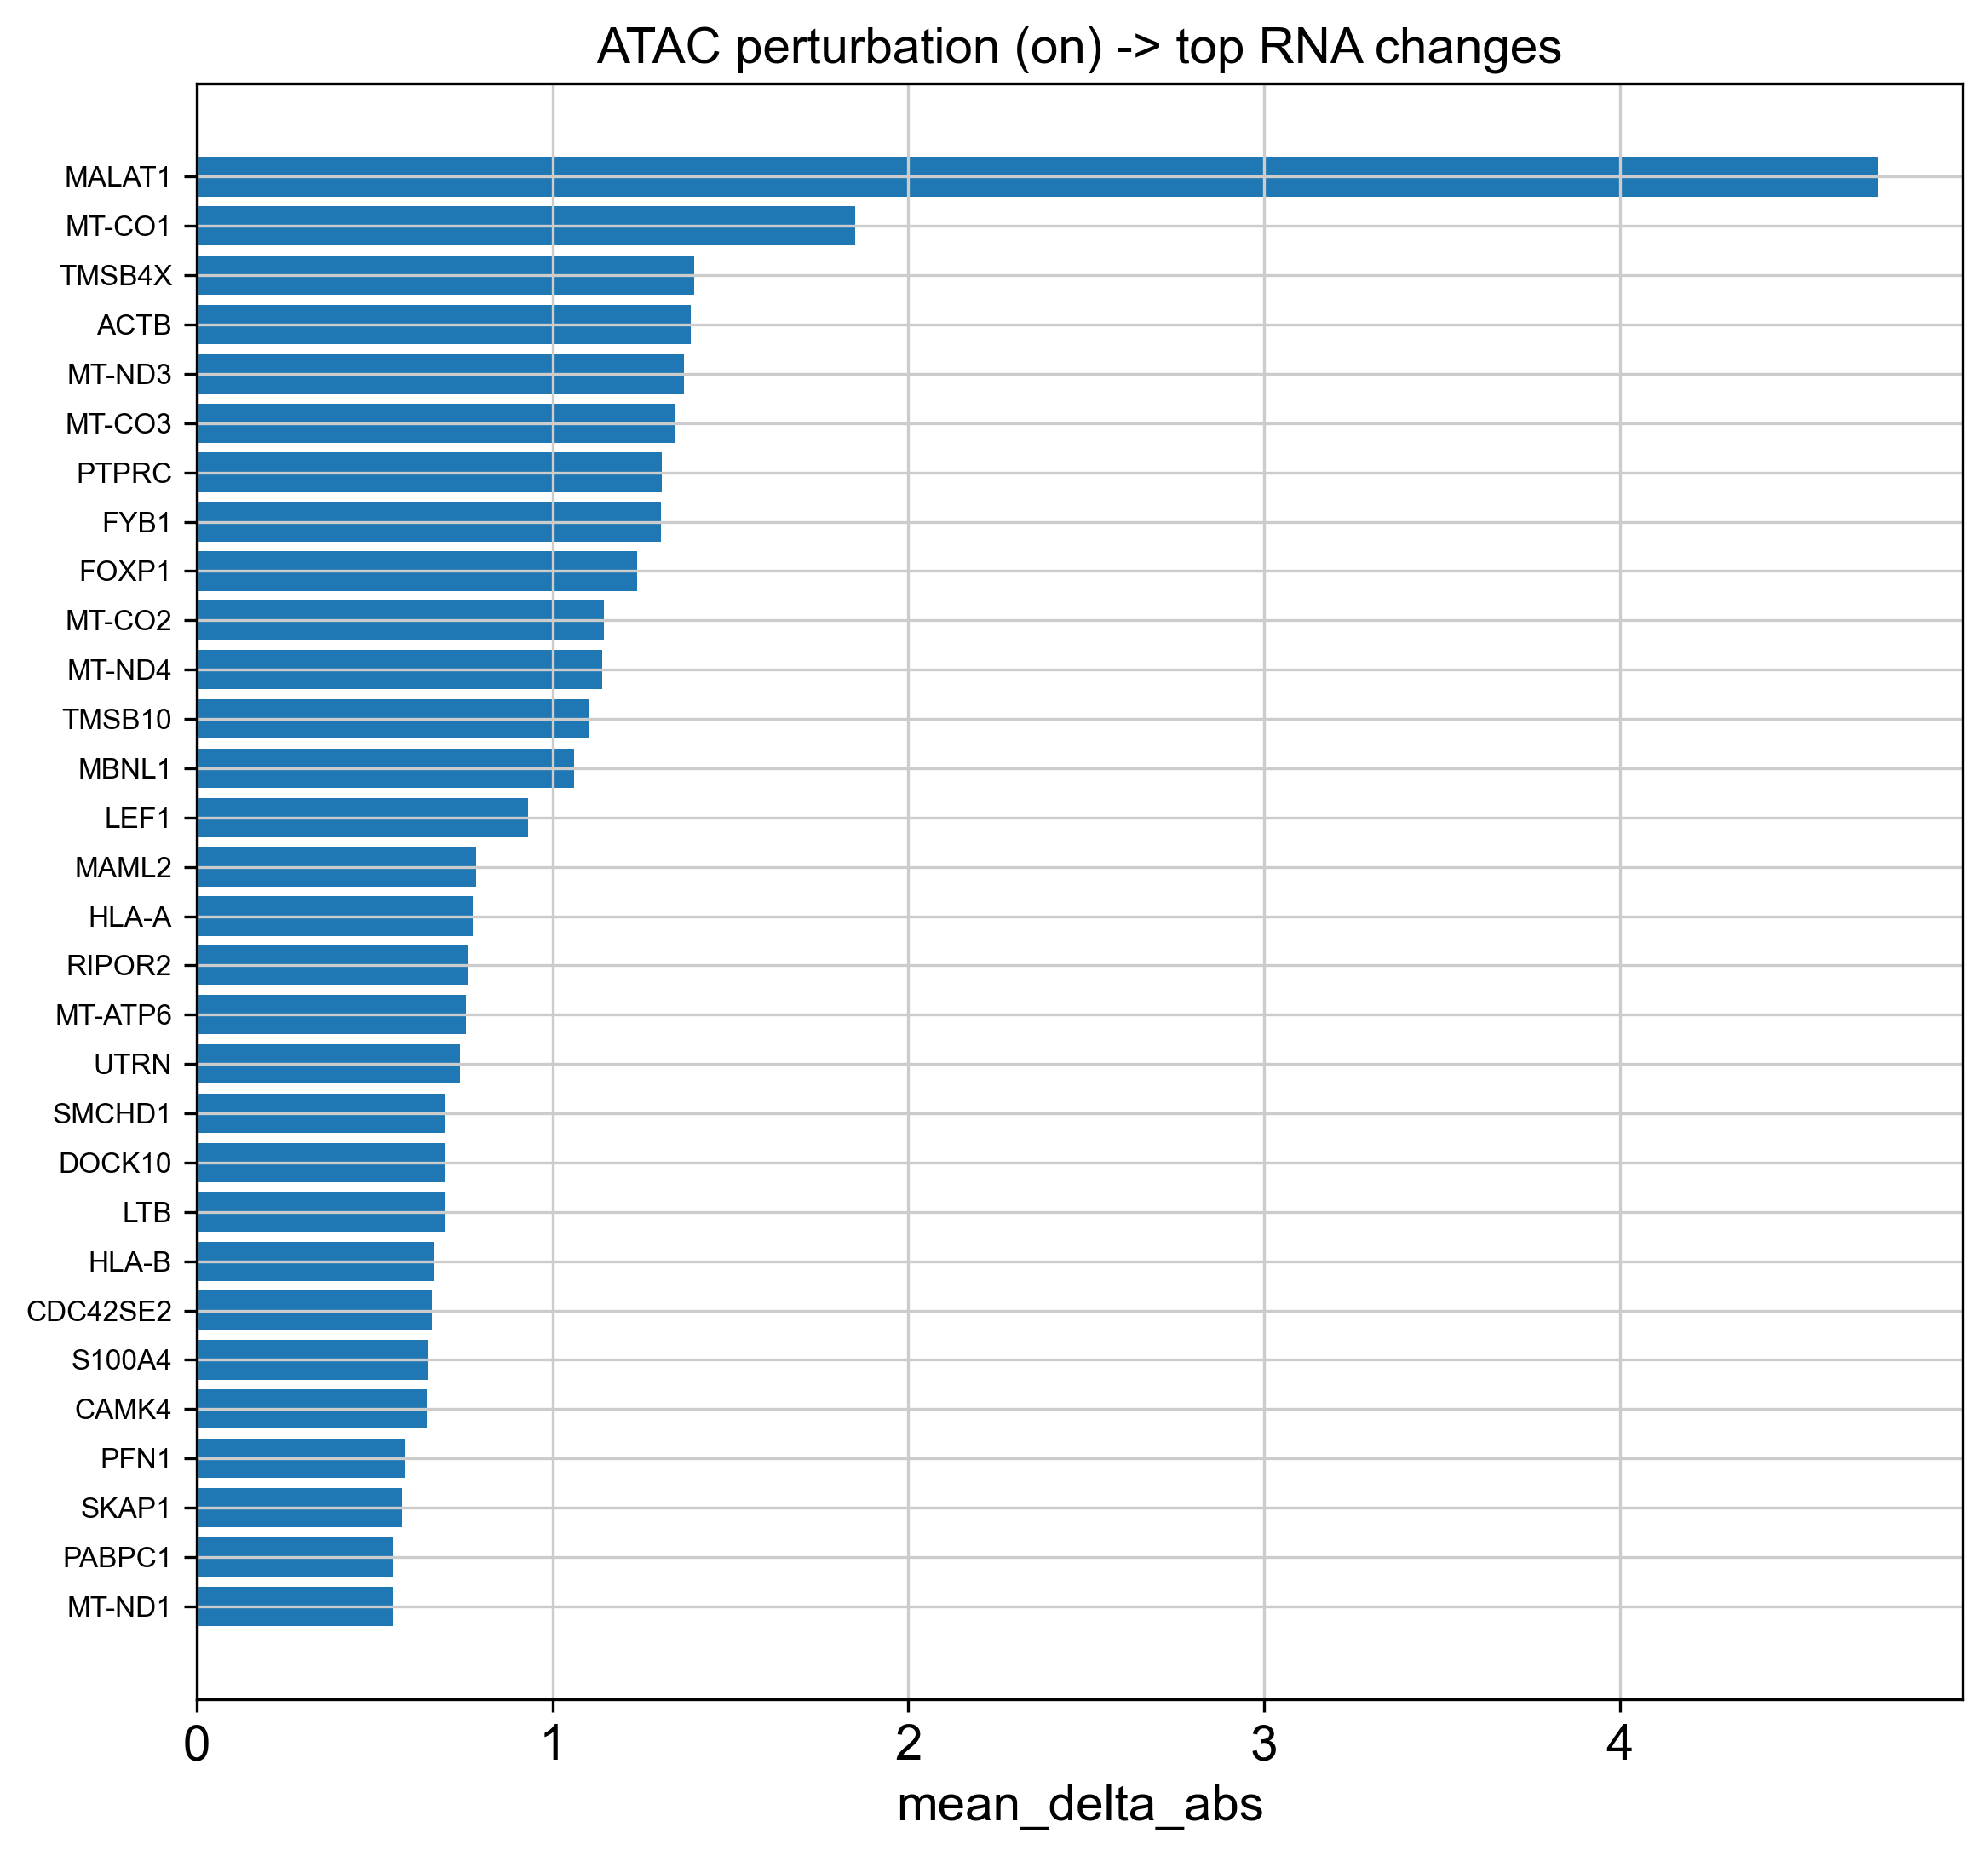

In [73]:
# 6) Plot top affected genes
plot_top_rna_deltas(
    df_delta_all,
    top_n=30,
    metric="mean_delta_abs",
    title=f"ATAC perturbation ({res['mode']}) -> top RNA changes"
)


Target score (mean abs ΔRNA over target genes): 1.9038602113723755
Empirical p-value (null >= target): 0.0


gene_idx gene_var_name gene_name          gene_id  mean_delta  \
0     15945        MALAT1    MALAT1  ENSG00000251562   -4.727631   
1      9360           LTB       LTB  ENSG00000227507   -0.695827   
2      7753          IL7R      IL7R  ENSG00000168685   -0.288124   

   median_delta  mean_abs_delta  frac_pos_delta  frac_neg_delta  
0     -4.727631        4.727631             0.0             1.0  
1     -0.695827        0.695827             0.0             1.0  
2     -0.288124        0.288124             0.0             1.0

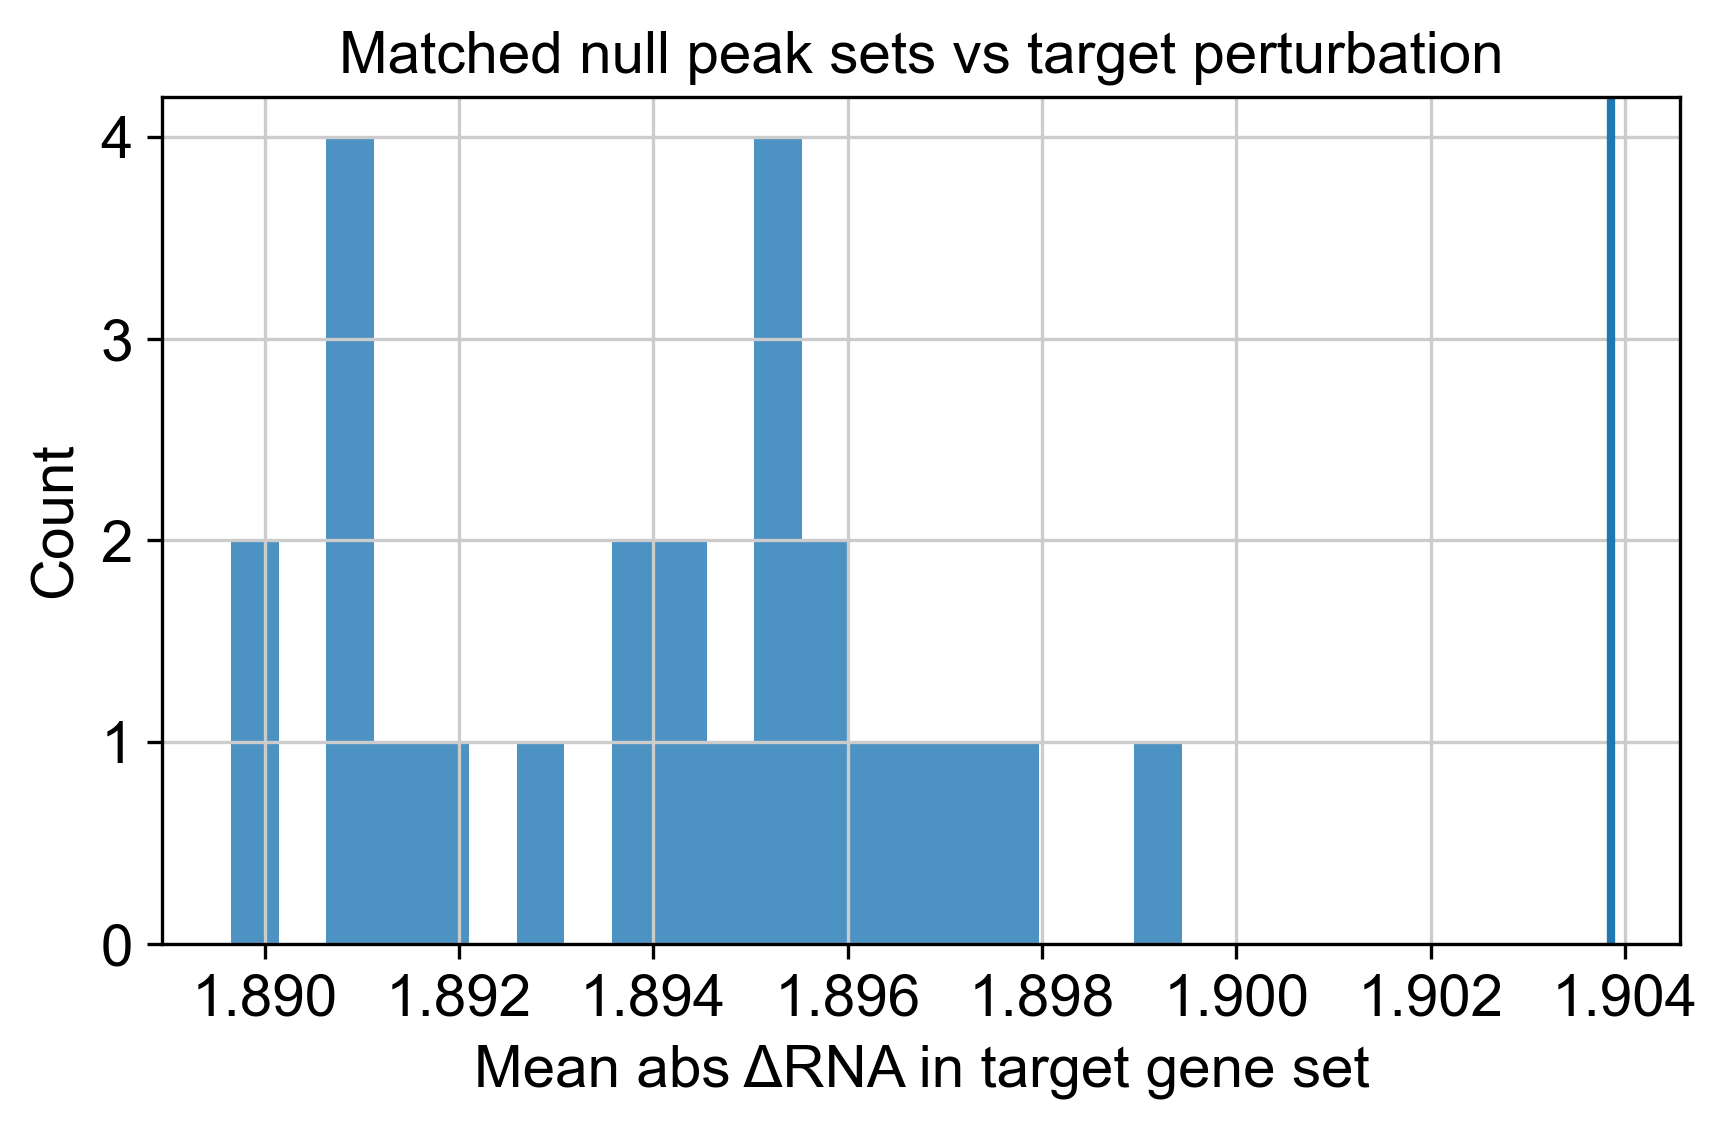

In [74]:
# 7) (Optional but recommended) Null test for specificity
null_out = null_test_target_gene_set_response(
    model=model,
    atac=atac,
    rna=rna,
    target_peak_idx=target_peak_idx,
    target_gene_set=gene_set,
    cell_idx=cell_idx,
    #atac_input_layer="bin",   # <-- match training input
    atac_input_layer=None,
    mode="on",
    value=50.0,
    n_null=25,                # start small for speed
    device=device,
    batch_size=256,
    use_moe=True,
    random_state=0,
)

print("Target score (mean abs ΔRNA over target genes):", null_out["target_score"])
print("Empirical p-value (null >= target):", null_out["empirical_p_ge"])
display(null_out["target_gene_summary"])

plot_null_distribution(
    null_out["null_scores"],
    null_out["target_score"],
    title="Matched null peak sets vs target perturbation"
)


In [75]:
# ============================================================
# Comprehensive gene complex/pathway presets (human symbols)
# Immune-heavy, useful for single-cell perturbation experiments
# ============================================================
from typing import Sequence, Mapping, Any, Iterable, Dict, List

def _dedup_keep_order(xs):
    seen = set()
    out = []
    for x in xs:
        x = str(x)
        if x not in seen:
            seen.add(x)
            out.append(x)
    return out

def _merge_presets(*lists):
    out = []
    for lst in lists:
        out.extend(list(lst))
    return _dedup_keep_order(out)


GENE_COMPLEX_PRESETS = {
    # ------------------------------------------------------------------
    # HLA / MHC / Antigen presentation
    # ------------------------------------------------------------------
    "hla_class_i_core": [
        "HLA-A", "HLA-B", "HLA-C", "B2M"
    ],

    "hla_class_i_extended": [
        "HLA-A", "HLA-B", "HLA-C", "B2M",
        "HLA-E", "HLA-F", "HLA-G"
    ],

    "hla_class_i_antigen_processing_core": [
        "HLA-A", "HLA-B", "HLA-C", "B2M",
        "TAP1", "TAP2", "TAPBP",
        "PSMB8", "PSMB9", "PSMB10",
        "ERAP1", "ERAP2",
        "NLRC5"
    ],

    "hla_class_i_antigen_processing_broad": [
        # MHC-I heavy chain + beta2m
        "HLA-A", "HLA-B", "HLA-C", "B2M",
        # non-classical
        "HLA-E", "HLA-F", "HLA-G",
        # peptide loading / trimming
        "TAP1", "TAP2", "TAPBP", "ERAP1", "ERAP2",
        "CALR", "CANX", "PDIA3",
        # immunoproteasome / processing
        "PSMB8", "PSMB9", "PSMB10", "PSME1", "PSME2",
        # regulators
        "NLRC5", "STAT1", "IRF1"
    ],

    "hla_class_ii_core": [
        "HLA-DRA", "HLA-DRB1",
        "HLA-DPA1", "HLA-DPB1",
        "HLA-DQA1", "HLA-DQB1",
        "CD74", "CIITA"
    ],

    "hla_class_ii_extended": [
        "HLA-DRA", "HLA-DRB1", "HLA-DRB5",
        "HLA-DPA1", "HLA-DPB1",
        "HLA-DQA1", "HLA-DQA2",
        "HLA-DQB1", "HLA-DQB2",
        "HLA-DMA", "HLA-DMB",
        "HLA-DOA", "HLA-DOB",
        "CD74", "CIITA", "RFX5", "RFXAP", "RFXANK"
    ],

    "mhc_antigen_presentation_broad": [
        # class I
        "HLA-A", "HLA-B", "HLA-C", "B2M",
        "HLA-E", "HLA-F", "HLA-G",
        "TAP1", "TAP2", "TAPBP",
        "ERAP1", "ERAP2",
        "PSMB8", "PSMB9", "PSMB10", "PSME1", "PSME2",
        "CALR", "CANX", "PDIA3",
        "NLRC5",
        # class II
        "HLA-DRA", "HLA-DRB1", "HLA-DRB5",
        "HLA-DPA1", "HLA-DPB1",
        "HLA-DQA1", "HLA-DQB1",
        "HLA-DMA", "HLA-DMB", "HLA-DOA", "HLA-DOB",
        "CD74", "CIITA", "RFX5", "RFXAP", "RFXANK"
    ],

    # MHC locus-focused subset (chr6-heavy genes; useful when range-restricting to MHC locus)
    "mhc_chr6_locus_class_i_processing": [
        "HLA-A", "HLA-B", "HLA-C",
        "TAP1", "TAP2", "TAPBP",
        "PSMB8", "PSMB9", "PSMB10"
    ],

    "mhc_chr6_locus_class_ii": [
        "HLA-DRA", "HLA-DRB1", "HLA-DRB5",
        "HLA-DPA1", "HLA-DPB1",
        "HLA-DQA1", "HLA-DQB1",
        "HLA-DMA", "HLA-DMB", "HLA-DOA", "HLA-DOB",
        "CD74"
    ],

    # ------------------------------------------------------------------
    # Interferon / inflammatory signaling (strongly tied to HLA programs)
    # ------------------------------------------------------------------
    "ifn_gamma_response_core": [
        "IFNGR1", "IFNGR2",
        "JAK1", "JAK2", "STAT1",
        "IRF1",
        "NLRC5", "CIITA"
    ],

    "ifn_gamma_response_extended": [
        "IFNGR1", "IFNGR2",
        "JAK1", "JAK2", "STAT1", "STAT2",
        "IRF1", "IRF8", "NFKB1", "RELA",
        "NLRC5", "CIITA",
        "GBP1", "GBP2", "GBP4", "GBP5",
        "CXCL9", "CXCL10", "CXCL11",
        "IDO1",
        "B2M", "TAP1", "TAP2", "PSMB8", "PSMB9", "PSMB10"
    ],

    "type_i_ifn_response_core": [
        "IFNAR1", "IFNAR2",
        "JAK1", "TYK2", "STAT1", "STAT2", "IRF9"
    ],

    "type_i_ifn_isg_broad": [
        "IFNAR1", "IFNAR2", "JAK1", "TYK2", "STAT1", "STAT2", "IRF9",
        "ISG15", "IFI6", "IFI27", "IFI35", "IFI44", "IFI44L",
        "IFIT1", "IFIT2", "IFIT3", "IFIT5",
        "IFITM1", "IFITM2", "IFITM3",
        "MX1", "MX2", "OAS1", "OAS2", "OAS3", "OASL",
        "RSAD2", "BST2", "CMPK2", "EPSTI1",
        "XAF1", "USP18", "DDX58", "IFIH1", "TRIM22", "TRIM25",
        "HERC5", "HERC6", "SAMD9", "SAMD9L",
        "IRF7", "IRF1", "STAT1"
    ],

    "tnf_nfkb_response_core": [
        "TNFRSF1A", "TNFRSF1B",
        "TRAF2", "RIPK1", "IKBKB",
        "NFKB1", "RELA", "RELB"
    ],

    "tnf_nfkb_response_extended": [
        "TNF", "TNFRSF1A", "TNFRSF1B",
        "TRAF2", "TRAF5", "RIPK1", "IKBKB", "CHUK", "IKBKG",
        "NFKB1", "NFKB2", "RELA", "RELB", "BCL3",
        "NFKBIA", "NFKBIZ", "TNFAIP3",
        "ICAM1", "VCAM1", "CCL2", "CCL5", "CXCL8", "IL6"
    ],

    # ------------------------------------------------------------------
    # Immune checkpoints / coinhibitory / costimulatory
    # ------------------------------------------------------------------
    "immune_checkpoints_tcell_inhibitory": [
        "PDCD1", "CTLA4", "LAG3", "TIGIT", "HAVCR2", "TOX", "TOX2"
    ],

    "immune_checkpoints_tcell_extended": [
        "PDCD1", "CTLA4", "LAG3", "TIGIT", "HAVCR2", "BTLA", "CD244", "CD160",
        "VSIR", "ENTPD1", "LAYN", "TOX", "TOX2", "EOMES", "PRDM1"
    ],

    "checkpoint_ligands_apc_tumor": [
        "CD274", "PDCD1LG2", "CD80", "CD86",
        "LGALS9", "PVR", "NECTIN2", "TNFSF9", "TNFSF4", "ICOSLG"
    ],

    "costimulation_tcell_apc": [
        "CD28", "ICOS", "TNFRSF9", "TNFRSF4", "TNFRSF18",
        "CD80", "CD86", "ICOSLG", "TNFSF9", "TNFSF4", "TNFSF18"
    ],

    # ------------------------------------------------------------------
    # Cytotoxic / NK / effector programs
    # ------------------------------------------------------------------
    "cytotoxic_effector_core": [
        "NKG7", "PRF1", "GZMB", "GNLY"
    ],

    "cytotoxic_effector_extended": [
        "NKG7", "PRF1", "GZMB", "GZMH", "GZMK", "GNLY",
        "CTSW", "CST7", "KLRD1", "KLRK1", "FCGR3A", "TYROBP", "TRAC"
    ],

    "nk_receptors_activating_inhibitory": [
        "KLRK1", "KLRC1", "KLRC2", "KLRC3", "KLRD1",
        "NCR1", "NCR2", "NCR3",
        "CD244", "FCGR3A", "TYROBP", "HCST", "SH2D1B"
    ],

    # ------------------------------------------------------------------
    # T-cell identity / activation / exhaustion / Treg
    # ------------------------------------------------------------------
    "tcell_pan_identity": [
        "CD3D", "CD3E", "CD3G", "TRAC", "TRBC1", "TRBC2", "LTB", "IL7R"
    ],

    "tcell_activation_early": [
        "IL2RA", "CD69", "TNFRSF9", "ICOS", "CD40LG", "FOS", "JUN", "JUNB", "DUSP1"
    ],

    "tcell_memory_naive_like": [
        "IL7R", "LTB", "MALAT1", "CCR7", "LTB", "MALAT1", "TCF7", "LEF1", "MALAT1", "MALAT1"
    ],

    "tcell_memory_naive_refined": [
        "IL7R", "CCR7", "LTB", "MALAT1", "TCF7", "LEF1", "MALAT1", "MALAT1",
        "MALAT1", "SELL", "MALAT1", "LTB"
    ],

    # cleaner version (use this one in practice)
    "tcell_naive_memory_clean": [
        "IL7R", "CCR7", "TCF7", "LEF1", "LTB", "SELL", "MALAT1", "MALAT1"
    ],

    "tcell_exhaustion_like": [
        "PDCD1", "LAG3", "TIGIT", "HAVCR2", "TOX", "CTLA4", "ENTPD1", "CXCL13"
    ],

    "treg_core": [
        "FOXP3", "IL2RA", "IKZF2", "TIGIT", "CTLA4", "LTB", "IL7R"
    ],

    "treg_extended": [
        "FOXP3", "IL2RA", "IKZF2", "TIGIT", "CTLA4", "TNFRSF18", "TNFRSF4",
        "BATF", "LAYN", "ENTPD1", "ICOS", "CCR8", "IL7R"
    ],

    "th1_like": [
        "TBX21", "IFNG", "CXCR3", "STAT1", "IL12RB2"
    ],

    "th17_like": [
        "RORC", "IL7R", "CCR6", "KLRB1", "IL23R", "IL17A", "IL17F"
    ],

    "tfh_like": [
        "CXCR5", "PDCD1", "ICOS", "IL21", "BCL6", "MAF", "TOX"
    ],

    # ------------------------------------------------------------------
    # B cell / plasma cell modules
    # ------------------------------------------------------------------
    "bcell_pan_identity": [
        "MS4A1", "CD79A", "CD79B", "HLA-DRA", "CD74", "CD37", "BANK1", "BLNK"
    ],

    "bcell_naive_like": [
        "MS4A1", "CD79A", "CD79B", "HVCN1", "TCL1A", "IL4R", "FCER2"
    ],

    "bcell_memory_like": [
        "MS4A1", "CD79A", "CD79B", "CD27", "TNFRSF13B", "AIM2", "BANK1"
    ],

    "plasma_cell_core": [
        "SDC1", "MZB1", "XBP1", "JCHAIN", "PRDM1", "IRF4"
    ],

    "plasma_cell_extended": [
        "SDC1", "MZB1", "XBP1", "JCHAIN", "PRDM1", "IRF4", "DERL3", "SSR4", "TXNDC5", "FKBP11"
    ],

    # ------------------------------------------------------------------
    # Myeloid / monocyte / DC / macrophage modules
    # ------------------------------------------------------------------
    "monocyte_classical_cd14": [
        "LYZ", "S100A8", "S100A9", "CTSS", "FCN1", "SAT1", "LILRB1", "TYMP"
    ],

    "monocyte_nonclassical_cd16": [
        "FCGR3A", "LST1", "IFITM3", "TYMP", "SAT1", "MS4A7", "AIF1", "CTD"
    ],

    "monocyte_ifn_inflam": [
        "IFITM3", "ISG15", "IFI6", "IFI44L", "MX1", "STAT1", "CXCL10", "GBP1", "BST2"
    ],

    "dc_cdc_identity": [
        "FCER1A", "CST3", "HLA-DRA", "CD74", "CLEC10A", "CD1C"
    ],

    "dc_pdc_identity": [
        "GZMB", "IRF7", "TCF4", "JCHAIN", "PLD4", "IFITM1", "IL3RA", "CLEC4C"
    ],

    "apc_mhcii_program": [
        "HLA-DRA", "HLA-DRB1", "HLA-DPA1", "HLA-DPB1", "HLA-DQA1", "HLA-DQB1",
        "CD74", "CIITA", "HLA-DMA", "HLA-DMB"
    ],

    "macrophage_antigen_presentation_inflam": [
        "HLA-DRA", "CD74", "CIITA", "FCER1G", "TYROBP", "CTSB", "CTSD",
        "IL1B", "TNF", "NFKBIA", "CXCL8"
    ],

    # ------------------------------------------------------------------
    # Tumor immune evasion / interferon-antigen axis (useful in cancer)
    # ------------------------------------------------------------------
    "tumor_mhc_i_evasion_axis": [
        "B2M", "HLA-A", "HLA-B", "HLA-C", "TAP1", "TAP2", "TAPBP", "NLRC5",
        "JAK1", "JAK2", "STAT1", "IRF1", "IFNGR1", "IFNGR2"
    ],

    "tumor_ifn_response_antigen_presentation": [
        "IFNGR1", "IFNGR2", "JAK1", "JAK2", "STAT1", "IRF1",
        "B2M", "HLA-A", "HLA-B", "HLA-C",
        "TAP1", "TAP2", "TAPBP",
        "PSMB8", "PSMB9", "PSMB10",
        "NLRC5", "CXCL9", "CXCL10", "CXCL11"
    ],

    "pd_l1_axis": [
        "CD274", "PDCD1LG2", "JAK1", "JAK2", "STAT1", "IRF1", "IFNGR1", "IFNGR2"
    ],

    # ------------------------------------------------------------------
    # Cell stress / apoptosis / proliferation (handy controls)
    # ------------------------------------------------------------------
    "apoptosis_intrinsic_core": [
        "BAX", "BAK1", "BCL2", "BCL2L1", "MCL1", "PMAIP1", "BBC3", "CASP3", "CASP9"
    ],

    "apoptosis_extrinsic_core": [
        "FAS", "FASLG", "TNFRSF10A", "TNFRSF10B", "CASP8", "CFLAR"
    ],

    "cell_cycle_g1s_core": [
        "MKI67", "PCNA", "MCM2", "MCM3", "MCM4", "MCM5", "MCM6", "MCM7", "TYMS", "RRM2"
    ],

    "cell_cycle_g2m_core": [
        "TOP2A", "UBE2C", "BIRC5", "AURKA", "AURKB", "CCNB1", "CCNB2", "CDC20", "CENPF"
    ],

    "hypoxia_core": [
        "HIF1A", "VEGFA", "SLC2A1", "LDHA", "PGK1", "ENO1", "BNIP3"
    ],

    "emt_like_core": [
        "VIM", "ZEB1", "ZEB2", "SNAI1", "SNAI2", "TWIST1", "FN1", "ITGA5"
    ],

    # ------------------------------------------------------------------
    # Signaling pathways (compact but useful)
    # ------------------------------------------------------------------
    "jak_stat_core": [
        "JAK1", "JAK2", "JAK3", "TYK2", "STAT1", "STAT2", "STAT3", "STAT5A", "STAT5B", "STAT6"
    ],

    "mapk_ap1_core": [
        "MAPK1", "MAPK3", "MAPK14", "JUN", "JUNB", "JUND", "FOS", "FOSB", "ATF3", "DUSP1"
    ],

    "pi3k_akt_mtor_core": [
        "PIK3CA", "PIK3CB", "PIK3CD", "AKT1", "AKT2", "AKT3", "MTOR", "RPTOR", "RICTOR", "EIF4EBP1"
    ],
}

# Clean up duplicates across all presets (and duplicate entries within a preset)
GENE_COMPLEX_PRESETS = {k: _dedup_keep_order(v) for k, v in GENE_COMPLEX_PRESETS.items()}


In [76]:
# ============================================================
# Optional aliases and compositional presets
# ============================================================
GENE_COMPLEX_ALIASES = {
    "mhc_i": "hla_class_i_core",
    "mhc_i_proc": "hla_class_i_antigen_processing_core",
    "mhc_ii": "hla_class_ii_core",
    "mhc_broad": "mhc_antigen_presentation_broad",
    "ifng": "ifn_gamma_response_extended",
    "isg": "type_i_ifn_isg_broad",
    "treg": "treg_core",
    "cytotoxic": "cytotoxic_effector_extended",
}

def resolve_complex_preset_name(name: str) -> str:
    name = str(name)
    return GENE_COMPLEX_ALIASES.get(name, name)

def add_composite_preset(name: str, preset_names: Sequence[str], overwrite: bool = False):
    """
    Create a new preset by merging existing presets.
    """
    global GENE_COMPLEX_PRESETS
    if (name in GENE_COMPLEX_PRESETS) and (not overwrite):
        raise KeyError(f"Preset '{name}' already exists. Use overwrite=True to replace.")
    merged = []
    for p in preset_names:
        p = resolve_complex_preset_name(p)
        if p not in GENE_COMPLEX_PRESETS:
            raise KeyError(f"Unknown preset '{p}'")
        merged.extend(GENE_COMPLEX_PRESETS[p])
    GENE_COMPLEX_PRESETS[name] = _dedup_keep_order(merged)


In [77]:
add_composite_preset(
    "ifng_plus_mhc_i_axis",
    ["ifn_gamma_response_extended", "hla_class_i_antigen_processing_broad"],
    overwrite=True
)


In [78]:
def list_gene_complex_presets(pattern: str = None, min_size: int = 0, max_size: int = None):
    """
    Return DataFrame of preset names and sizes; optionally filter by substring pattern.
    """
    rows = []
    for k, v in GENE_COMPLEX_PRESETS.items():
        n = len(v)
        if n < min_size:
            continue
        if max_size is not None and n > max_size:
            continue
        if pattern is not None and pattern.lower() not in k.lower():
            continue
        rows.append({"preset": k, "n_genes": n, "genes_preview": ", ".join(v[:8]) + ("..." if len(v) > 8 else "")})
    return pd.DataFrame(rows).sort_values(["n_genes", "preset"], ascending=[False, True]).reset_index(drop=True)

def show_preset(name: str):
    name = resolve_complex_preset_name(name)
    if name not in GENE_COMPLEX_PRESETS:
        raise KeyError(f"Unknown preset '{name}'")
    genes = GENE_COMPLEX_PRESETS[name]
    print(f"{name} ({len(genes)} genes)")
    print(", ".join(genes))
    return genes


In [79]:
display(list_gene_complex_presets(pattern="mhc"))
show_preset("mhc_i_proc")


preset  n_genes  \
0               ifng_plus_mhc_i_axis       40   
1     mhc_antigen_presentation_broad       37   
2           tumor_mhc_i_evasion_axis       14   
3            mhc_chr6_locus_class_ii       12   
4                  apc_mhcii_program       10   
5  mhc_chr6_locus_class_i_processing        9   

                                       genes_preview  
0  IFNGR1, IFNGR2, JAK1, JAK2, STAT1, STAT2, IRF1...  
1  HLA-A, HLA-B, HLA-C, B2M, HLA-E, HLA-F, HLA-G,...  
2  B2M, HLA-A, HLA-B, HLA-C, TAP1, TAP2, TAPBP, N...  
3  HLA-DRA, HLA-DRB1, HLA-DRB5, HLA-DPA1, HLA-DPB...  
4  HLA-DRA, HLA-DRB1, HLA-DPA1, HLA-DPB1, HLA-DQA...  
5  HLA-A, HLA-B, HLA-C, TAP1, TAP2, TAPBP, PSMB8,...

hla_class_i_antigen_processing_core (13 genes)
HLA-A, HLA-B, HLA-C, B2M, TAP1, TAP2, TAPBP, PSMB8, PSMB9, PSMB10, ERAP1, ERAP2, NLRC5


['HLA-A',
 'HLA-B',
 'HLA-C',
 'B2M',
 'TAP1',
 'TAP2',
 'TAPBP',
 'PSMB8',
 'PSMB9',
 'PSMB10',
 'ERAP1',
 'ERAP2',
 'NLRC5']

In [80]:
# ============================================================
# Genomic range presets (human hg38) for locus perturbation/plotting
# ============================================================

# NOTE:
# - Coordinates here are intended as practical plotting/perturbation windows,
#   not exact gene body definitions.
# - Many are "buffered" windows to capture local promoters/enhancers.
# - Use tighter windows for clean mechanistic tests, broader windows for exploration.

GENOMIC_RANGE_PRESETS = {
    # ------------------------------------------------------------------
    # MHC / HLA locus (chr6p21; hg38 approximate practical windows)
    # ------------------------------------------------------------------
    "mhc_chr6_ultrabroad_hg38": [("chr6", 24_000_000, 36_000_000)],
    "mhc_chr6_broad_hg38":      [("chr6", 25_000_000, 35_000_000)],
    "mhc_chr6_core_hg38":       [("chr6", 28_000_000, 34_000_000)],

    # Class I-heavy portion (includes HLA-A/B/C and antigen processing genes nearby)
    "mhc_class_i_region_hg38":  [("chr6", 29_000_000, 33_500_000)],

    # Class II-heavy portion (roughly DRA/DRB/DP/DQ region)
    "mhc_class_ii_region_hg38": [("chr6", 32_300_000, 33_600_000)],

    # More focused windows often useful for plotting
    "hla_abc_focus_hg38":       [("chr6", 29_600_000, 31_500_000)],   # HLA-A/B/C neighborhood
    "tap_psmb_focus_hg38":      [("chr6", 32_700_000, 33_100_000)],   # TAP1/2, PSMB8/9/10-ish
    "hla_dra_drb_focus_hg38":   [("chr6", 32_400_000, 32_700_000)],
    "hla_dpq_focus_hg38":       [("chr6", 33_000_000, 33_500_000)],

    # ------------------------------------------------------------------
    # Immune receptor loci (TCR/BCR)
    # ------------------------------------------------------------------
    # TCR alpha/delta locus (TRA/TRD)
    "tcrad_chr14_broad_hg38":   [("chr14", 21_000_000, 24_500_000)],
    "tcrad_chr14_core_hg38":    [("chr14", 21_500_000, 23_500_000)],

    # TCR beta locus
    "tcrb_chr7_broad_hg38":     [("chr7", 141_000_000, 143_000_000)],
    "tcrb_chr7_core_hg38":      [("chr7", 141_800_000, 142_900_000)],

    # TCR gamma locus
    "tcrg_chr7_broad_hg38":     [("chr7", 38_000_000, 39_500_000)],

    # Immunoglobulin heavy chain (IGH)
    "igh_chr14_broad_hg38":     [("chr14", 104_000_000, 107_500_000)],
    "igh_chr14_core_hg38":      [("chr14", 105_000_000, 107_000_000)],

    # Immunoglobulin kappa (IGK)
    "igk_chr2_broad_hg38":      [("chr2", 88_000_000, 91_500_000)],

    # Immunoglobulin lambda (IGL)
    "igl_chr22_broad_hg38":     [("chr22", 22_000_000, 24_500_000)],

    # ------------------------------------------------------------------
    # Cytokine / chemokine clusters
    # ------------------------------------------------------------------
    # IFNG
    "ifng_locus_chr12_hg38":    [("chr12", 67_900_000, 68_600_000)],

    # IL2 / IL21 region (nearby on chr4 but not same exact function; useful neighborhood)
    "il2_locus_chr4_hg38":      [("chr4", 122_300_000, 123_100_000)],
    "il21_locus_chr4_hg38":     [("chr4", 122_600_000, 123_600_000)],

    # IL10 family-ish focus (IL10 on chr1)
    "il10_locus_chr1_hg38":     [("chr1", 206_700_000, 207_200_000)],

    # TNF/LTA/LTB cluster in MHC
    "tnf_lta_ltb_mhc_focus_hg38": [("chr6", 31_400_000, 31_800_000)],

    # CXCL9/10/11 chemokine cluster (IFN-responsive)
    "cxcl9_10_11_chr4_hg38":    [("chr4", 76_800_000, 77_400_000)],

    # CCL3/CCL4 cluster
    "ccl3_ccl4_chr17_hg38":     [("chr17", 36_000_000, 36_400_000)],

    # ------------------------------------------------------------------
    # NK receptor / leukocyte receptor clusters
    # ------------------------------------------------------------------
    # KLR cluster (NKG2 family, etc.) on chr12
    "klr_cluster_chr12_hg38":   [("chr12", 10_000_000, 11_500_000)],

    # LRC (Leukocyte receptor complex) on chr19 (LILR, KIR region vicinity is broad/complex)
    "lrc_chr19_broad_hg38":     [("chr19", 54_000_000, 56_500_000)],

    # KIR cluster on chr19
    "kir_cluster_chr19_hg38":   [("chr19", 54_700_000, 55_400_000)],

    # ------------------------------------------------------------------
    # Interferon / innate sensing / antigen processing related single loci
    # ------------------------------------------------------------------
    "b2m_locus_chr15_hg38":     [("chr15", 44_700_000, 45_100_000)],
    "nlrc5_locus_chr16_hg38":   [("chr16", 56_700_000, 57_600_000)],
    "ciita_locus_chr16_hg38":   [("chr16", 10_700_000, 11_300_000)],
    "tapbp_locus_chr6_hg38":    [("chr6", 33_250_000, 33_380_000)],
    "psmb8_9_10_tap1_2_chr6_hg38": [("chr6", 32_780_000, 33_020_000)],

    # IFN receptor / signaling loci
    "ifngr1_locus_chr6_hg38":   [("chr6", 137_100_000, 137_500_000)],
    "ifngr2_locus_chr21_hg38":  [("chr21", 33_300_000, 33_800_000)],
    "jak1_locus_chr1_hg38":     [("chr1", 64_700_000, 65_400_000)],
    "jak2_locus_chr9_hg38":     [("chr9", 4_800_000, 5_600_000)],
    "stat1_locus_chr2_hg38":    [("chr2", 190_800_000, 191_300_000)],
    "irf1_locus_chr5_hg38":     [("chr5", 132_450_000, 132_850_000)],

    # Type I IFN / ISG examples
    "ifnar1_ifnar2_chr21_hg38": [("chr21", 33_900_000, 35_200_000)],
    "oas_cluster_chr12_hg38":   [("chr12", 112_700_000, 113_500_000)],
    "ifit_cluster_chr10_hg38":  [("chr10", 89_800_000, 90_600_000)],
    "mx1_mx2_chr21_hg38":       [("chr21", 41_100_000, 41_800_000)],

    # ------------------------------------------------------------------
    # Immune checkpoints / ligands
    # ------------------------------------------------------------------
    "pdcd1_locus_chr2_hg38":    [("chr2", 241_650_000, 242_050_000)],  # PD-1
    "ctla4_cd28_icos_chr2_hg38":[("chr2", 203_700_000, 205_200_000)],
    "lag3_locus_chr12_hg38":    [("chr12", 6_700_000, 7_500_000)],
    "tig_it_cd226_pvrig_axis_chr3_hg38": [("chr3", 108_000_000, 112_500_000)],  # broad neighborhood
    "havcr2_locus_chr5_hg38":   [("chr5", 156_550_000, 157_050_000)],  # TIM-3
    "cd274_pdcd1lg2_chr9_hg38": [("chr9", 5_300_000, 5_900_000)],      # PD-L1 / PD-L2

    # Costimulation
    "cd80_locus_chr3_hg38":     [("chr3", 119_000_000, 120_000_000)],
    "cd86_locus_chr3_hg38":     [("chr3", 122_500_000, 123_500_000)],
    "icoslg_locus_chr21_hg38":  [("chr21", 44_200_000, 44_900_000)],

    # ------------------------------------------------------------------
    # Treg / lineage factor loci
    # ------------------------------------------------------------------
    "foxp3_locus_chrX_hg38":    [("chrX", 49_000_000, 49_600_000)],
    "il2ra_locus_chr10_hg38":   [("chr10", 6_000_000, 6_700_000)],
    "ikzf2_locus_chr2_hg38":    [("chr2", 213_000_000, 214_000_000)],
    "tbx21_locus_chr17_hg38":   [("chr17", 46_500_000, 47_100_000)],
    "rorc_locus_chr1_hg38":     [("chr1", 151_700_000, 152_300_000)],
    "bcl6_locus_chr3_hg38":     [("chr3", 186_800_000, 188_000_000)],

    # ------------------------------------------------------------------
    # Cytotoxic effector loci
    # ------------------------------------------------------------------
    "prf1_locus_chr10_hg38":    [("chr10", 70_200_000, 70_800_000)],
    "gzmb_locus_chr14_hg38":    [("chr14", 25_000_000, 25_500_000)],
    "gzmh_locus_chr14_hg38":    [("chr14", 24_800_000, 25_200_000)],
    "nkg7_locus_chr19_hg38":    [("chr19", 51_300_000, 51_700_000)],
    "gnly_locus_chr2_hg38":     [("chr2", 85_500_000, 86_200_000)],

    # ------------------------------------------------------------------
    # B cell / plasma loci
    # ------------------------------------------------------------------
    "ms4a1_cd20_locus_chr11_hg38": [("chr11", 60_000_000, 60_600_000)],
    "cd79a_locus_chr19_hg38":      [("chr19", 42_000_000, 42_500_000)],
    "cd79b_locus_chr17_hg38":      [("chr17", 62_000_000, 62_600_000)],
    "jchain_locus_chr4_hg38":      [("chr4", 71_100_000, 71_700_000)],
    "mzb1_locus_chr5_hg38":        [("chr5", 66_000_000, 66_500_000)],
    "prdm1_locus_chr6_hg38":       [("chr6", 105_600_000, 106_200_000)],
    "xbp1_locus_chr22_hg38":       [("chr22", 28_800_000, 29_500_000)],

    # ------------------------------------------------------------------
    # Cancer / IO-relevant loci (NSCLC-friendly starter set)
    # ------------------------------------------------------------------
    "kras_locus_chr12_hg38":    [("chr12", 25_000_000, 25_600_000)],
    "egfr_locus_chr7_hg38":     [("chr7", 54_700_000, 55_800_000)],
    "tp53_locus_chr17_hg38":    [("chr17", 7_400_000, 8_000_000)],
    "myc_locus_chr8_hg38":      [("chr8", 127_400_000, 129_000_000)],
    "cdkn2a_b_locus_chr9_hg38": [("chr9", 21_600_000, 22_400_000)],
    "stk11_lkb1_locus_chr19_hg38": [("chr19", 1_100_000, 1_800_000)],
    "keap1_locus_chr19_hg38":   [("chr19", 10_400_000, 10_900_000)],
    "nfe2l2_locus_chr2_hg38":   [("chr2", 177_100_000, 177_900_000)],
    "smarca4_locus_chr19_hg38": [("chr19", 10_700_000, 11_800_000)],
    "pten_locus_chr10_hg38":    [("chr10", 87_700_000, 88_300_000)],

    # EMT / TGFb axis useful loci
    "tgfb1_locus_chr19_hg38":   [("chr19", 41_200_000, 41_900_000)],
    "tgfbr2_locus_chr3_hg38":   [("chr3", 30_400_000, 31_300_000)],
    "smad4_locus_chr18_hg38":   [("chr18", 50_500_000, 51_500_000)],
    "vim_locus_chr10_hg38":     [("chr10", 17_000_000, 17_600_000)],
    "zeb1_locus_chr10_hg38":    [("chr10", 31_300_000, 32_400_000)],

    # ------------------------------------------------------------------
    # Neutral-ish controls / housekeeping-ish loci for sanity checks
    # ------------------------------------------------------------------
    "actb_locus_chr7_hg38":     [("chr7", 5_400_000, 5_900_000)],
    "gapdh_locus_chr12_hg38":   [("chr12", 6_500_000, 7_100_000)],
    "rplp0_locus_chr12_hg38":   [("chr12", 119_000_000, 119_500_000)],
}

GENOMIC_RANGE_PRESETS["cytotoxic_effector_multilocus_hg38"] = [
    ("chr14", 24_800_000, 25_500_000),  # GZMH/GZMB neighborhood
    ("chr10", 70_200_000, 70_800_000),  # PRF1
    ("chr19", 51_300_000, 51_700_000),  # NKG7
    ("chr2", 85_500_000, 86_200_000),   # GNLY
]

# Optional aliases (short names)
GENOMIC_RANGE_ALIASES = {
    "mhc": "mhc_chr6_core_hg38",
    "mhc_broad": "mhc_chr6_broad_hg38",
    "mhc_i": "mhc_class_i_region_hg38",
    "mhc_ii": "mhc_class_ii_region_hg38",
    "hla_abc": "hla_abc_focus_hg38",
    "tap_psmb": "tap_psmb_focus_hg38",
    "pdl1": "cd274_pdcd1lg2_chr9_hg38",
    "kras": "kras_locus_chr12_hg38",
    "egfr": "egfr_locus_chr7_hg38",
    "tp53": "tp53_locus_chr17_hg38",
}


In [81]:
import re

def _parse_region_string(region_str: str):
    """
    Parse strings like:
      'chr6:28000000-34000000'
      'chr6:28,000,000-34,000,000'
    Returns (chrom, start, end)
    """
    s = str(region_str).strip()
    m = re.match(r"^([^:]+):([\d,]+)-([\d,]+)$", s)
    if not m:
        raise ValueError(f"Could not parse region string: {region_str}")
    chrom = m.group(1)
    st = int(m.group(2).replace(",", ""))
    en = int(m.group(3).replace(",", ""))
    if en < st:
        st, en = en, st
    return (chrom, st, en)

def resolve_range_preset_name(name: str) -> str:
    name = str(name)
    return GENOMIC_RANGE_ALIASES.get(name, name)

def normalize_ranges(ranges):
    """
    Normalize ranges into list of (chrom, start, end).

    Accepts:
      - tuple ('chr6', 28000000, 34000000)
      - list of tuples
      - preset string key in GENOMIC_RANGE_PRESETS
      - alias string in GENOMIC_RANGE_ALIASES
      - coordinate string 'chr6:28000000-34000000'
    """
    if ranges is None:
        return None

    # String input: alias, preset, or explicit coordinate string
    if isinstance(ranges, str):
        rname = resolve_range_preset_name(ranges)
        if rname in GENOMIC_RANGE_PRESETS:
            ranges = GENOMIC_RANGE_PRESETS[rname]
        else:
            # try parse literal coordinate string
            ranges = [_parse_region_string(ranges)]

    if isinstance(ranges, tuple):
        ranges = [ranges]

    if not isinstance(ranges, (list, tuple)):
        raise TypeError(f"ranges must be None, str, tuple, or list of tuples; got {type(ranges)}")

    out = []
    for r in ranges:
        if len(r) != 3:
            raise ValueError(f"Each range must be (chrom,start,end), got: {r}")
        chrom, st, en = r
        chrom = str(chrom)
        st = int(st)
        en = int(en)
        if en < st:
            st, en = en, st
        out.append((chrom, st, en))
    return out


In [82]:
def list_genomic_range_presets(pattern: str = None):
    rows = []
    for k, v in GENOMIC_RANGE_PRESETS.items():
        n_intervals = len(v)
        total_bp = int(sum(int(en) - int(st) for _, st, en in v))
        preview = "; ".join([f"{c}:{st:,}-{en:,}" for c, st, en in v[:3]])
        if len(v) > 3:
            preview += " ..."
        if pattern and pattern.lower() not in k.lower():
            continue
        rows.append({
            "preset": k,
            "n_intervals": n_intervals,
            "total_bp": total_bp,
            "preview": preview
        })
    return pd.DataFrame(rows).sort_values(["preset"]).reset_index(drop=True)

def add_composite_range_preset(name: str, preset_names, overwrite: bool = False):
    global GENOMIC_RANGE_PRESETS
    if (name in GENOMIC_RANGE_PRESETS) and (not overwrite):
        raise KeyError(f"Range preset '{name}' already exists. Use overwrite=True.")
    intervals = []
    for p in preset_names:
        p2 = resolve_range_preset_name(p)
        if p2 not in GENOMIC_RANGE_PRESETS:
            raise KeyError(f"Unknown range preset '{p}'")
        intervals.extend(GENOMIC_RANGE_PRESETS[p2])
    GENOMIC_RANGE_PRESETS[name] = normalize_ranges(intervals)

def show_range_preset(name: str):
    name2 = resolve_range_preset_name(name)
    if name2 not in GENOMIC_RANGE_PRESETS:
        raise KeyError(f"Unknown range preset '{name}'")
    rr = GENOMIC_RANGE_PRESETS[name2]
    print(f"{name2} ({len(rr)} intervals)")
    for chrom, st, en in rr:
        print(f"  - {chrom}:{st:,}-{en:,} ({en-st:,} bp)")
    return rr


In [83]:
display(list_genomic_range_presets(pattern="mhc"))
show_range_preset("mhc")
#show_range_preset("chr6:28,000,000-34,000,000")

# Make a combined MHC + B2M + NLRC5 perturbation region set
add_composite_range_preset(
    "mhc_plus_b2m_nlrc5_hg38",
    ["mhc_chr6_core_hg38", "b2m_locus_chr15_hg38", "nlrc5_locus_chr16_hg38"],
    overwrite=True
)
show_range_preset("mhc_plus_b2m_nlrc5_hg38")


preset  n_intervals  total_bp  \
0         mhc_chr6_broad_hg38            1  10000000   
1          mhc_chr6_core_hg38            1   6000000   
2    mhc_chr6_ultrabroad_hg38            1  12000000   
3     mhc_class_i_region_hg38            1   4500000   
4    mhc_class_ii_region_hg38            1   1300000   
5  tnf_lta_ltb_mhc_focus_hg38            1    400000   

                      preview  
0  chr6:25,000,000-35,000,000  
1  chr6:28,000,000-34,000,000  
2  chr6:24,000,000-36,000,000  
3  chr6:29,000,000-33,500,000  
4  chr6:32,300,000-33,600,000  
5  chr6:31,400,000-31,800,000

mhc_chr6_core_hg38 (1 intervals)
  - chr6:28,000,000-34,000,000 (6,000,000 bp)
mhc_plus_b2m_nlrc5_hg38 (3 intervals)
  - chr6:28,000,000-34,000,000 (6,000,000 bp)
  - chr15:44,700,000-45,100,000 (400,000 bp)
  - chr16:56,700,000-57,600,000 (900,000 bp)


[('chr6', 28000000, 34000000),
 ('chr15', 44700000, 45100000),
 ('chr16', 56700000, 57600000)]

In [84]:
# ============================================================
# Select target peaks for named complex/pathway
# ============================================================
from typing import Sequence, Mapping, Any, Optional, Tuple, Dict, List
import numpy as np
import pandas as pd
import scipy.sparse as sp
import anndata as ad

def filter_links_by_peak_ranges(
    peak_gene_links: pd.DataFrame,
    atac: ad.AnnData,
    ranges=None,
    peak_chrom_col: str = "chrom",
    peak_start_col: str = "chromStart",
    peak_end_col: str = "chromEnd",
) -> pd.DataFrame:
    """
    Restrict peak_gene_links to peaks overlapping any provided genomic range(s).
    """
    if peak_gene_links is None or peak_gene_links.empty:
        return peak_gene_links.copy()

    rr = normalize_ranges(ranges)
    if rr is None:
        return peak_gene_links.copy()

    vA = atac.var.copy()
    for c in [peak_chrom_col, peak_start_col, peak_end_col]:
        if c not in vA.columns:
            raise KeyError(f"atac.var missing required column '{c}' for genomic range filtering")

    pchr = vA[peak_chrom_col].astype(str).values
    pst = vA[peak_start_col].astype(int).values
    pen = vA[peak_end_col].astype(int).values

    keep_peak = np.zeros(atac.n_vars, dtype=bool)
    for chrom, st, en in rr:
        m = (pchr == str(chrom)) & (pen >= int(st)) & (pst <= int(en))
        keep_peak |= m

    keep_idx = set(np.where(keep_peak)[0].tolist())
    out = peak_gene_links[peak_gene_links["peak_idx"].astype(int).isin(keep_idx)].copy()
    return out.reset_index(drop=True)

def get_gene_set_from_complex(
    complex_name_or_genes,
    custom_gene_sets: Optional[Mapping[str, Sequence[str]]] = None,
) -> List[str]:
    """
    Accepts either:
      - preset name (str), looked up in GENE_COMPLEX_PRESETS (and optional custom dict)
      - explicit list/tuple of gene symbols
    """
    if isinstance(complex_name_or_genes, str):
        # optional alias support if you added resolve_complex_preset_name()
        cname = resolve_complex_preset_name(complex_name_or_genes) if "resolve_complex_preset_name" in globals() else complex_name_or_genes

        if custom_gene_sets is not None and cname in custom_gene_sets:
            return [str(x) for x in custom_gene_sets[cname]]
        if cname in GENE_COMPLEX_PRESETS:
            return [str(x) for x in GENE_COMPLEX_PRESETS[cname]]

        avail = sorted(list(GENE_COMPLEX_PRESETS.keys()) + (list(custom_gene_sets.keys()) if custom_gene_sets else []))
        raise KeyError(f"Unknown complex preset '{complex_name_or_genes}'. Available: {avail}")

    return [str(x) for x in complex_name_or_genes]

def select_peaks_for_complex(
    peak_gene_links: pd.DataFrame,
    atac: ad.AnnData,
    complex_name_or_genes,
    *,
    match_on: str = "gene_name",
    include_link_types: Tuple[str, ...] = ("promoter", "enhancer"),
    restrict_peak_ranges=None,   # e.g. "mhc_chr6_core_hg38" or [("chr6", ...)]
    custom_gene_sets: Optional[Mapping[str, Sequence[str]]] = None,
    dedup: bool = True,
) -> Dict[str, Any]:
    """
    Returns same style output as select_peaks_for_gene_set(...) plus complex metadata.
    """
    genes = get_gene_set_from_complex(complex_name_or_genes, custom_gene_sets=custom_gene_sets)

    links_use = peak_gene_links.copy()
    if restrict_peak_ranges is not None:
        links_use = filter_links_by_peak_ranges(links_use, atac, ranges=restrict_peak_ranges)

    sel = select_peaks_for_gene_set(
        links_use,
        genes,
        match_on=match_on,
        include_link_types=include_link_types,
        dedup=dedup,
    )

    sel["complex_name"] = complex_name_or_genes if isinstance(complex_name_or_genes, str) else "custom"
    sel["target_gene_set"] = genes
    sel["restrict_peak_ranges"] = normalize_ranges(restrict_peak_ranges) if restrict_peak_ranges is not None else None
    return sel


In [85]:
# ============================================================
# Pseudobulk helpers for ATAC and RNA + input semantics checks
# ============================================================

def _matrix_from_adata(adata: ad.AnnData, layer: Optional[str] = None):
    if layer is None or layer == "X":
        return adata.X
    if layer not in adata.layers:
        raise KeyError(f"Layer '{layer}' not found in adata.layers")
    return adata.layers[layer]

def _sample_array_from_matrix(X, max_n: int = 200_000, random_state: int = 0) -> np.ndarray:
    """
    Return a 1D float array sampled from matrix values (dense or sparse) for diagnostics.
    """
    if sp.issparse(X):
        arr = X.data
    else:
        arr = np.asarray(X).ravel()

    arr = np.asarray(arr, dtype=float)
    if arr.size == 0:
        return arr

    if arr.size > max_n:
        rng = np.random.default_rng(random_state)
        idx = rng.choice(arr.size, size=max_n, replace=False)
        arr = arr[idx]
    return arr

def summarize_matrix_values(X, max_n: int = 200_000, random_state: int = 0) -> Dict[str, Any]:
    """
    Lightweight numeric summary of a matrix for semantics checks/debugging.
    """
    arr = _sample_array_from_matrix(X, max_n=max_n, random_state=random_state)
    if arr.size == 0:
        return {
            "n_sampled": 0,
            "min": np.nan,
            "max": np.nan,
            "mean": np.nan,
            "std": np.nan,
            "frac_zero": np.nan,
            "frac_one": np.nan,
            "is_binary_like": False,
            "in_unit_interval": False,
        }

    uniq_probe = np.unique(arr[: min(arr.size, 50_000)])
    is_binary_like = np.all(np.isin(uniq_probe, [0.0, 1.0]))
    in_unit_interval = (np.nanmin(arr) >= -1e-6) and (np.nanmax(arr) <= 1.0 + 1e-6)

    return {
        "n_sampled": int(arr.size),
        "min": float(np.nanmin(arr)),
        "max": float(np.nanmax(arr)),
        "mean": float(np.nanmean(arr)),
        "std": float(np.nanstd(arr)),
        "frac_zero": float(np.mean(arr == 0.0)),
        "frac_one": float(np.mean(arr == 1.0)),
        "is_binary_like": bool(is_binary_like),
        "in_unit_interval": bool(in_unit_interval),
    }

def classify_atac_input_semantics(X, source_layer: Optional[str] = None) -> Dict[str, Any]:
    """
    Heuristic classification of ATAC input value semantics for perturbation mode safety.
    """
    s = summarize_matrix_values(X)
    layer_name = "X" if source_layer is None else str(source_layer)

    if s["n_sampled"] == 0:
        label = "empty"
        safe_onoff = False
        reason = "Matrix has no sampled values."
    elif s["is_binary_like"]:
        label = "binary_01"
        safe_onoff = True
        reason = "Values look binary (0/1)."
    elif s["in_unit_interval"]:
        label = "unit_interval_fraction_or_prob"
        safe_onoff = True
        reason = "Values are within [0,1]; likely probabilities/fractions (e.g., pseudobulk of bin)."
    else:
        # common for logits or transformed ATAC representations
        label = "transformed_or_logit_like"
        safe_onoff = False
        reason = "Values extend outside [0,1]; on/off semantics are not safe (use add/scale instead)."

    out = {
        "source_layer": layer_name,
        "semantics_label": label,
        "safe_for_on_off_set": bool(safe_onoff),
        "reason": reason,
        **s,
    }
    return out

def pseudobulk_adata_by_group(
    adata: ad.AnnData,
    groupby: str,
    *,
    layer: Optional[str] = None,
    agg: str = "mean",   # "mean" or "sum"
    min_cells: int = 5,
    groups: Optional[Sequence[str]] = None,
    out_X_dtype=np.float32,
) -> ad.AnnData:
    """
    Build pseudobulk profiles by adata.obs[groupby].
    Returns new AnnData with one row per group.
    """
    if groupby not in adata.obs.columns:
        raise KeyError(f"'{groupby}' not in adata.obs")

    if agg not in {"mean", "sum"}:
        raise ValueError("agg must be 'mean' or 'sum'")

    obs = adata.obs.copy()
    grp_series = obs[groupby].astype(str)

    if groups is None:
        group_levels = grp_series.value_counts().index.tolist()
    else:
        group_levels = [str(g) for g in groups]

    X = _matrix_from_adata(adata, layer=layer)

    rows = []
    out_obs = []
    for g in group_levels:
        idx = np.where(grp_series.values == g)[0]
        n = idx.size
        if n < min_cells:
            continue

        Xi = X[idx]
        if sp.issparse(Xi):
            xb = np.asarray(Xi.mean(axis=0)).ravel() if agg == "mean" else np.asarray(Xi.sum(axis=0)).ravel()
        else:
            Xi = np.asarray(Xi)
            xb = Xi.mean(axis=0) if agg == "mean" else Xi.sum(axis=0)

        rows.append(np.asarray(xb, dtype=out_X_dtype))
        out_obs.append({
            groupby: g,
            "n_cells": int(n),
            "pseudobulk_agg": str(agg),
            "source_layer": str(layer if layer is not None else "X"),
        })

    if len(rows) == 0:
        raise ValueError(f"No groups passed min_cells={min_cells} for groupby='{groupby}'")

    Xpb = np.vstack(rows).astype(out_X_dtype)
    pb = ad.AnnData(
        X=Xpb,
        obs=pd.DataFrame(out_obs).set_index(groupby),
        var=adata.var.copy()
    )

    # attach compact matrix summary for easy debugging
    pb.uns["pseudobulk_source"] = {
        "groupby": groupby,
        "agg": agg,
        "source_layer": str(layer if layer is not None else "X"),
        "value_summary": summarize_matrix_values(pb.X),
    }
    return pb

def aligned_pseudobulk_pair(
    atac: ad.AnnData,
    rna: ad.AnnData,
    groupby: str = "cell_type",
    *,
    atac_layer: Optional[str] = None,
    rna_layer: Optional[str] = None,
    agg: str = "mean",
    min_cells: int = 5,
) -> Tuple[ad.AnnData, ad.AnnData]:
    """
    Build pseudobulk ATAC and RNA with same groups (intersection of labels).
    Assumes atac.obs[groupby] and rna.obs[groupby] exist and use same labels.
    """
    if groupby not in atac.obs.columns or groupby not in rna.obs.columns:
        raise KeyError(f"groupby='{groupby}' must exist in both atac.obs and rna.obs")

    a_groups = set(atac.obs[groupby].astype(str).unique())
    r_groups = set(rna.obs[groupby].astype(str).unique())
    common = sorted(list(a_groups & r_groups))
    if len(common) == 0:
        raise ValueError(f"No overlapping groups for groupby='{groupby}' between atac and rna")

    atac_pb = pseudobulk_adata_by_group(
        atac, groupby, layer=atac_layer, agg=agg, min_cells=min_cells, groups=common
    )
    rna_pb = pseudobulk_adata_by_group(
        rna, groupby, layer=rna_layer, agg=agg, min_cells=min_cells, groups=common
    )

    common2 = sorted(list(set(atac_pb.obs_names.astype(str)) & set(rna_pb.obs_names.astype(str))))
    if len(common2) == 0:
        raise ValueError("No overlapping pseudobulk groups after min_cells filtering")

    atac_pb = atac_pb[common2].copy()
    rna_pb  = rna_pb[common2].copy()

    # annotate alignment metadata
    atac_pb.uns.setdefault("pseudobulk_pair", {})
    rna_pb.uns.setdefault("pseudobulk_pair", {})
    atac_pb.uns["pseudobulk_pair"]["aligned_groups"] = common2
    rna_pb.uns["pseudobulk_pair"]["aligned_groups"] = common2

    return atac_pb, rna_pb


In [438]:
# ============================================================
# Group-level delta summaries
# ============================================================
def summarize_groupwise_target_gene_deltas(
    rna: ad.AnnData,
    delta_pred: np.ndarray,     # [n_groups, n_genes]
    group_names: Sequence[str],
    target_genes: Sequence[str],
    match_on: str = "gene_name",
) -> pd.DataFrame:
    """
    Returns long-form table: group x target_gene with delta summaries.
    """
    idx = gene_indices_from_list(rna, target_genes, match_on=match_on)
    if idx.size == 0:
        return pd.DataFrame(columns=["group", "gene_idx", "gene_name", "gene_id", "delta", "delta_abs"])

    d = np.asarray(delta_pred)[:, idx]  # [n_groups, n_targets]
    sub = rna.var.iloc[idx].copy()

    gnames = sub["gene_name"].astype(str).values if "gene_name" in sub.columns else rna.var_names[idx].astype(str)
    gids = sub["gene_id"].astype(str).values if "gene_id" in sub.columns else np.array([None] * idx.size, dtype=object)

    rows = []
    for i, grp in enumerate(group_names):
        for j, gi in enumerate(idx):
            rows.append({
                "group": str(grp),
                "gene_idx": int(gi),
                "gene_name": str(gnames[j]),
                "gene_id": str(gids[j]) if gids[j] is not None else None,
                "delta": float(d[i, j]),
                "delta_abs": float(abs(d[i, j])),
            })
    return pd.DataFrame(rows)

def summarize_group_scores(group_gene_delta_df: pd.DataFrame) -> pd.DataFrame:
    """
    Collapse long-form group x gene deltas into one row per group.
    """
    if group_gene_delta_df.empty:
        return pd.DataFrame(columns=["group", "mean_delta", "mean_abs_delta", "median_delta", "n_target_genes"])

    out = (
        group_gene_delta_df.groupby("group", as_index=False)
        .agg(
            mean_delta=("delta", "mean"),
            mean_abs_delta=("delta_abs", "mean"),
            median_delta=("delta", "median"),
            n_target_genes=("gene_name", "nunique"),
        )
        .sort_values("mean_abs_delta", ascending=False)
        .reset_index(drop=True)
    )
    return out


In [439]:
# ============================================================
# Complex perturbation on pseudo-bulk groups (with input semantics guards)
# ============================================================
def run_complex_perturbation_pseudobulk(
    model,
    atac: ad.AnnData,
    rna: ad.AnnData,
    peak_gene_links: pd.DataFrame,
    complex_name_or_genes,
    *,
    groupby: str = "cell_type",
    atac_input_layer: Optional[str] = None,   # ATAC representation used as model input
    rna_obs_layer: Optional[str] = None,      # observed RNA layer for summaries (optional)
    pseudobulk_agg: str = "mean",
    min_cells: int = 10,
    include_link_types: Tuple[str, ...] = ("promoter", "enhancer"),
    restrict_peak_ranges=None,                # e.g. "mhc_chr6_core_hg38"
    mode: str = "off",                        # off/on/set/scale/add
    value: float = 0.0,
    clip_min: Optional[float] = 0.0,
    clip_max: Optional[float] = 1.0,
    match_on: str = "gene_name",
    device=None,
    batch_size: int = 256,
    use_moe: bool = True,
    custom_gene_sets: Optional[Mapping[str, Sequence[str]]] = None,

    # NEW safety / diagnostics controls
    strict_input_semantics: bool = True,
    verbose: bool = True,
):
    """
    Run complex/pathway-targeted ATAC perturbation on pseudobulked groups and summarize predicted RNA deltas.

    Important semantics:
      - mode in {'on','off','set'} assumes the ATAC input values are interpretable in [0,1]
        (binary peaks or pseudobulk fractions/probabilities).
      - If ATAC pseudobulk input is outside [0,1] (e.g., logits/transformed ATAC), use mode='add' or 'scale'
        OR set strict_input_semantics=False if you intentionally want to proceed.
    """
    mode = str(mode).lower()
    valid_modes = {"off", "on", "set", "scale", "add"}
    if mode not in valid_modes:
        raise ValueError(f"mode must be one of {valid_modes}, got {mode!r}")

    # 1) Choose peaks for complex
    sel = select_peaks_for_complex(
        peak_gene_links=peak_gene_links,
        atac=atac,
        complex_name_or_genes=complex_name_or_genes,
        match_on=match_on,
        include_link_types=include_link_types,
        restrict_peak_ranges=restrict_peak_ranges,
        custom_gene_sets=custom_gene_sets,
    )
    peak_idx = np.asarray(sel["peak_idx"], dtype=int)
    target_genes = sel["target_gene_set"]

    if peak_idx.size == 0:
        raise ValueError(
            f"No peaks selected for complex={complex_name_or_genes}, "
            f"link_types={include_link_types}, ranges={restrict_peak_ranges}. "
            f"Genes found={sel.get('genes_found', [])}, missing={sel.get('genes_missing', [])}"
        )

    # 2) Pseudobulk ATAC + RNA by group
    atac_pb, rna_pb = aligned_pseudobulk_pair(
        atac, rna,
        groupby=groupby,
        atac_layer=atac_input_layer,  # pseudobulk from same ATAC representation used for prediction input
        rna_layer=rna_obs_layer,
        agg=pseudobulk_agg,
        min_cells=min_cells,
    )

    # 2b) Diagnose pseudobulk ATAC input semantics before perturbation
    atac_input_info = classify_atac_input_semantics(atac_pb.X, source_layer=atac_input_layer)
    target_peak_summary_pre = summarize_matrix_values(atac_pb.X[:, peak_idx]) if peak_idx.size > 0 else None

    if verbose:
        print(f"[INFO] Pseudobulk groups retained: {atac_pb.n_obs}")
        print(f"[INFO] ATAC pseudobulk source layer: {atac_input_layer if atac_input_layer is not None else 'X'}")
        print(f"[INFO] ATAC input semantics: {atac_input_info['semantics_label']}")
        print(f"[INFO] ATAC value range: {atac_input_info['min']:.4g} .. {atac_input_info['max']:.4g}")
        print(f"[INFO] Selected target peaks: {peak_idx.size}")
        if target_peak_summary_pre is not None and target_peak_summary_pre["n_sampled"] > 0:
            print(f"[INFO] Target-peak baseline summary (pre-perturb): "
                  f"min={target_peak_summary_pre['min']:.4g}, max={target_peak_summary_pre['max']:.4g}, "
                  f"mean={target_peak_summary_pre['mean']:.4g}")

    # Guardrail: on/off/set only makes sense on [0,1] values
    if mode in {"on", "off", "set"} and not atac_input_info["safe_for_on_off_set"]:
        msg = (
            f"Unsafe perturbation mode '{mode}' for ATAC input semantics '{atac_input_info['semantics_label']}'. "
            f"ATAC pseudobulk values are outside [0,1] "
            f"(min={atac_input_info['min']:.4g}, max={atac_input_info['max']:.4g}). "
            f"This usually means logits/transformed ATAC (e.g., decoder outputs), where on/off semantics are invalid. "
            f"Use atac_input_layer='bin' (or a [0,1] probability/fraction layer), or use mode='add'/'scale'."
        )
        if strict_input_semantics:
            raise ValueError(msg)
        else:
            print("[WARN] " + msg)

    # Optional warning: 'sum' pseudobulk plus on/off often not what user intends
    if mode in {"on", "off", "set"} and str(pseudobulk_agg).lower() == "sum":
        print("[WARN] pseudobulk_agg='sum' with mode on/off/set may be hard to interpret "
              "(setting counts-like sums to 0/1). Consider agg='mean' for fraction-accessibility semantics.")

    # 2c) Run perturbation in pseudobulk input space
    # IMPORTANT: atac_pb.X already contains the chosen representation, so atac_input_layer=None downstream
    res = run_atac_ablation_to_rna(
        model=model,
        atac=atac_pb,
        rna=rna_pb,
        peak_idx=peak_idx,
        cell_idx=None,
        atac_input_layer=None,     # pseudobulk input is in X
        mode=mode,
        value=value,
        clip_min=clip_min,
        clip_max=clip_max,
        device=device,
        batch_size=batch_size,
        use_moe=use_moe,
        return_observed_rna=True,
        rna_obs_layer=None,        # pseudobulk RNA is in X
    )

    # 2d) Post-perturbation sanity diagnostics (ATAC level + delta sign)
    target_peak_summary_base = summarize_matrix_values(res["base_atac"].X[:, peak_idx]) if peak_idx.size > 0 else None
    target_peak_summary_pert = summarize_matrix_values(res["pert_atac"].X[:, peak_idx]) if peak_idx.size > 0 else None

    # robust target peak mean delta (exact, dense small matrix)
    base_tp = np.asarray(res["base_atac"].X[:, peak_idx], dtype=float)
    pert_tp = np.asarray(res["pert_atac"].X[:, peak_idx], dtype=float)
    target_peak_atac_delta_mean = float((pert_tp - base_tp).mean()) if peak_idx.size > 0 else np.nan

    # Check delta sign convention
    delta_pred_matches_pert_minus_base = bool(
        np.allclose(
            np.asarray(res["delta_pred"]),
            np.asarray(res["pred_pert"]) - np.asarray(res["pred_base"]),
            atol=1e-6,
            equal_nan=True
        )
    )

    if verbose:
        print(f"[INFO] Target-peak mean ΔATAC (pert-base): {target_peak_atac_delta_mean:.6f}")
        print(f"[INFO] delta_pred == pred_pert - pred_base ? {delta_pred_matches_pert_minus_base}")

    # 3) Summaries (RNA deltas)
    df_delta_all = summarize_delta_by_gene(
        rna_pb,
        pred_base=res["pred_base"],
        pred_pert=res["pred_pert"],
        obs_rna=res.get("obs_rna", None),
        sort_by="mean_delta_abs",
    )

    group_names = list(rna_pb.obs_names.astype(str))
    df_group_gene = summarize_groupwise_target_gene_deltas(
        rna=rna_pb,
        delta_pred=res["delta_pred"],
        group_names=group_names,
        target_genes=target_genes,
        match_on=match_on,
    )
    df_group_scores = summarize_group_scores(df_group_gene)

    # 4) Package output + diagnostics
    out = {
        "selection": sel,
        "peak_idx": peak_idx,
        "target_genes": target_genes,

        "atac_pseudobulk": atac_pb,
        "rna_pseudobulk": rna_pb,
        "result": res,

        "delta_all_genes": df_delta_all,
        "group_target_gene_deltas": df_group_gene,
        "group_scores": df_group_scores,

        # New diagnostics (super helpful for debugging semantics)
        "input_diagnostics": {
            "groupby": groupby,
            "pseudobulk_agg": pseudobulk_agg,
            "atac_input_layer": atac_input_layer if atac_input_layer is not None else "X",
            "rna_obs_layer": rna_obs_layer if rna_obs_layer is not None else "X",
            "atac_input_semantics": atac_input_info,
            "mode": mode,
            "value": float(value),
            "clip_min": None if clip_min is None else float(clip_min),
            "clip_max": None if clip_max is None else float(clip_max),
            "target_peak_summary_pre": target_peak_summary_pre,
            "target_peak_summary_base": target_peak_summary_base,
            "target_peak_summary_pert": target_peak_summary_pert,
            "target_peak_atac_delta_mean": target_peak_atac_delta_mean,
            "delta_pred_matches_pert_minus_base": delta_pred_matches_pert_minus_base,
        }
    }
    return out


In [440]:
def print_complex_perturbation_diagnostics(out: dict):
    d = out.get("input_diagnostics", {})
    if not d:
        print("No input_diagnostics found.")
        return

    s = d.get("atac_input_semantics", {})
    print("=== Complex perturbation diagnostics ===")
    print(f"ATAC input layer      : {d.get('atac_input_layer')}")
    print(f"Pseudobulk agg        : {d.get('pseudobulk_agg')}")
    print(f"Mode / value          : {d.get('mode')} / {d.get('value')}")
    print(f"ATAC semantics        : {s.get('semantics_label')}")
    print(f"Safe on/off/set       : {s.get('safe_for_on_off_set')}")
    print(f"ATAC range            : {s.get('min')} .. {s.get('max')}")
    print(f"Target peak mean ΔATAC: {d.get('target_peak_atac_delta_mean')}")
    print(f"delta_pred sign check : {d.get('delta_pred_matches_pert_minus_base')}")


In [441]:
# ============================================================
# Plot helpers for pseudobulk complex perturbation
# ============================================================
def plot_group_scores(df_group_scores: pd.DataFrame, metric: str = "mean_abs_delta", title: Optional[str] = None):
    if df_group_scores.empty:
        print("No group scores to plot.")
        return
    d = df_group_scores.sort_values(metric, ascending=True).copy()
    plt.figure(figsize=(7, max(4, 0.3 * len(d))))
    plt.barh(np.arange(len(d)), d[metric].values)
    plt.yticks(np.arange(len(d)), d["group"].astype(str).values, fontsize=8)
    plt.xlabel(metric)
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_group_target_heatmap(group_gene_delta_df: pd.DataFrame, value_col: str = "delta"):
    """
    Simple matplotlib heatmap for group x target_gene deltas.
    """
    if group_gene_delta_df.empty:
        print("No group x target-gene delta table to plot.")
        return
    pivot = group_gene_delta_df.pivot_table(index="group", columns="gene_name", values=value_col, aggfunc="mean")
    arr = pivot.values

    plt.figure(figsize=(max(6, 0.4 * pivot.shape[1]), max(4, 0.35 * pivot.shape[0])))
    im = plt.imshow(arr, aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04, label=value_col)
    plt.xticks(np.arange(pivot.shape[1]), pivot.columns.astype(str), rotation=90, fontsize=8)
    plt.yticks(np.arange(pivot.shape[0]), pivot.index.astype(str), fontsize=8)
    plt.xlabel("Target genes")
    plt.ylabel("Pseudo-bulk group")
    plt.tight_layout()
    plt.show()


In [462]:
# ============================================================
# EXAMPLE 1: HLA class I promoter+enhancer perturbation (MHC locus restricted)
# ============================================================

# Sanity check available group labels
print(atac.obs["cell_type"].value_counts().head(20))
print(rna.obs["cell_type"].value_counts().head(20))

hla_on = run_complex_perturbation_pseudobulk(
    model=model,
    atac=atac,
    rna=rna,
    peak_gene_links=peak_gene_links,
    complex_name_or_genes="hla_class_i_antigen_processing_core",
    #complex_name_or_genes=["B2M"], 
    #complex_name_or_genes="cytotoxic_effector_extended",
    #complex_name_or_genes=["GNLY"],
    #complex_name_or_genes=["PRF1"],
    groupby="cell_type",
    #atac_input_layer="bin",          # <- important
    atac_input_layer=None,
    rna_obs_layer=None,
    pseudobulk_agg="mean",           # <- fraction accessibility
    min_cells=10,
    include_link_types=("promoter",),
    restrict_peak_ranges="mhc_class_i_region_hg38",
    #restrict_peak_ranges="b2m_locus_chr15_hg38",
    #restrict_peak_ranges="cytotoxic_effector_multilocus_hg38",
    #restrict_peak_ranges=None,
    #mode="on",
    mode="add",
    #value=1.00,
    value=-2000.00,
    #clip_min=0.0,
    #clip_min=-100.0,
    #clip_max=1.0,
    clip_max=5000.0,
    clip_min=-5000.0,
    #strict_input_semantics=True,
    strict_input_semantics=False,
    verbose=True,
    device=device,
)

print_complex_perturbation_diagnostics(hla_on)


cell_type
CD14 Mono         256
CD4 Naive         139
CD8 Naive         136
CD4 TCM           112
CD16 Mono          45
NK                 41
CD8 TEM_1          33
CD8 TEM_2          32
Memory B           31
Intermediate B     30
CD4 TEM            30
cDC                18
Treg               17
gdT                15
MAIT               13
Naive B            13
pDC                11
HSPC                3
Plasma              2
Name: count, dtype: int64
cell_type
CD14 Mono         256
CD4 Naive         139
CD8 Naive         136
CD4 TCM           112
CD16 Mono          45
NK                 41
CD8 TEM_1          33
CD8 TEM_2          32
Memory B           31
Intermediate B     30
CD4 TEM            30
cDC                18
Treg               17
gdT                15
MAIT               13
Naive B            13
pDC                11
HSPC                3
Plasma              2
Name: count, dtype: int64
[INFO] Pseudobulk groups retained: 17
[INFO] ATAC pseudobulk source layer: X
[INFO] ATAC inp

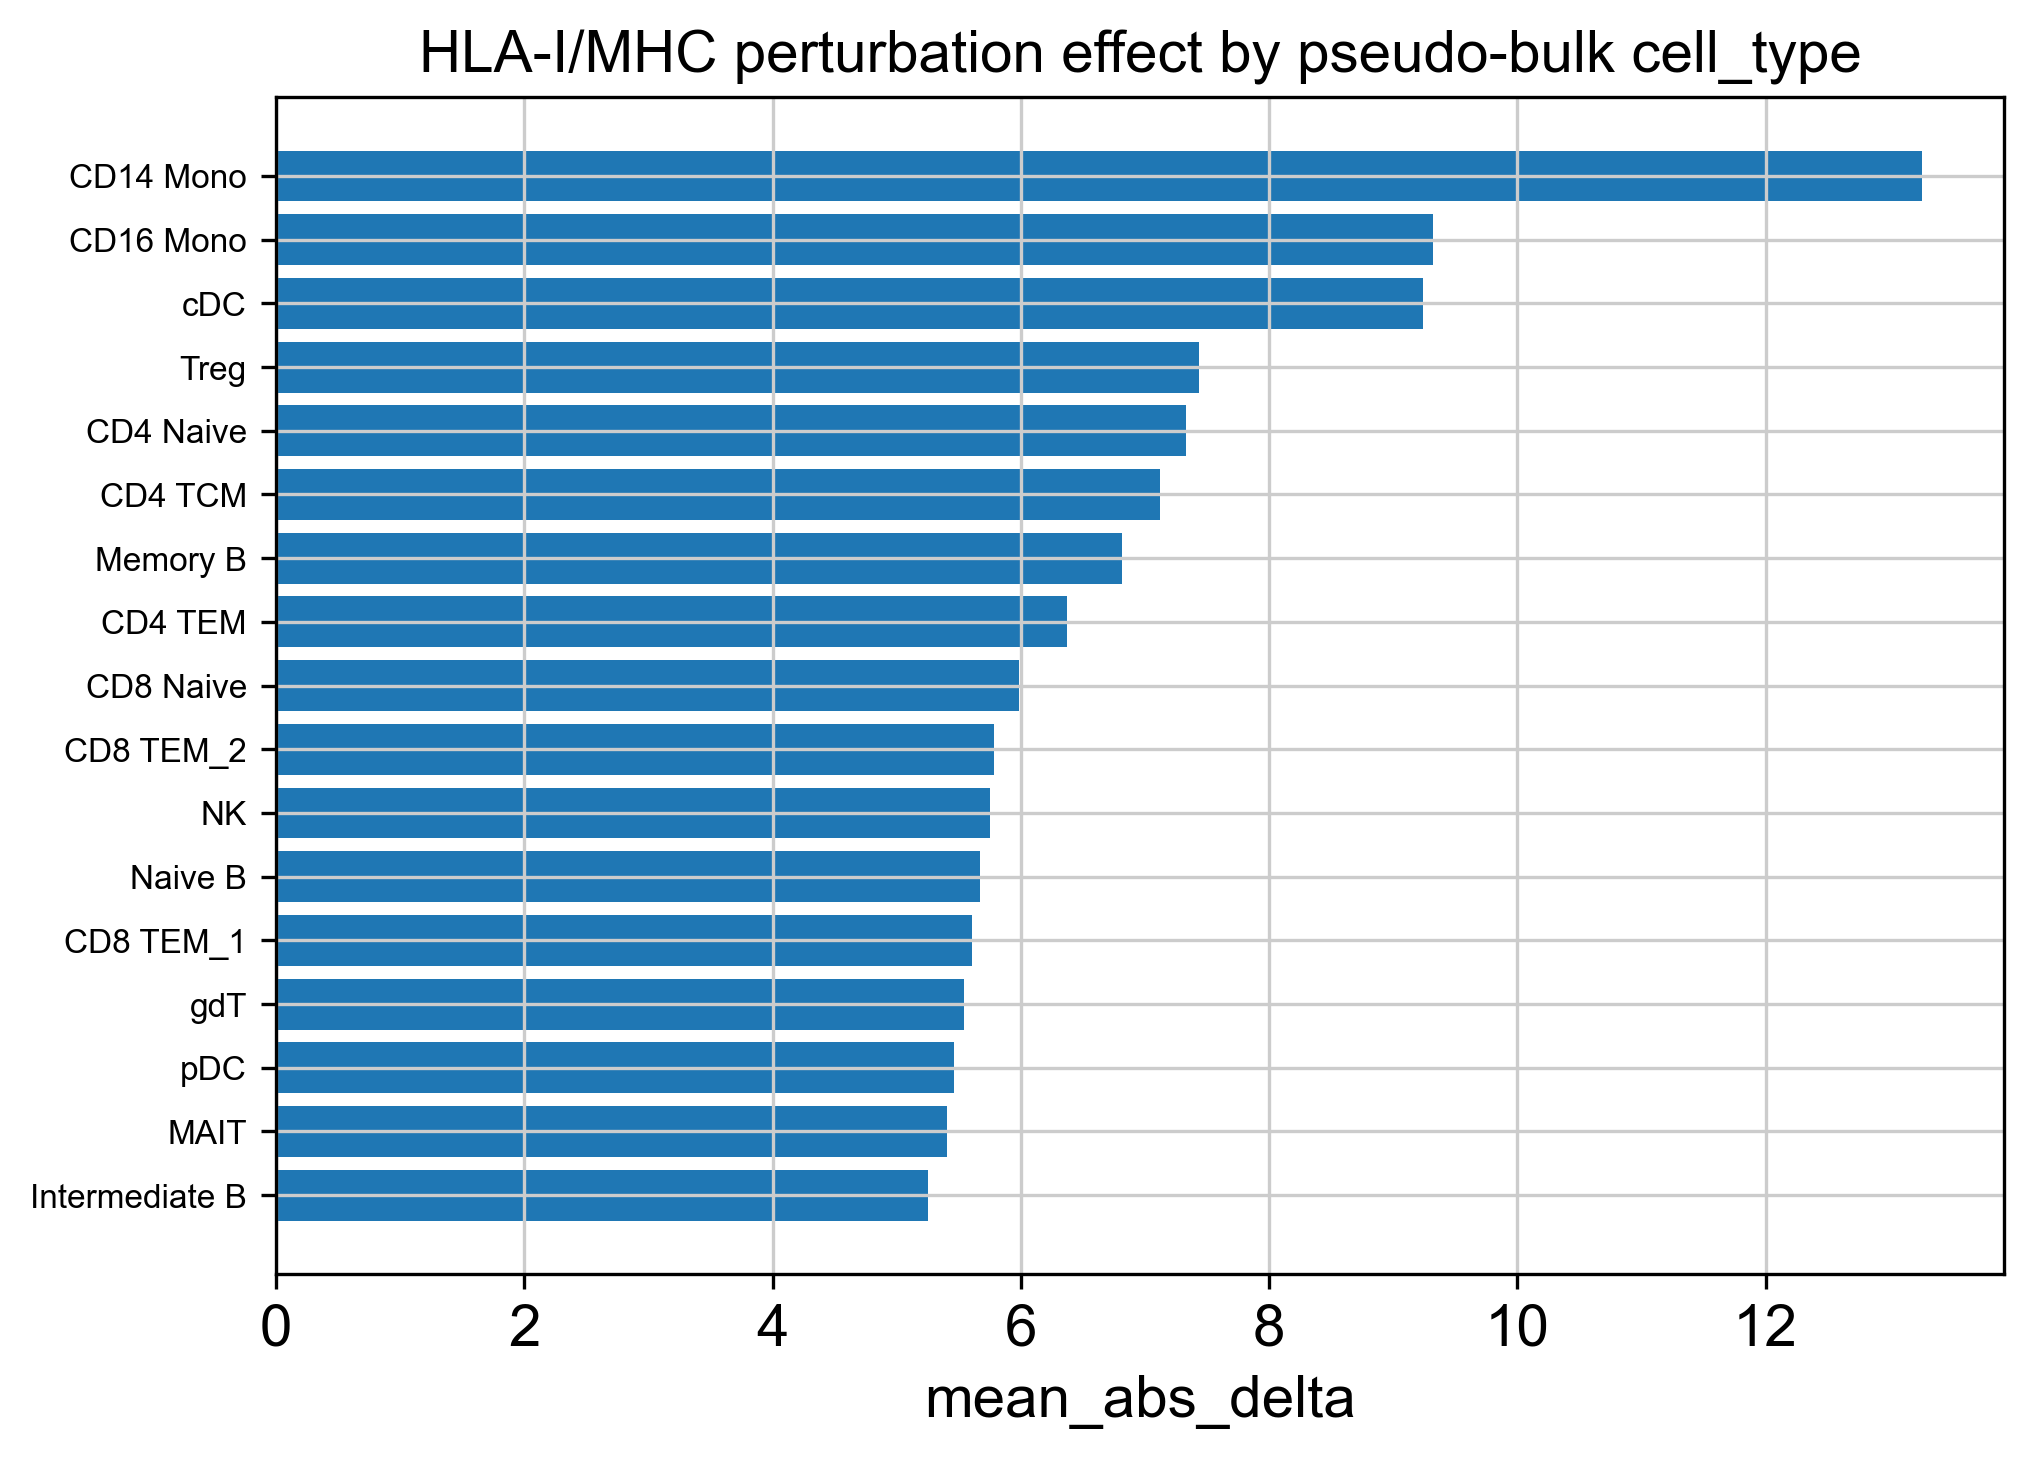

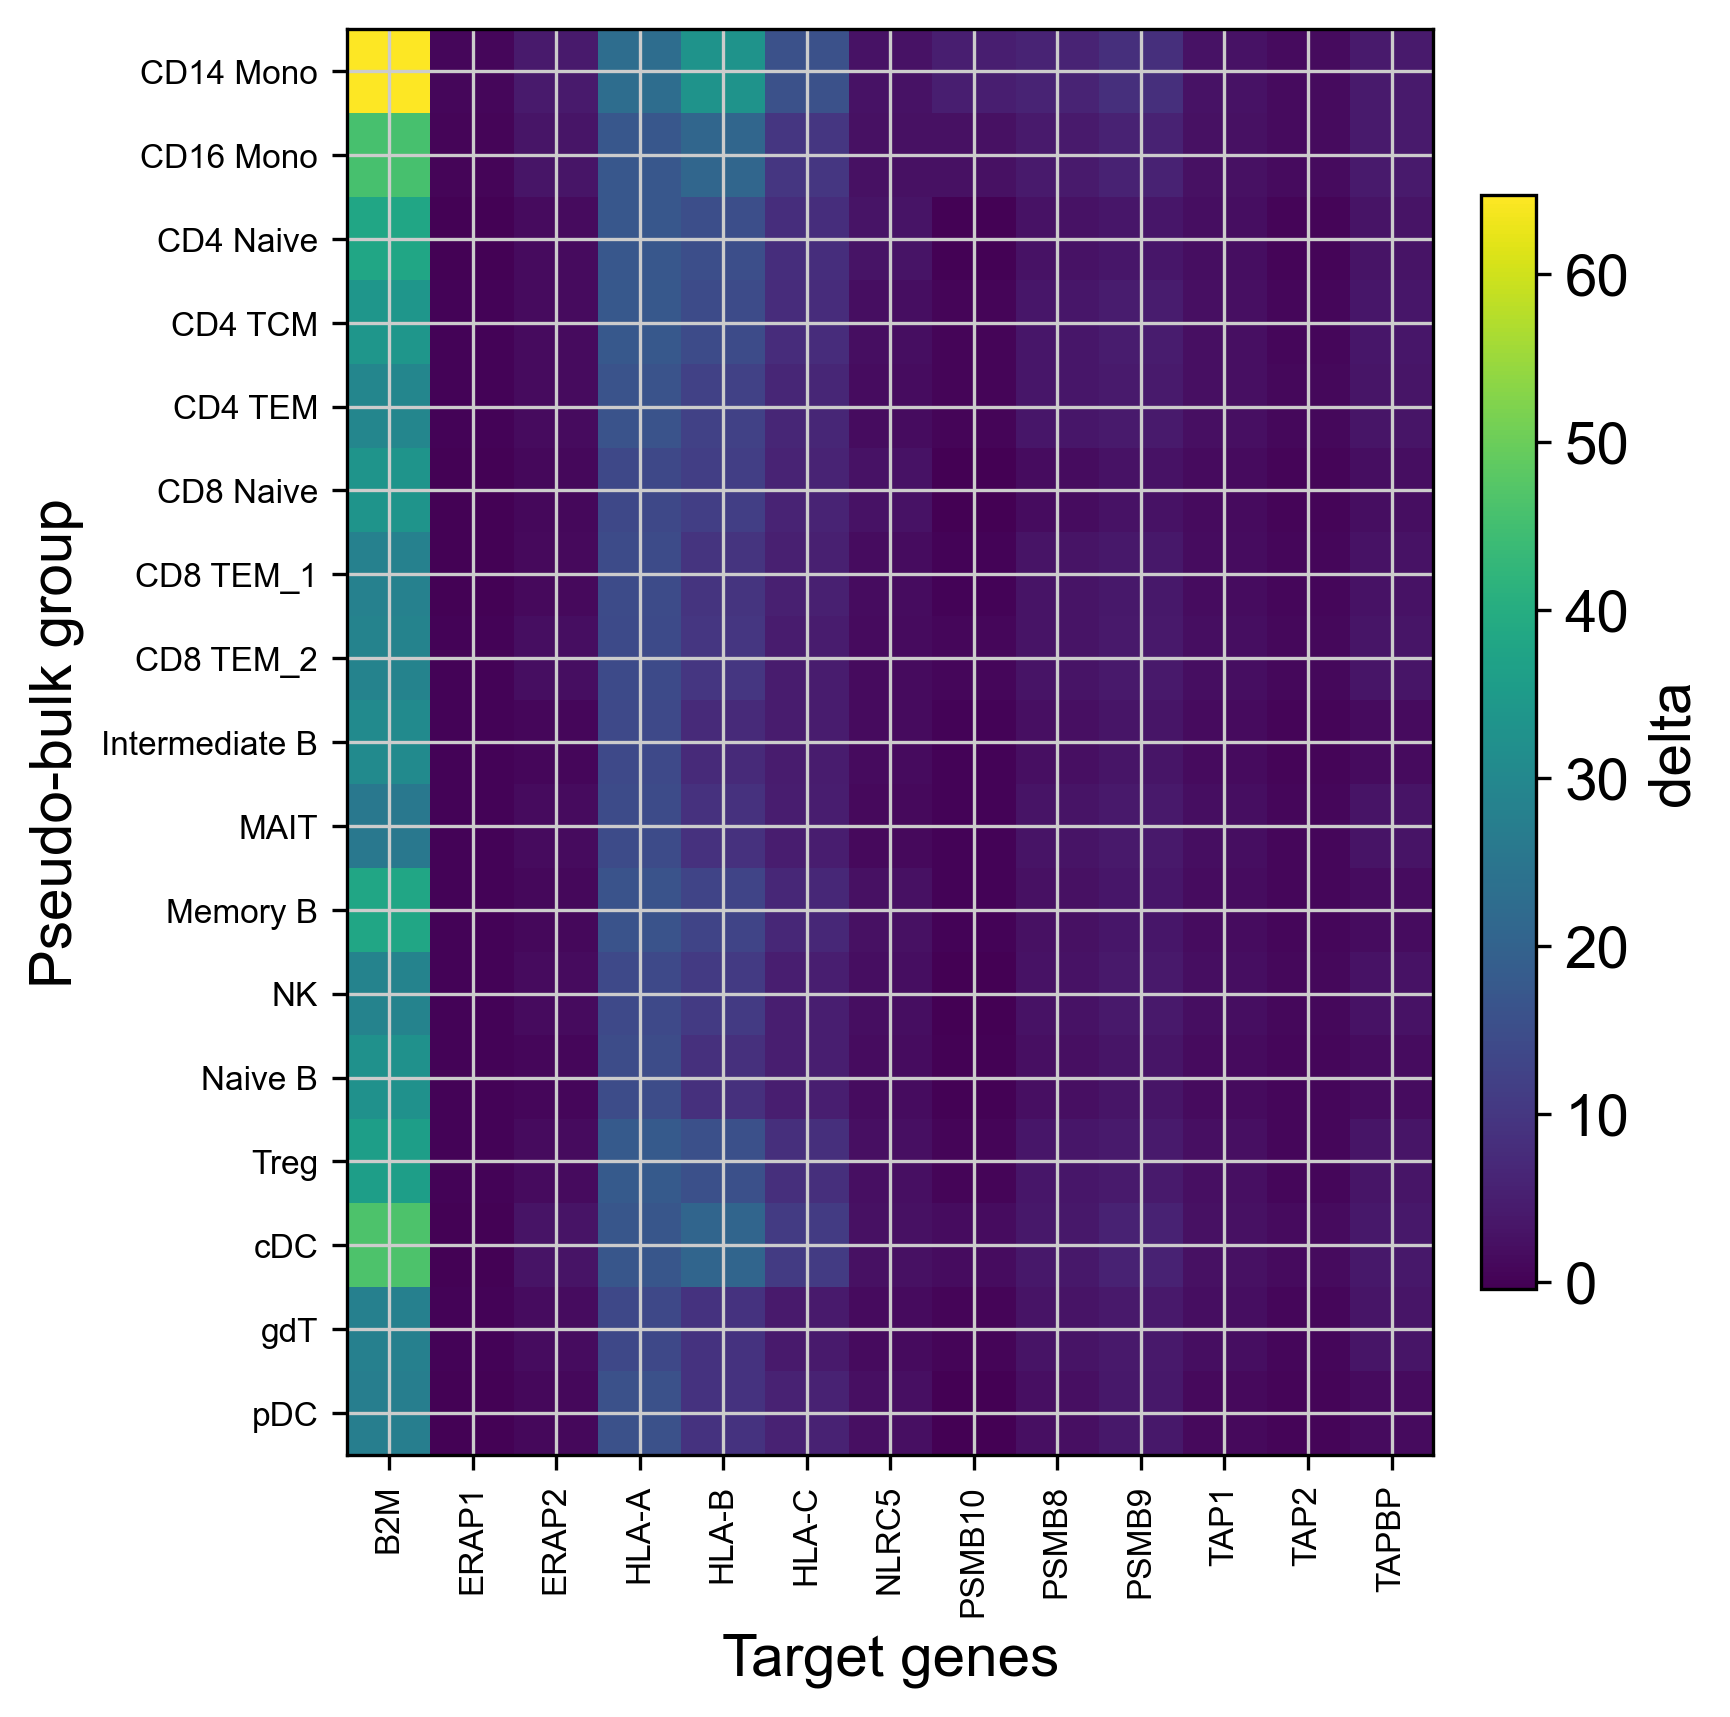

In [463]:
plot_group_scores(
    hla_on["group_scores"],
    metric="mean_abs_delta",
    title="HLA-I/MHC perturbation effect by pseudo-bulk cell_type"
)

plot_group_target_heatmap(
    hla_on["group_target_gene_deltas"],
    value_col="delta"
)


In [464]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

def _to_dense1(x):
    if sp.issparse(x):
        return x.toarray().ravel()
    return np.asarray(x).ravel()

def _get_X(adata, layer=None):
    if layer is None or layer == "X":
        return adata.X
    return adata.layers[layer]

def build_locus_peak_plot_df(
    perturb_out: dict,
    atac_ref: ad.AnnData,
    *,
    region=("chr6", 28_000_000, 34_000_000),
    group: str = None,          # pseudo-bulk group name (e.g. "T cell"), or None = average across groups
    groupby: str = "cell_type", # only used for labels
    peak_chrom_col: str = "chrom",
    peak_start_col: str = "chromStart",
    peak_end_col: str = "chromEnd",
):
    """
    Build peak-level plotting table for a genomic locus from run_complex_perturbation_pseudobulk() output.
    Uses pseudo-bulk ATAC before/after perturbation stored in perturb_out["result"].
    """
    chrom, reg_start, reg_end = region

    # Pseudobulk ATAC before/after from the perturbation result
    base_atac_pb = perturb_out["result"]["base_atac"]   # AnnData, groups x peaks
    pert_atac_pb = perturb_out["result"]["pert_atac"]   # AnnData, groups x peaks
    target_peak_idx = set(np.asarray(perturb_out["peak_idx"], dtype=int).tolist())

    # Coordinates from original ATAC var (same features/order expected)
    v = atac_ref.var.copy()
    pchr = v[peak_chrom_col].astype(str).values
    pst = v[peak_start_col].astype(int).values
    pen = v[peak_end_col].astype(int).values
    pnames = atac_ref.var_names.astype(str).values

    # Region mask
    m_reg = (pchr == str(chrom)) & (pen >= int(reg_start)) & (pst <= int(reg_end))
    peak_idx_reg = np.where(m_reg)[0]
    if peak_idx_reg.size == 0:
        raise ValueError(f"No peaks overlap region {region}")

    # Group selection in pseudobulk rows
    if group is None:
        row_idx = None
        base_vec = _to_dense1(base_atac_pb.X[:, peak_idx_reg].mean(axis=0))
        pert_vec = _to_dense1(pert_atac_pb.X[:, peak_idx_reg].mean(axis=0))
        group_label = "ALL_PSEUDOBULK_GROUPS_MEAN"
    else:
        pb_groups = base_atac_pb.obs_names.astype(str).tolist()
        if str(group) not in pb_groups:
            raise KeyError(f"group '{group}' not found in pseudobulk groups: {pb_groups}")
        row_idx = pb_groups.index(str(group))
        base_vec = _to_dense1(base_atac_pb.X[row_idx, peak_idx_reg])
        pert_vec = _to_dense1(pert_atac_pb.X[row_idx, peak_idx_reg])
        group_label = str(group)

    mid = ((pst[peak_idx_reg] + pen[peak_idx_reg]) / 2.0).astype(float)

    df = pd.DataFrame({
        "peak_idx": peak_idx_reg.astype(int),
        "peak_name": pnames[peak_idx_reg],
        "chrom": pchr[peak_idx_reg],
        "start": pst[peak_idx_reg].astype(int),
        "end": pen[peak_idx_reg].astype(int),
        "mid": mid,
        "width": (pen[peak_idx_reg] - pst[peak_idx_reg]).astype(int),
        "atac_base": np.asarray(base_vec, dtype=float),
        "atac_pert": np.asarray(pert_vec, dtype=float),
    })
    df["atac_delta"] = df["atac_pert"] - df["atac_base"]
    df["targeted"] = df["peak_idx"].isin(target_peak_idx)

    # Optional: attach link metadata if available
    if "selection" in perturb_out and "links" in perturb_out["selection"] and perturb_out["selection"]["links"] is not None:
        links = perturb_out["selection"]["links"].copy()
        if not links.empty:
            agg = (
                links.groupby("peak_idx")
                .agg(
                    linked_genes=("gene_name", lambda x: ",".join(sorted(set(map(str, x))))),
                    link_types=("link_type", lambda x: ",".join(sorted(set(map(str, x))))),
                    n_links=("gene_name", "size"),
                )
                .reset_index()
            )
            df = df.merge(agg, on="peak_idx", how="left")
        else:
            df["linked_genes"] = None
            df["link_types"] = None
            df["n_links"] = 0

    df = df.sort_values(["start", "end"]).reset_index(drop=True)
    df.attrs["region"] = region
    df.attrs["group"] = group_label
    return df


In [465]:
def plot_locus_peaks_along_genome(
    locus_df: pd.DataFrame,
    *,
    mode: str = "delta",   # "delta", "base_pert", "stacked"
    title: str = None,
    show_targeted: bool = True,
    label_top_n: int = 0,  # label top |delta| peaks
    figsize=(14, 4),
):
    """
    Plot peak-level ATAC signal across a locus.
    x-axis = genomic midpoint
    """
    df = locus_df.copy()
    region = locus_df.attrs.get("region", None)
    group_label = locus_df.attrs.get("group", "group")

    x = df["mid"].values
    widths = np.maximum(df["width"].values, 1)

    if title is None:
        if region is not None:
            chrom, st, en = region
            title = f"{group_label} | {chrom}:{st:,}-{en:,}"
        else:
            title = f"{group_label} locus"

    if mode == "delta":
        y = df["atac_delta"].values
        plt.figure(figsize=figsize)
        # all peaks
        plt.vlines(x, 0, y, linewidth=1)
        # emphasize targeted
        if show_targeted and "targeted" in df.columns:
            dt = df[df["targeted"]]
            if not dt.empty:
                plt.vlines(dt["mid"].values, 0, dt["atac_delta"].values, linewidth=2)
                plt.scatter(dt["mid"].values, dt["atac_delta"].values, s=15)
        plt.axhline(0, linewidth=1)
        plt.xlabel("Genomic position")
        plt.ylabel("ΔATAC (pert - base)")
        plt.title(title + " | peak delta")
        plt.tight_layout()
        plt.show()

    elif mode == "base_pert":
        plt.figure(figsize=figsize)
        plt.plot(x, df["atac_base"].values, marker="o", linestyle="-", markersize=2, linewidth=1, label="base")
        plt.plot(x, df["atac_pert"].values, marker="o", linestyle="-", markersize=2, linewidth=1, label="pert")
        if show_targeted and "targeted" in df.columns:
            dt = df[df["targeted"]]
            if not dt.empty:
                ymax = float(np.nanmax(np.r_[df["atac_base"].values, df["atac_pert"].values]))
                for xm in dt["mid"].values:
                    plt.axvline(xm, linewidth=0.5, alpha=0.4)
        plt.xlabel("Genomic position")
        plt.ylabel("ATAC signal")
        plt.title(title + " | baseline vs perturbed")
        plt.legend()
        plt.tight_layout()
        plt.show()

    elif mode == "stacked":
        fig, ax = plt.subplots(2, 1, figsize=(figsize[0], figsize[1] * 1.8), sharex=True)
        ax[0].plot(x, df["atac_base"].values, marker="o", linestyle="-", markersize=2, linewidth=1, label="base")
        ax[0].plot(x, df["atac_pert"].values, marker="o", linestyle="-", markersize=2, linewidth=1, label="pert")
        ax[0].set_ylabel("ATAC")
        ax[0].legend()
        ax[0].set_title(title)

        ax[1].vlines(x, 0, df["atac_delta"].values, linewidth=1)
        if show_targeted and "targeted" in df.columns:
            dt = df[df["targeted"]]
            if not dt.empty:
                ax[1].vlines(dt["mid"].values, 0, dt["atac_delta"].values, linewidth=2)
                ax[1].scatter(dt["mid"].values, dt["atac_delta"].values, s=12)
        ax[1].axhline(0, linewidth=1)
        ax[1].set_ylabel("ΔATAC")
        ax[1].set_xlabel("Genomic position")
        plt.tight_layout()
        plt.show()

    else:
        raise ValueError("mode must be one of {'delta','base_pert','stacked'}")

    # Optional labels for top peaks
    if label_top_n > 0:
        dfl = df.reindex(df["atac_delta"].abs().sort_values(ascending=False).index).head(label_top_n)
        print(dfl[["peak_name", "start", "end", "atac_base", "atac_pert", "atac_delta", "targeted", "linked_genes"]]
              if "linked_genes" in dfl.columns else
              dfl[["peak_name", "start", "end", "atac_base", "atac_pert", "atac_delta", "targeted"]])


In [470]:
def plot_locus_with_genes(
    locus_df: pd.DataFrame,
    rna: ad.AnnData,
    *,
    region=None,
    target_genes: list = None,      # optional: highlight these
    value_col: str = "atac_delta",  # "atac_delta", "atac_base", "atac_pert"
    figsize=(14, 6),
    max_gene_labels: int = 40,
):
    """
    Two-panel plot:
      top: peak signal along locus
      bottom: simple gene models/TSS markers from rna.var annotation
    Requires rna.var columns: chrom, start, end, strand, gene_name, tss
    """
    df = locus_df.copy()
    if region is None:
        region = locus_df.attrs.get("region", None)
    if region is None:
        raise ValueError("region not provided and not found in locus_df.attrs['region']")
    chrom, reg_start, reg_end = region

    # Select genes in region
    rv = rna.var.copy()
    needed = ["chrom", "start", "end", "strand", "gene_name", "tss"]
    for c in needed:
        if c not in rv.columns:
            raise KeyError(f"rna.var missing '{c}' (needed for gene track plotting)")

    gm = (
        rv["chrom"].astype(str).eq(str(chrom))
        & rv["start"].notna() & rv["end"].notna() & rv["tss"].notna()
        & (rv["end"].astype(float) >= reg_start)
        & (rv["start"].astype(float) <= reg_end)
    )
    gdf = rv.loc[gm, ["chrom", "start", "end", "strand", "gene_name", "tss"]].copy()
    gdf["start"] = gdf["start"].astype(int)
    gdf["end"] = gdf["end"].astype(int)
    gdf["tss"] = gdf["tss"].astype(int)
    gdf["gene_name"] = gdf["gene_name"].astype(str)

    # Dedup by gene_name for plotting cleanliness
    gdf = gdf.drop_duplicates(subset=["gene_name"]).sort_values(["start", "end"]).reset_index(drop=True)

    # Simple row packing to reduce label overlap
    rows_end = []
    gene_rows = []
    for _, row in gdf.iterrows():
        placed = False
        for ridx in range(len(rows_end)):
            if row["start"] > rows_end[ridx]:
                gene_rows.append(ridx)
                rows_end[ridx] = row["end"]
                placed = True
                break
        if not placed:
            rows_end.append(row["end"])
            gene_rows.append(len(rows_end) - 1)
    gdf["track_row"] = gene_rows

    # target highlight
    target_set = set([str(x) for x in target_genes]) if target_genes is not None else set()
    gdf["is_target_gene"] = gdf["gene_name"].isin(target_set)

    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=figsize, sharex=True,
        gridspec_kw={"height_ratios": [2.2, 1.2]}
    )

    # --- top panel: peak values ---
    x = df["mid"].values
    y = df[value_col].values
    ax1.vlines(x, 0, y, linewidth=1)
    if "targeted" in df.columns:
        dt = df[df["targeted"]]
        if not dt.empty:
            ax1.vlines(dt["mid"].values, 0, dt[value_col].values, linewidth=2)
            ax1.scatter(dt["mid"].values, dt[value_col].values, s=10)
    if value_col == "atac_delta":
        ax1.axhline(0, linewidth=1)
    ax1.set_ylabel(value_col)
    reg_label = f"{chrom}:{reg_start:,}-{reg_end:,}"
    group_label = locus_df.attrs.get("group", "group")
    ax1.set_title(f"{group_label} | {reg_label}")

    # --- bottom panel: gene track ---
    nrows = max(1, (gdf["track_row"].max() + 1) if not gdf.empty else 1)
    for _, row in gdf.iterrows():
        y0 = nrows - 1 - row["track_row"]  # invert so first row on top
        # gene body
        ax2.hlines(y0, row["start"], row["end"], linewidth=2)
        # TSS marker
        ax2.vlines(row["tss"], y0 - 0.2, y0 + 0.2, linewidth=1.5)

        # strand arrow cue (very simple)
        if row["strand"] == "+":
            ax2.annotate("", xy=(row["end"], y0), xytext=(max(row["start"], row["end"] - (reg_end-reg_start)*0.01), y0),
                         arrowprops=dict(arrowstyle="->", lw=1))
        elif row["strand"] == "-":
            ax2.annotate("", xy=(row["start"], y0), xytext=(min(row["end"], row["start"] + (reg_end-reg_start)*0.01), y0),
                         arrowprops=dict(arrowstyle="->", lw=1))

    # label genes (all or subset if too many)
    if not gdf.empty:
        if len(gdf) > max_gene_labels and len(target_set) > 0:
            label_df = gdf[gdf["is_target_gene"]].copy()
        else:
            label_df = gdf.copy()

        for _, row in label_df.iterrows():
            y0 = nrows - 1 - row["track_row"]
            txt = row["gene_name"]
            ax2.text(row["tss"], y0 + 0.28, txt, fontsize=8, rotation=45, ha="left", va="bottom")

    ax2.set_ylim(-0.8, nrows - 0.2)
    ax2.set_yticks([])
    ax2.set_xlabel("Genomic position")
    ax2.set_ylabel("Genes")
    plt.tight_layout()
    plt.show()


In [471]:
'''
# GZMB (not present)
region=("chr14", 24_800_000, 25_500_000)
# PRF1
region=("chr10", 70_200_000, 70_800_000)
# NKG7
region=("chr19", 51_300_000, 51_700_000)
# GNLY
region=("chr2", 85_500_000, 86_200_000)
'''

#region=("chr2", 85_500_000, 86_200_000)
#region=("chr10", 70_200_000, 70_800_000)
#region=("chr10", 68_000_000, 72_000_000)
region = ("chr6", 29_000_000, 33_500_000)


In [472]:
# Inspect available pseudobulk groups
print(hla_on["atac_pseudobulk"].obs_names.tolist())

# Pick one
#group_to_plot = "NK"
#group_to_plot = "CD8 TEM_1"
group_to_plot = "CD14 Mono"

locus_df = build_locus_peak_plot_df(
    perturb_out=hla_on,
    atac_ref=atac,
    #region=("chr6", 28_000_000, 34_000_000),
    #region=("chr15", 44_700_000, 45_100_000),
    region=region,
    group=group_to_plot,
    groupby="cell_type",
)

display(locus_df.head())


['CD14 Mono', 'CD16 Mono', 'CD4 Naive', 'CD4 TCM', 'CD4 TEM', 'CD8 Naive', 'CD8 TEM_1', 'CD8 TEM_2', 'Intermediate B', 'MAIT', 'Memory B', 'NK', 'Naive B', 'Treg', 'cDC', 'gdT', 'pDC']


peak_idx               peak_name chrom     start       end         mid  \
0     85473  chr6:29005150-29005951  chr6  29005150  29005951  29005550.5   
1     85474  chr6:29011072-29011924  chr6  29011072  29011924  29011498.0   
2     85475  chr6:29014761-29017536  chr6  29014761  29017536  29016148.5   
3     85476  chr6:29552475-29554199  chr6  29552475  29554199  29553337.0   
4     85477  chr6:29589415-29589854  chr6  29589415  29589854  29589634.5   

   width  atac_base  atac_pert  atac_delta  targeted linked_genes link_types  \
0    801   0.066406   0.066406         0.0     False          NaN        NaN   
1    852   0.050781   0.050781         0.0     False          NaN        NaN   
2   2775   0.093750   0.093750         0.0     False          NaN        NaN   
3   1724   0.238281   0.238281         0.0     False          NaN        NaN   
4    439   0.031250   0.031250         0.0     False          NaN        NaN   

   n_links  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

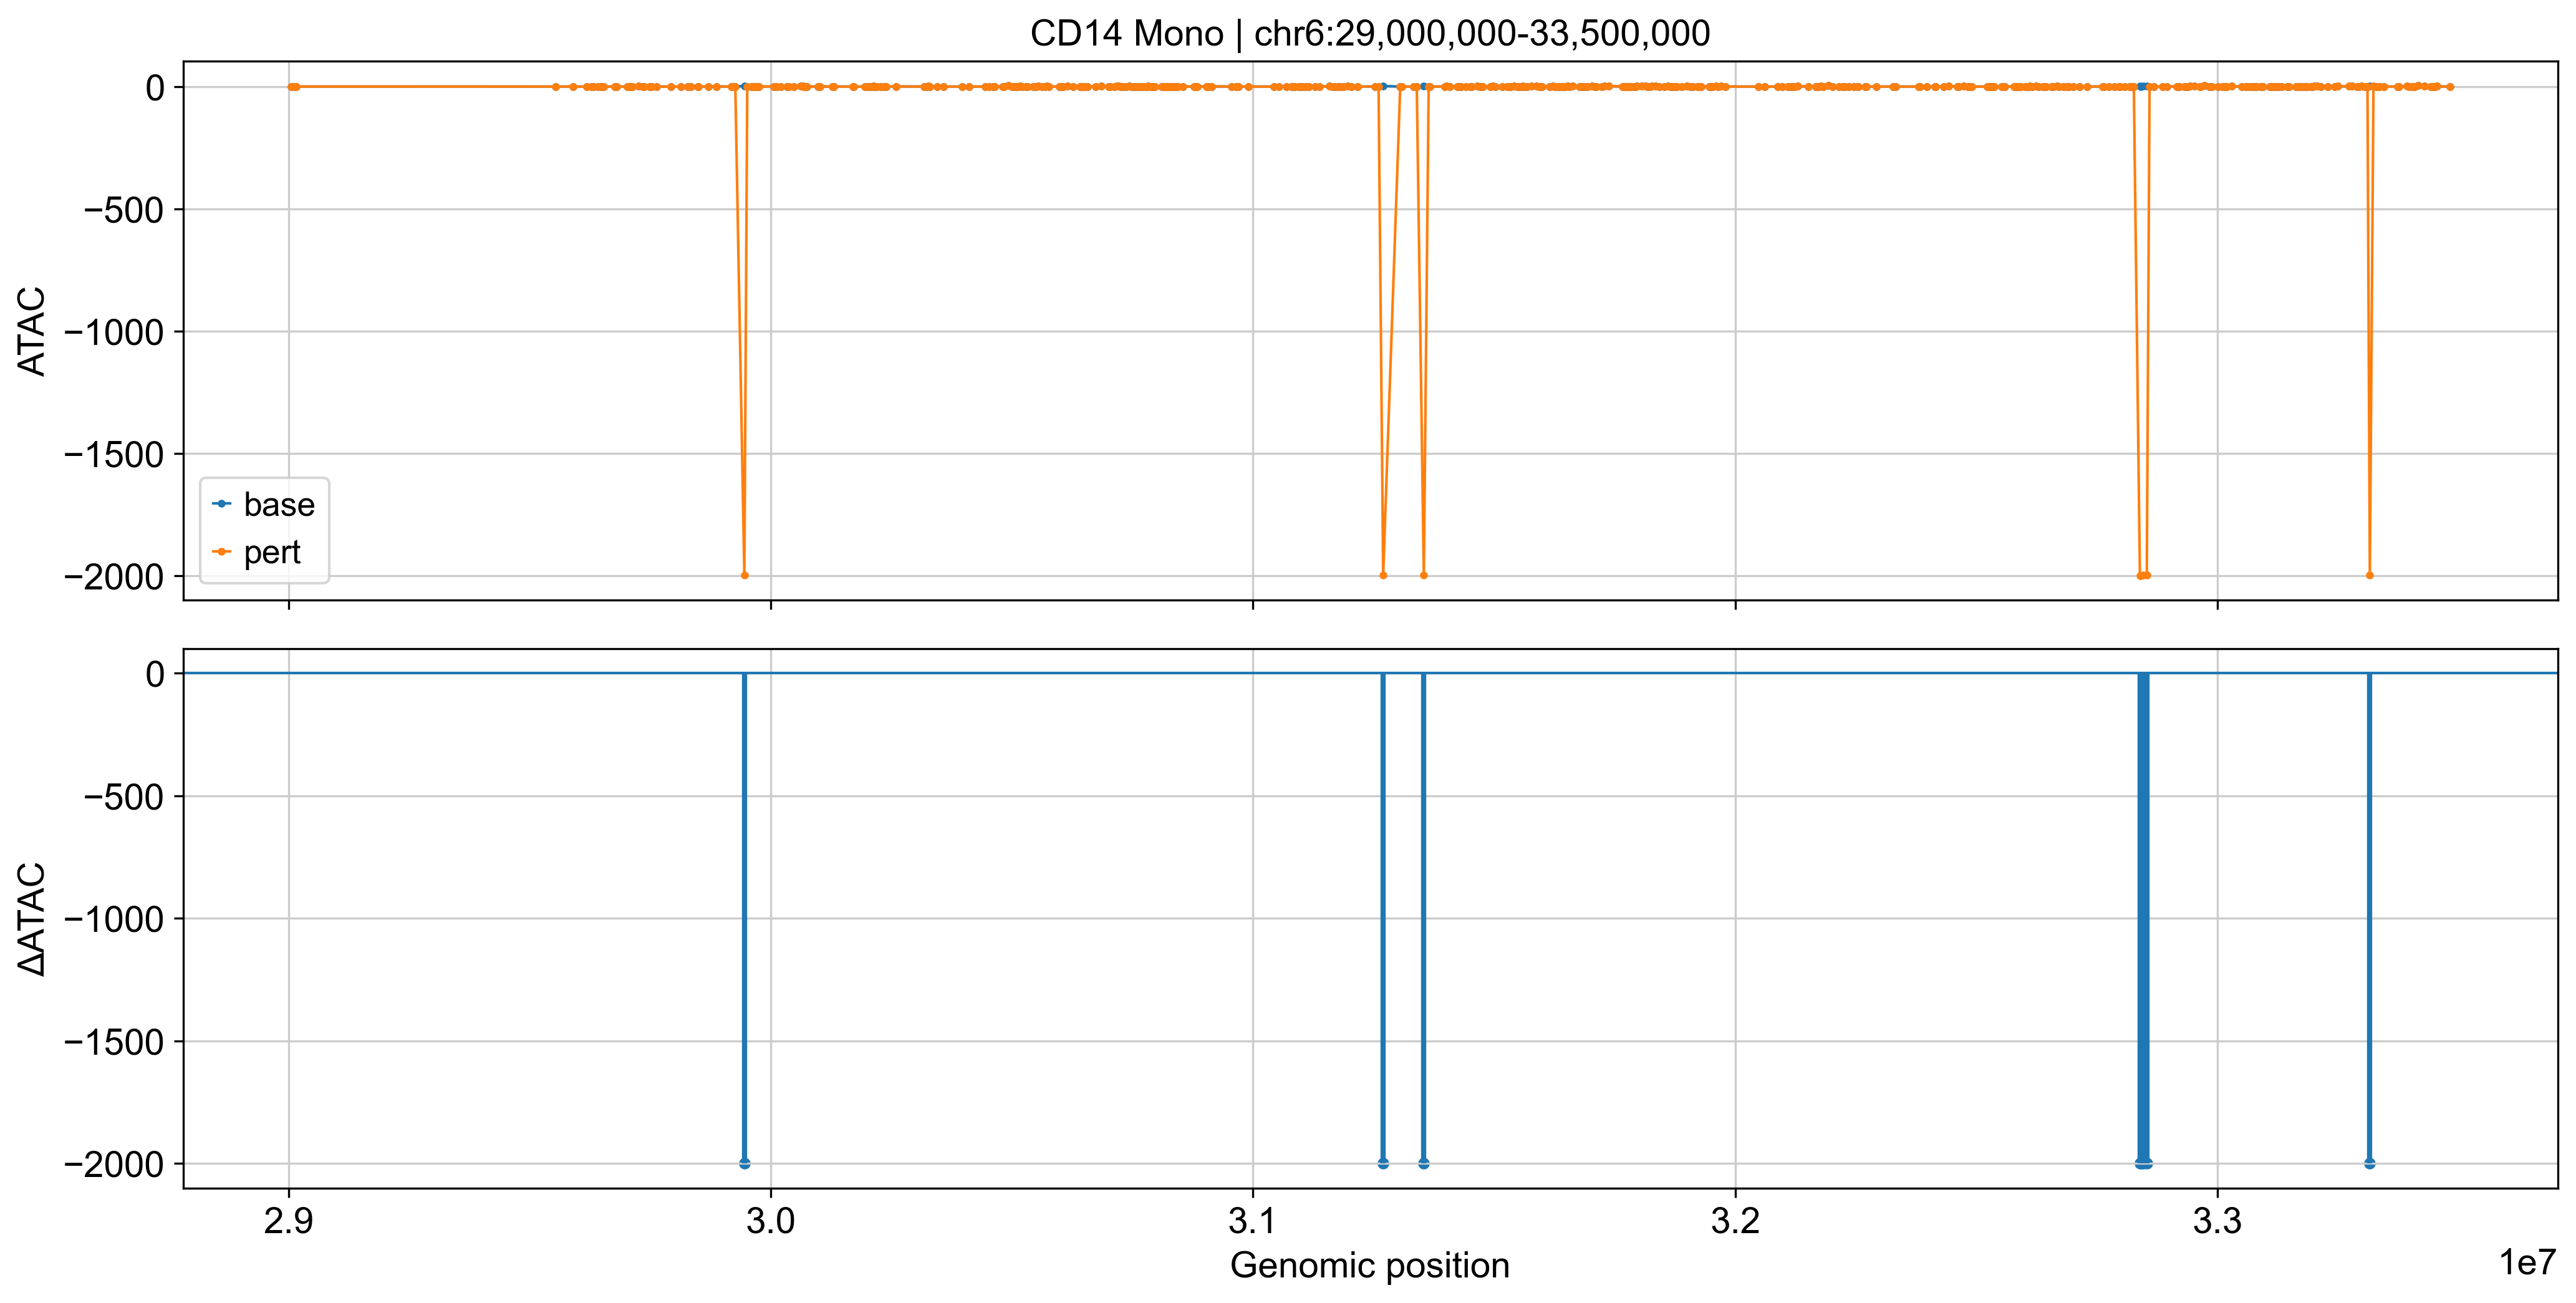

                  peak_name     start       end  atac_base    atac_pert  \
392  chr6:32840346-32841486  32840346  32841486   0.019531 -1999.980469   
192  chr6:31264951-31274513  31264951  31274513   2.433594 -1997.566406   
391  chr6:32837532-32839814  32837532  32839814   1.093750 -1998.906250   
38   chr6:29940122-29950467  29940122  29950467   2.613281 -1997.386719   
462  chr6:33311855-33318903  33311855  33318903   2.769531 -1997.230469   
393  chr6:32842530-32849218  32842530  32849218   1.855469 -1998.144531   
197  chr6:31348494-31359535  31348494  31359535   2.812500 -1997.187500   
394  chr6:32849879-32856058  32849879  32856058   2.054688 -1997.945312   
313  chr6:32180888-32184572  32180888  32184572   0.230469     0.230469   
324  chr6:32254625-32256114  32254625  32256114   0.195312     0.195312   
307  chr6:32147622-32155725  32147622  32155725   0.742188     0.742188   
331  chr6:32382863-32382968  32382863  32382968   0.003906     0.003906   
330  chr6:32379566-323799

In [473]:
plot_locus_peaks_along_genome(
    locus_df,
    mode="stacked",     # try "delta", "base_pert", "stacked"
    #mode="base_pert",
    #mode="delta",
    label_top_n=20
)


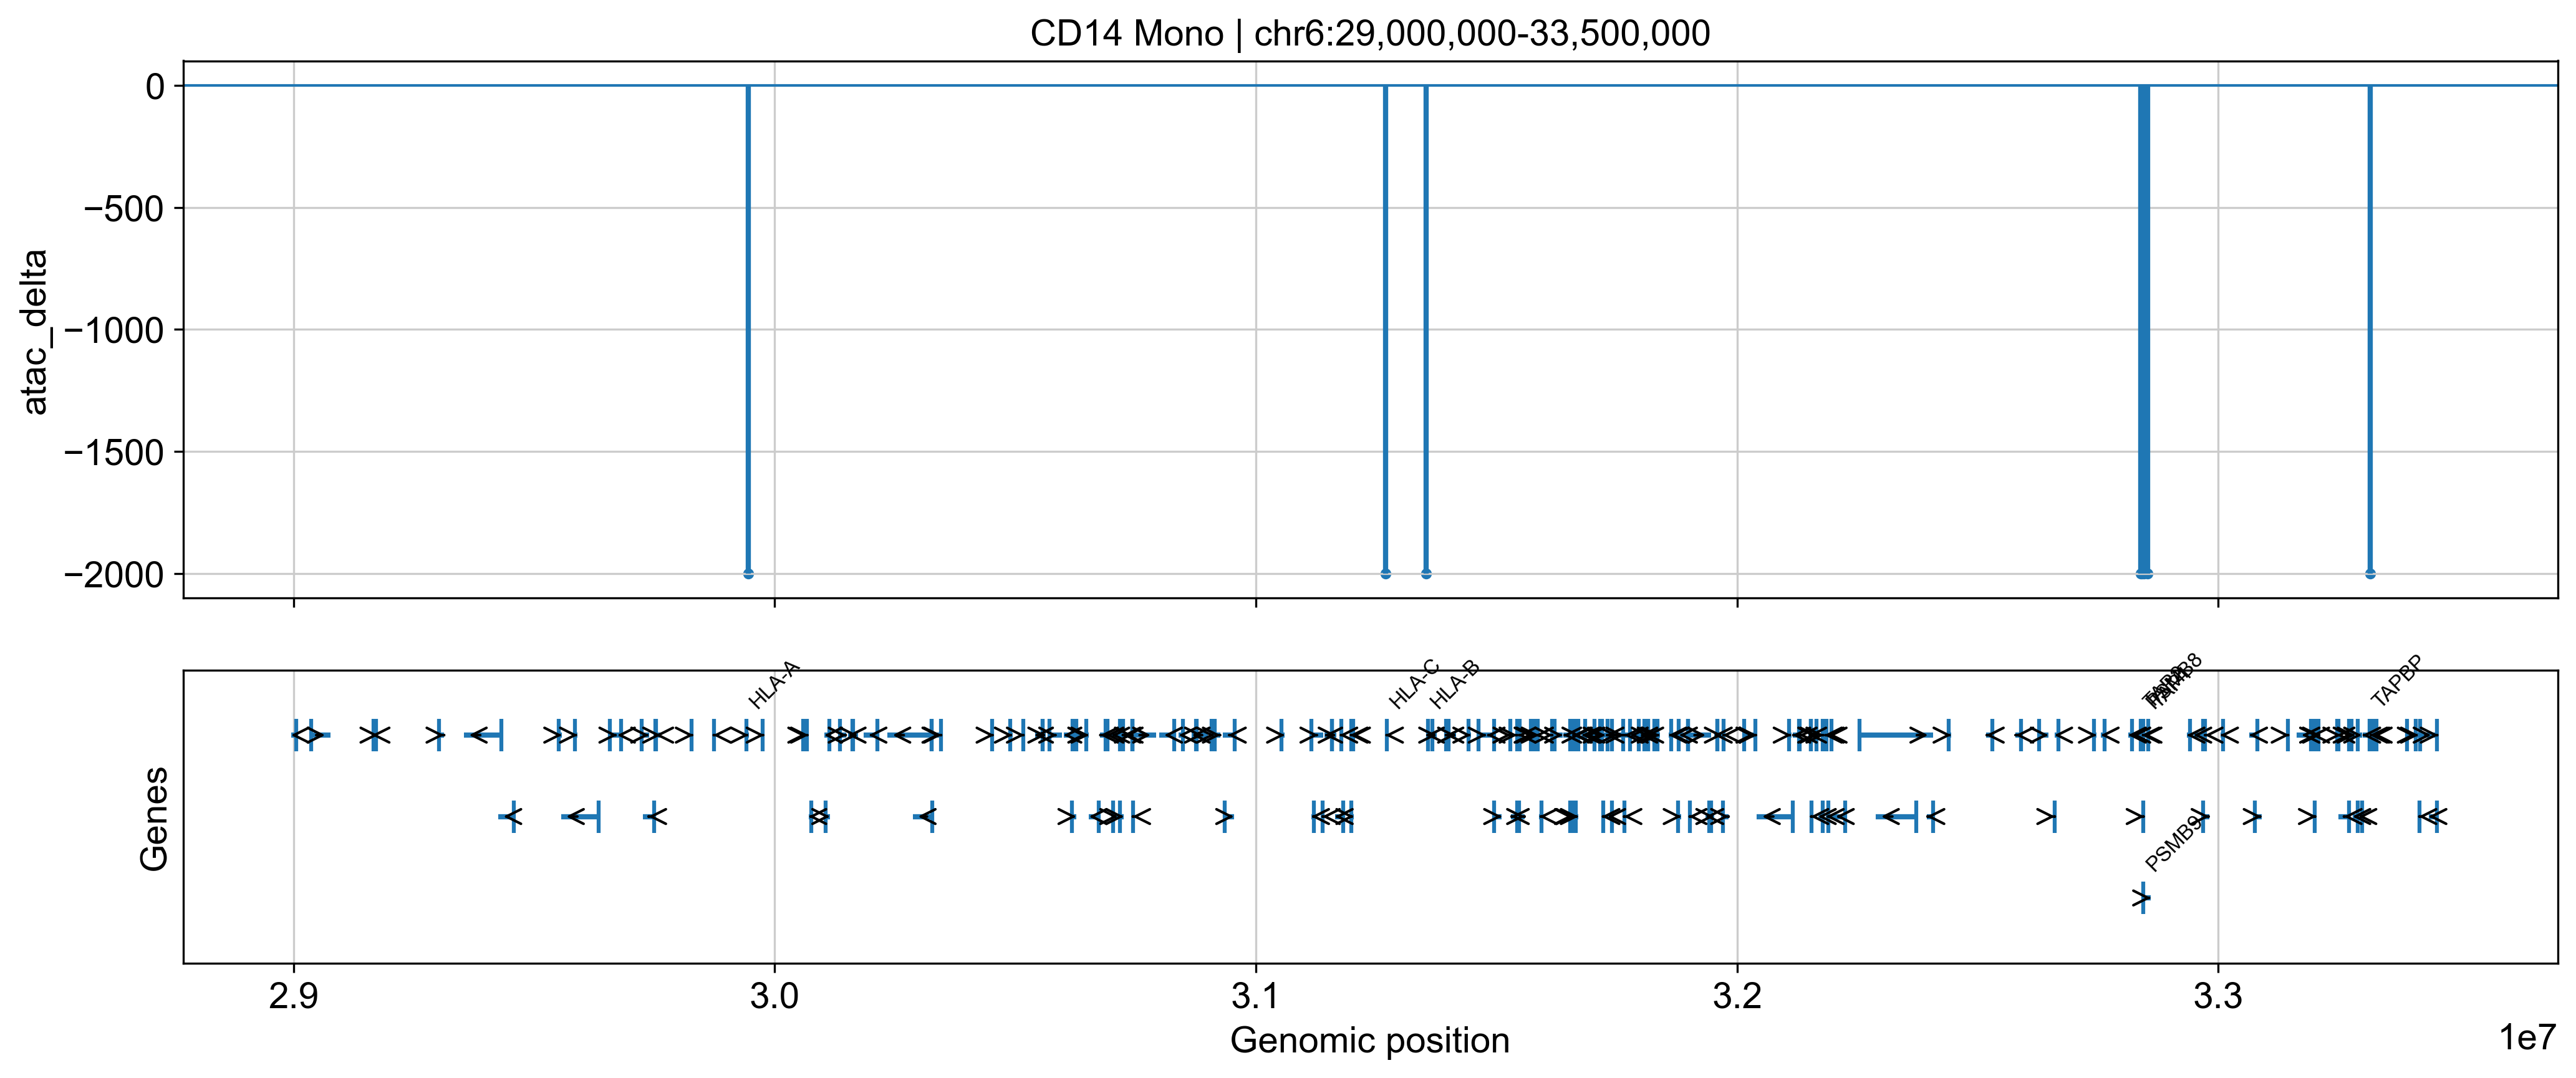

In [474]:
plot_locus_with_genes(
    locus_df,
    rna=rna,  # or rna_only if you made an RNA-only object with GTF coords
    #region=("chr6", 28_000_000, 34_000_000),
    #region=("chr15", 44_700_000, 45_100_000),    
    #region=("chr14", 24_800_000, 25_500_000),
    region=region,
    target_genes=hla_on["target_genes"],   # highlights HLA-related genes
    value_col="atac_delta",                 # or "atac_base"
)


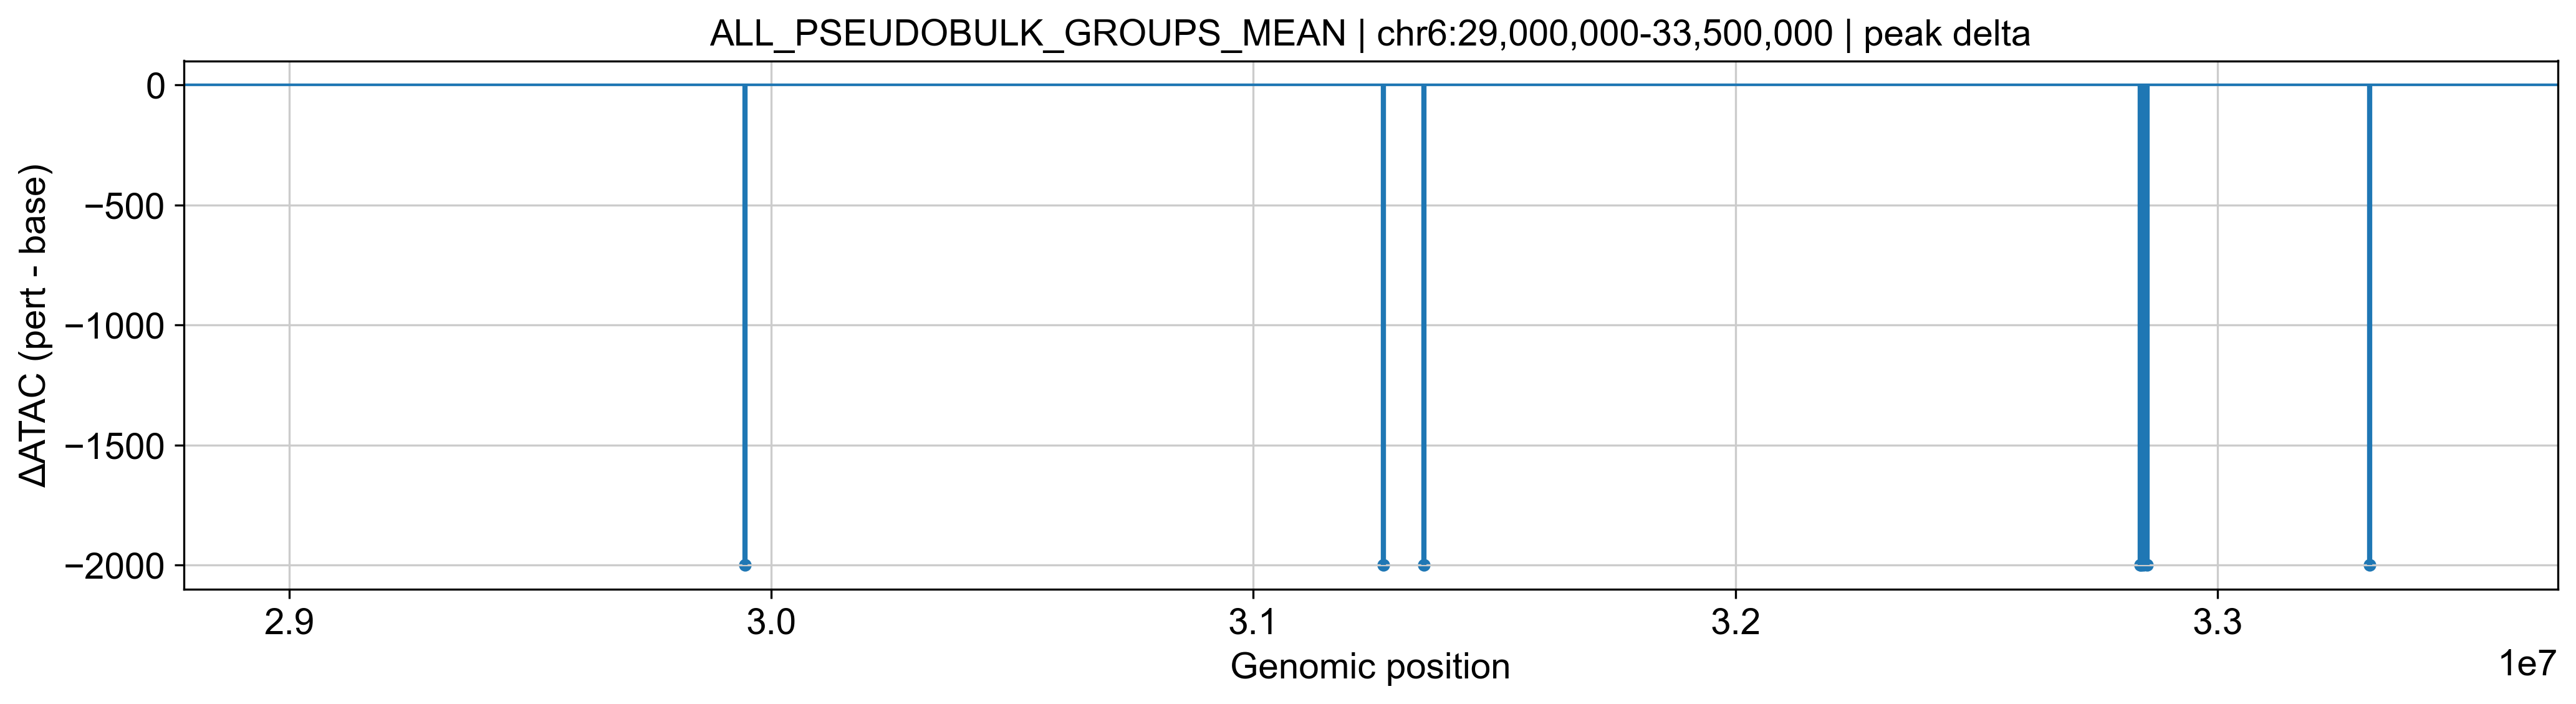

                  peak_name     start       end  atac_base    atac_pert  \
391  chr6:32837532-32839814  32837532  32839814   0.824083 -1999.176025   
393  chr6:32842530-32849218  32842530  32849218   2.024585 -1997.975464   
197  chr6:31348494-31359535  31348494  31359535   2.700306 -1997.299683   
394  chr6:32849879-32856058  32849879  32856058   2.005707 -1997.994263   
192  chr6:31264951-31274513  31264951  31274513   2.249946 -1997.750000   
462  chr6:33311855-33318903  33311855  33318903   2.926702 -1997.073242   
38   chr6:29940122-29950467  29940122  29950467   2.284580 -1997.715332   
392  chr6:32840346-32841486  32840346  32841486   0.068289 -1999.931519   
313  chr6:32180888-32184572  32180888  32184572   0.153736     0.153736   
324  chr6:32254625-32256114  32254625  32256114   0.161883     0.161883   
307  chr6:32147622-32155725  32147622  32155725   1.185897     1.185897   
331  chr6:32382863-32382968  32382863  32382968   0.014445     0.014445   
330  chr6:32379566-323799

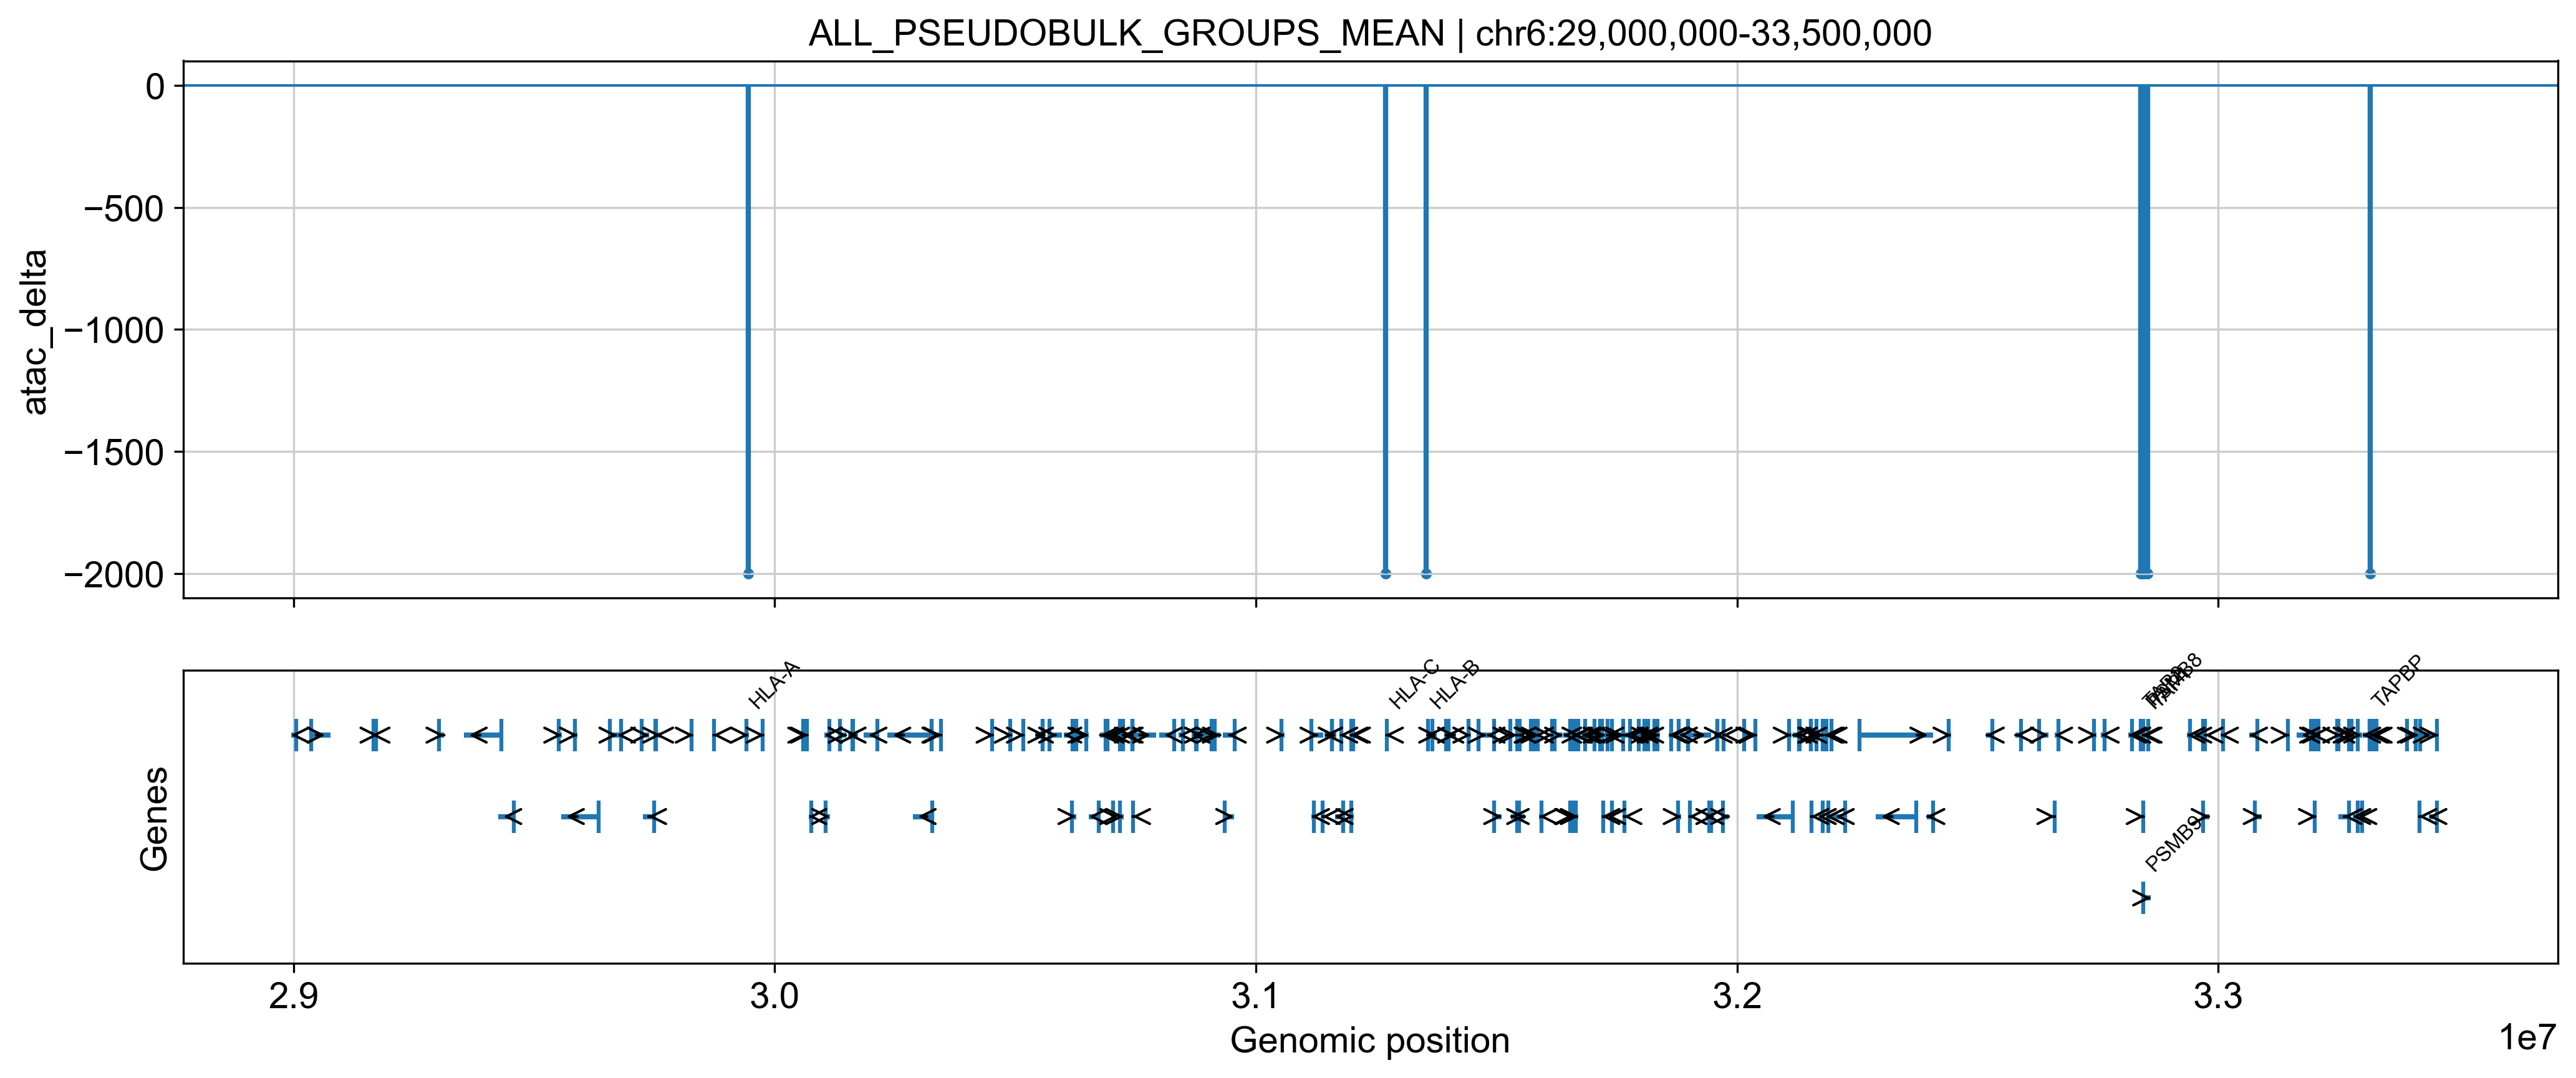

In [475]:
locus_df_all = build_locus_peak_plot_df(
    perturb_out=hla_on,
    atac_ref=atac,
    #region=("chr6", 28_000_000, 34_000_000),
    #region=("chr15", 44_700_000, 45_100_000),  
    #region=("chr14", 24_800_000, 25_500_000),
    region=region,
    group=None,  # average across pseudobulk groups
)

plot_locus_peaks_along_genome(locus_df_all, mode="delta", label_top_n=15)
plot_locus_with_genes(
    locus_df_all,
    rna=rna,
    #region=("chr6", 28_000_000, 34_000_000),
    #region=("chr15", 44_700_000, 45_100_000),  
    #region=("chr14", 24_800_000, 25_500_000),
    region=region,
    target_genes=hla_on["target_genes"],
    value_col="atac_delta",
)


In [476]:
def plot_rna_delta_genes_in_locus(
    perturb_out: dict,
    rna_plot: ad.AnnData,
    *,
    region=("chr6", 28_000_000, 34_000_000),
    top_n=None,
    match_target_genes_only=False,
    figsize=(12, 4),
):
    """
    Plot gene-level predicted RNA delta (mean across pseudobulk groups) for genes in locus.
    Uses perturb_out["delta_all_genes"] from run_complex_perturbation_pseudobulk().
    """
    chrom, reg_start, reg_end = region
    dfg = perturb_out["delta_all_genes"].copy()
    rv = rna_plot.var.copy()

    for c in ["chrom", "start", "end", "gene_name"]:
        if c not in rv.columns:
            raise KeyError(f"rna.var missing '{c}' for locus RNA plotting")

    ann = rv[["chrom", "start", "end", "gene_name"]].copy()
    ann["gene_var_name"] = ann.index.astype(str)

    # Merge on gene_var_name
    dfg2 = dfg.merge(ann.reset_index().rename(columns={"index": "gene_var_name"}),
                     on="gene_var_name", how="left", suffixes=("", "_ann"))

    m = (
        dfg2["chrom"].astype(str).eq(str(chrom))
        & dfg2["start"].notna() & dfg2["end"].notna()
        & (dfg2["end"].astype(float) >= reg_start)
        & (dfg2["start"].astype(float) <= reg_end)
    )
    dfl = dfg2.loc[m].copy()
    if match_target_genes_only and "target_genes" in perturb_out:
        tgt = set(map(str, perturb_out["target_genes"]))
        dfl = dfl[dfl["gene_name"].astype(str).isin(tgt)].copy()

    if dfl.empty:
        print("No RNA genes found in region.")
        return

    dfl["mid"] = (dfl["start"].astype(float) + dfl["end"].astype(float)) / 2.0
    dfl = dfl.sort_values("mid")

    if top_n is not None and len(dfl) > top_n:
        dfl = dfl.reindex(dfl["mean_delta_abs"].sort_values(ascending=False).index).head(top_n).sort_values("mid")

    plt.figure(figsize=figsize)
    plt.vlines(dfl["mid"].values, 0, dfl["mean_delta"].values, linewidth=1.5)
    plt.scatter(dfl["mid"].values, dfl["mean_delta"].values, s=18)
    plt.axhline(0, linewidth=1)
    for _, r in dfl.iterrows():
        plt.text(r["mid"], r["mean_delta"], str(r["gene_name"]), fontsize=8, rotation=45, ha="left", va="bottom")
    plt.xlabel("Genomic position")
    plt.ylabel("Mean predicted RNA Δ")
    plt.title(f"RNA delta in locus {chrom}:{reg_start:,}-{reg_end:,}")
    plt.tight_layout()
    plt.show()


In [477]:
print(hla_on)


{'selection': {'peak_idx': array([85511, 85665, 85670, 85864, 85865, 85866, 85867, 85935]), 'links':   peak_idx               peak_name gene_idx gene_var_name          gene_id  \
0    85511  chr6:29940122-29950467     9289         HLA-A  ENSG00000206503   
1    85665  chr6:31264951-31274513     9344         HLA-C  ENSG00000204525   
2    85670  chr6:31348494-31359535     9345         HLA-B  ENSG00000234745   
3    85864  chr6:32837532-32839814     9430          TAP2  ENSG00000204267   
4    85865  chr6:32840346-32841486     9430          TAP2  ENSG00000204267   
5    85866  chr6:32842530-32849218     9431         PSMB8  ENSG00000204264   
6    85866  chr6:32842530-32849218     9433         PSMB9  ENSG00000240065   
7    85867  chr6:32849879-32856058     9434          TAP1  ENSG00000168394   
8    85935  chr6:33311855-33318903     9456         TAPBP  ENSG00000231925   

  gene_name chrom link_type distance_to_tss  weight  
0     HLA-A  chr6  promoter            4034     1.0  
1     HLA-

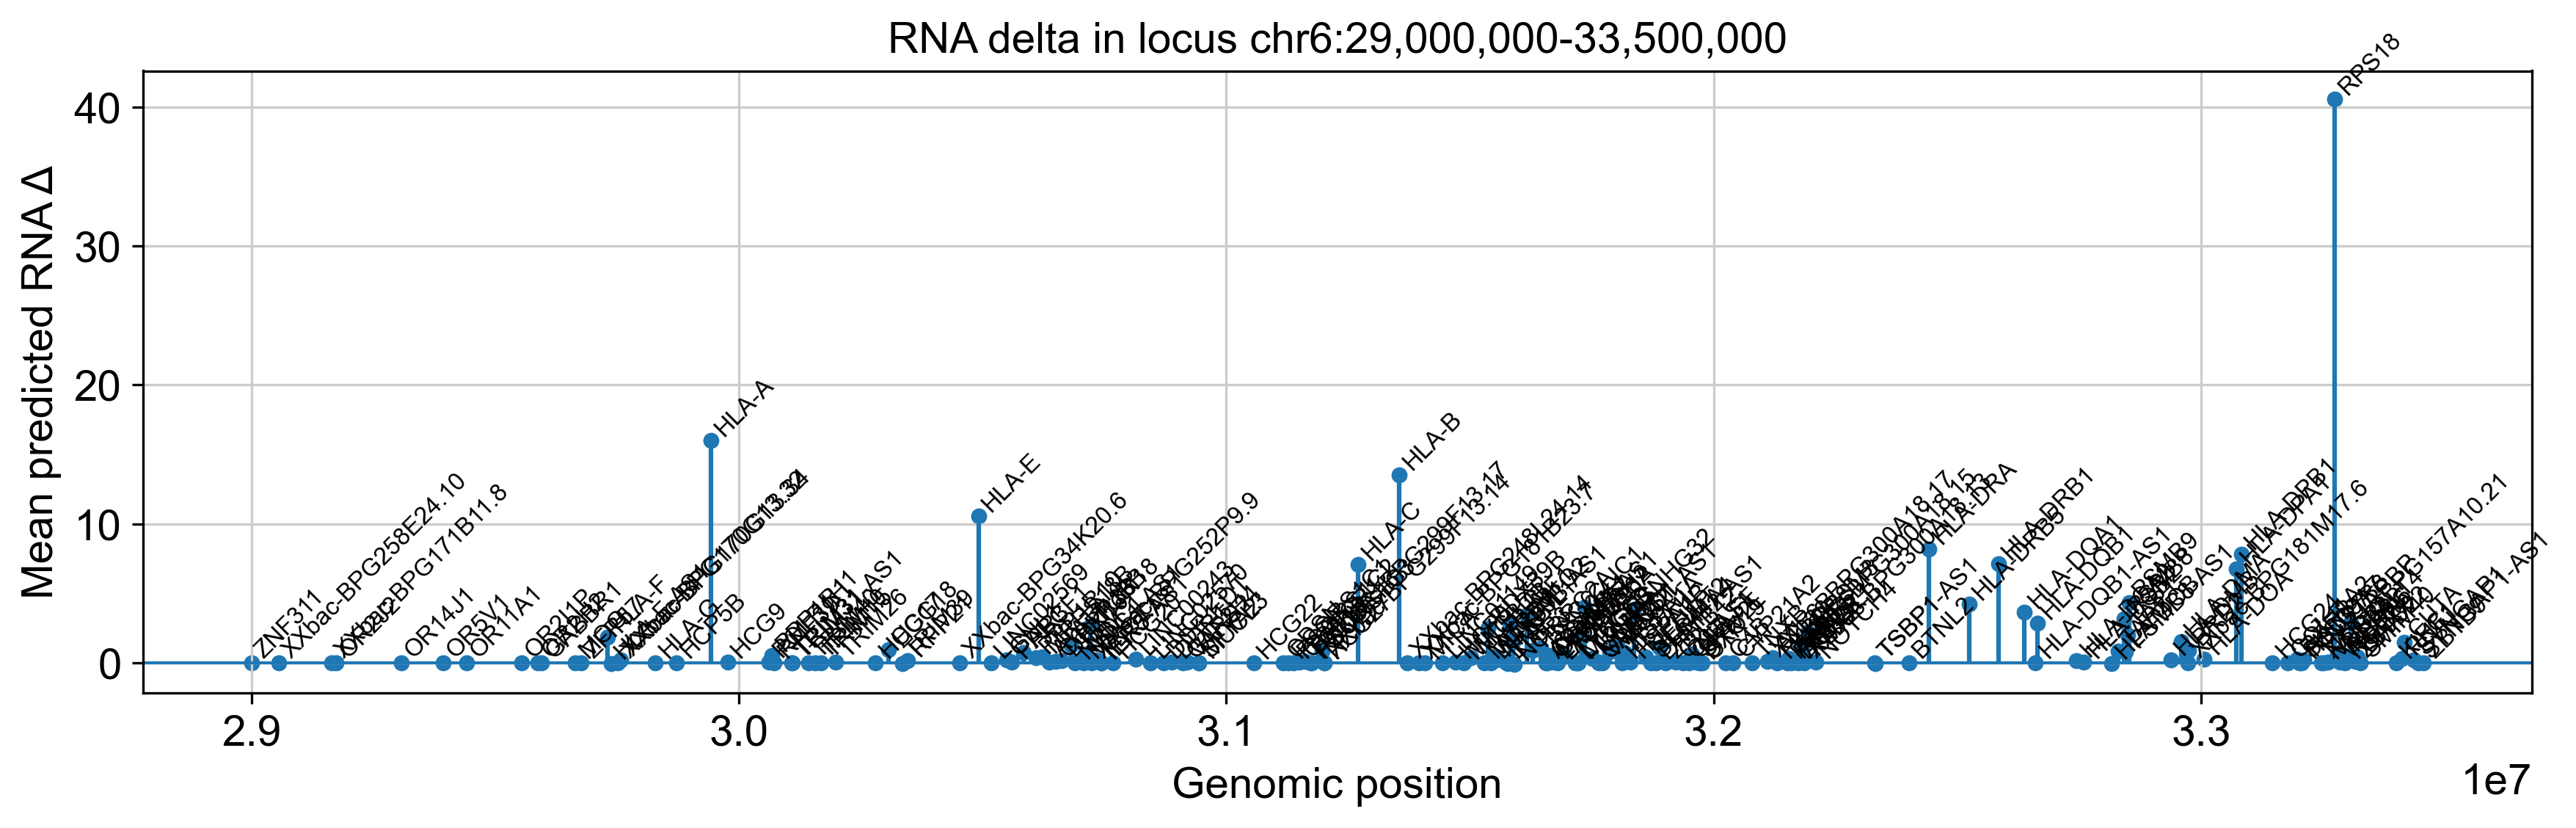

In [478]:
plot_rna_delta_genes_in_locus(
    hla_on,
    rna_plot=hla_on["rna_pseudobulk"],   # pseudobulk RNA with same var annotation
    #region=("chr6", 28_000_000, 34_000_000),
    #region=("chr15", 44_700_000, 45_100_000), 
    #region=("chr14", 24_800_000, 25_500_000),
    region=region,
    #region = ("chr2", 1, 300_000_000),
    match_target_genes_only=False
)


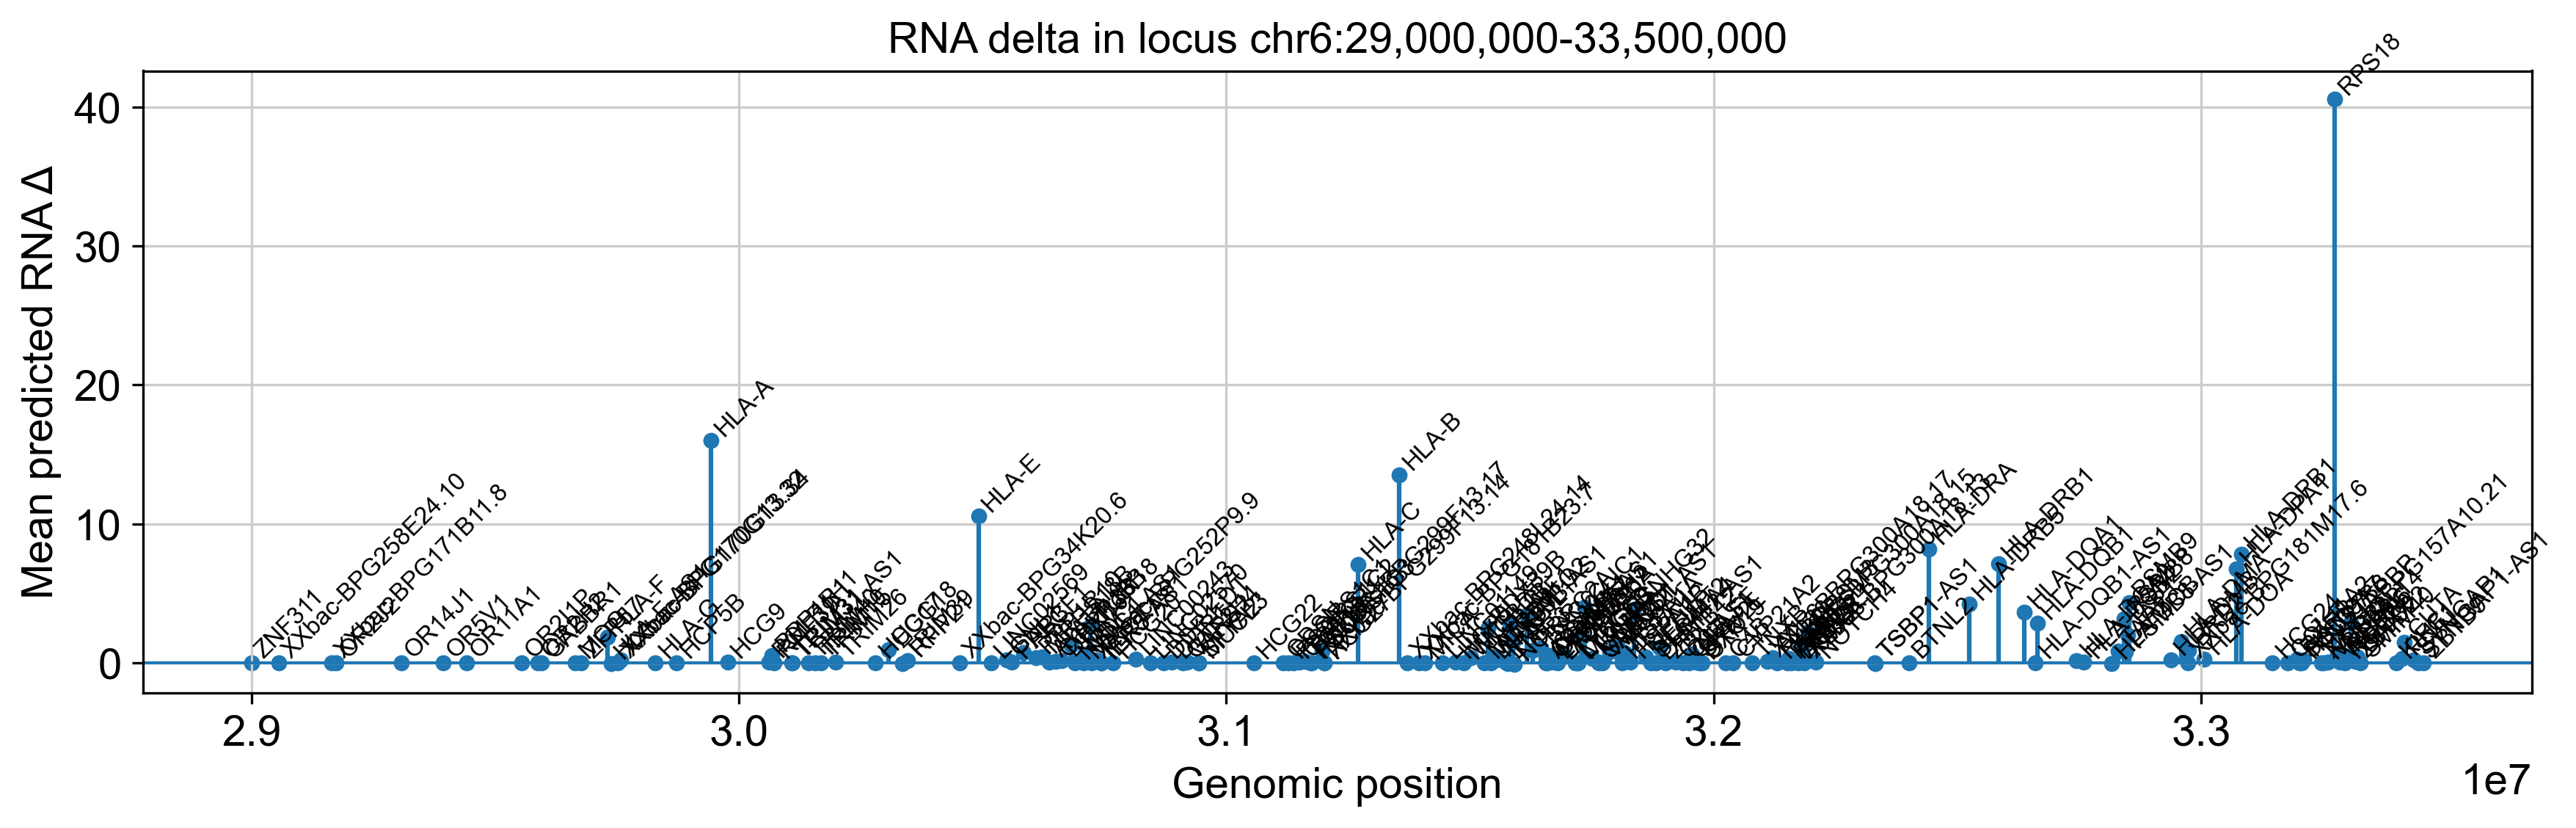

In [479]:
plot_rna_delta_genes_in_locus(
    hla_on,
    rna_plot=hla_on["rna_pseudobulk"],   # pseudobulk RNA with same var annotation
    #region=("chr6", 28_000_000, 34_000_000),
    #region=("chr15", 44_700_000, 45_100_000), 
    #region=("chr14", 24_800_000, 25_500_000),
    region=region,
    #region = ("chr2", 1, 300_000_000),
    match_target_genes_only=False
)


In [480]:
hla_logit_shift = run_complex_perturbation_pseudobulk(
    model=model,
    atac=atac,
    rna=rna,
    peak_gene_links=peak_gene_links,
    #complex_name_or_genes="hla_class_i_antigen_processing_core",
    #complex_name_or_genes=["B2M"],
    complex_name_or_genes="cytotoxic_effector_extended",
    groupby="cell_type",
    atac_input_layer="imputed_from_rna",    # logits/transformed-like
    pseudobulk_agg="mean",
    mode="add",                             # <- not on/off
    value=50.0,                             # add to logits/transformed values
    clip_min=None,
    clip_max=None,
    strict_input_semantics=True,            # safe because mode='add'
    verbose=True,
    device=device,
)


[INFO] Pseudobulk groups retained: 17
[INFO] ATAC pseudobulk source layer: imputed_from_rna
[INFO] ATAC input semantics: transformed_or_logit_like
[INFO] ATAC value range: 0.0002014 .. 2.889
[INFO] Selected target peaks: 15
[INFO] Target-peak baseline summary (pre-perturb): min=0.001134, max=2.222, mean=0.3256
[INFO] Target-peak mean ΔATAC (pert-base): 50.000000
[INFO] delta_pred == pred_pert - pred_base ? True


In [481]:
import numpy as np
import scipy.sparse as sp

# 1) Confirm only 0/1 in bin layer
'''
Xb = atac_bin.layers["bin"]
if sp.issparse(Xb):
    print("unique nonzero values:", np.unique(Xb.data))
    print("min/max nonzero:", Xb.data.min(), Xb.data.max())
else:
    print("unique values:", np.unique(Xb))

# 2) Confirm sparsity pattern preserved vs counts
Xc = atac_raw.layers["counts"] if "counts" in atac_raw.layers else atac_raw.X
if sp.issparse(Xc) and sp.issparse(Xb):
    same_pattern = (Xc.indptr.shape == Xb.indptr.shape and
                    np.array_equal(Xc.indptr, Xb.indptr) and
                    np.array_equal(Xc.indices, Xb.indices))
    print("same sparse pattern:", same_pattern)

# 3) Confirm nnz unchanged
print("counts nnz:", Xc.nnz if sp.issparse(Xc) else np.count_nonzero(Xc))
print("bin nnz   :", Xb.nnz if sp.issparse(Xb) else np.count_nonzero(Xb))

# 4) Fraction accessible per peak / per cell (should be plausible)
# per-cell number of accessible peaks
cell_access = np.asarray(Xb.sum(axis=1)).ravel()
print("accessible peaks per cell (min/median/max):",
      cell_access.min(), np.median(cell_access), cell_access.max())

# per-peak fraction of cells accessible
peak_frac = np.asarray(Xb.mean(axis=0)).ravel() if sp.issparse(Xb) else Xb.mean(axis=0)
print("peak accessibility fraction (min/median/max):",
      peak_frac.min(), np.median(peak_frac), peak_frac.max())
'''


'\nXb = atac_bin.layers["bin"]\nif sp.issparse(Xb):\n    print("unique nonzero values:", np.unique(Xb.data))\n    print("min/max nonzero:", Xb.data.min(), Xb.data.max())\nelse:\n    print("unique values:", np.unique(Xb))\n\n# 2) Confirm sparsity pattern preserved vs counts\nXc = atac_raw.layers["counts"] if "counts" in atac_raw.layers else atac_raw.X\nif sp.issparse(Xc) and sp.issparse(Xb):\n    same_pattern = (Xc.indptr.shape == Xb.indptr.shape and\n                    np.array_equal(Xc.indptr, Xb.indptr) and\n                    np.array_equal(Xc.indices, Xb.indices))\n    print("same sparse pattern:", same_pattern)\n\n# 3) Confirm nnz unchanged\nprint("counts nnz:", Xc.nnz if sp.issparse(Xc) else np.count_nonzero(Xc))\nprint("bin nnz   :", Xb.nnz if sp.issparse(Xb) else np.count_nonzero(Xb))\n\n# 4) Fraction accessible per peak / per cell (should be plausible)\n# per-cell number of accessible peaks\ncell_access = np.asarray(Xb.sum(axis=1)).ravel()\nprint("accessible peaks per cell (

In [482]:
import numpy as np
import pandas as pd

def summarize_delta_for_genes(
    perturb_out,
    rna,
    genes_of_interest,
    group=None,                  # e.g. "NK"
    groupby="cell_type",
):
    """
    Compare ΔRNA (pert - base) for selected genes to the distribution of ΔRNA across all genes.
    Supports perturb_out with nested structure:
      perturb_out["result"]["pred_base"], perturb_out["result"]["pred_pert"]
    """
    # --- get predictions (supports nested result dict) ---
    if "result" in perturb_out and isinstance(perturb_out["result"], dict):
        res = perturb_out["result"]
        if "pred_base" in res and "pred_pert" in res:
            pred_base = res["pred_base"]
            pred_pert = res["pred_pert"]
        else:
            raise KeyError("perturb_out['result'] is present but missing 'pred_base'/'pred_pert'")
    else:
        # fallback if already flat
        if "pred_base" in perturb_out and "pred_pert" in perturb_out:
            pred_base = perturb_out["pred_base"]
            pred_pert = perturb_out["pred_pert"]
        else:
            raise KeyError("Could not find predictions. Expected ['result']['pred_base'/'pred_pert'] or top-level 'pred_base'/'pred_pert'.")

    pred_base = np.asarray(pred_base)
    pred_pert = np.asarray(pred_pert)
    delta = pred_pert - pred_base  # (n_groups, n_genes)

    # --- determine group index ---
    group_names = None
    if "atac_pseudobulk" in perturb_out:
        group_names = list(perturb_out["atac_pseudobulk"].obs_names)
    elif "rna_pseudobulk" in perturb_out:
        group_names = list(perturb_out["rna_pseudobulk"].obs_names)
    elif "result" in perturb_out and isinstance(perturb_out["result"], dict):
        # if nested anndata is there instead
        if "base_atac" in perturb_out["result"]:
            group_names = list(perturb_out["result"]["base_atac"].obs_names)

    if group_names is None:
        if delta.shape[0] != 1 and group is None:
            raise ValueError("Could not infer group names; please provide group.")
        group_idx = 0 if group is None else int(group)
        group_label = str(group if group is not None else "group_0")
    else:
        if group is None:
            if len(group_names) != 1:
                raise ValueError(f"Please specify group. Available groups: {group_names}")
            group_idx = 0
        else:
            group_idx = group_names.index(group)
        group_label = group_names[group_idx]

    # --- gene indexing (prefer gene_name if available; fallback var_names) ---
    if "gene_name" in rna.var.columns:
        gene_name_series = rna.var["gene_name"].astype(str)
        # keep first occurrence if duplicates
        gene_name_to_idx = pd.Series(np.arange(rna.n_vars), index=gene_name_series).groupby(level=0).first()
        goi = [g for g in genes_of_interest if g in gene_name_to_idx.index]
        missing = [g for g in genes_of_interest if g not in gene_name_to_idx.index]
        gene_idx = gene_name_to_idx.loc[goi].values.astype(int)
        gene_labels = goi
    else:
        var_names = pd.Index(rna.var_names.astype(str))
        goi = [g for g in genes_of_interest if g in var_names]
        missing = [g for g in genes_of_interest if g not in var_names]
        gene_idx = var_names.get_indexer(goi)
        gene_labels = goi

    if len(gene_labels) == 0:
        raise ValueError(f"None of the genes_of_interest were found. Missing: {missing}")

    # --- per-group delta stats across all genes ---
    d = delta[group_idx, :]
    abs_d = np.abs(d)

    mu = float(np.mean(d))
    sd = float(np.std(d, ddof=1)) if d.size > 1 else 0.0
    abs_mu = float(np.mean(abs_d))
    abs_sd = float(np.std(abs_d, ddof=1)) if d.size > 1 else 0.0

    # --- selected genes summary ---
    rows = []
    for g, j in zip(gene_labels, gene_idx):
        db = float(pred_base[group_idx, j])
        dp = float(pred_pert[group_idx, j])
        dd = float(d[j])
        z = (dd - mu) / sd if sd > 0 else np.nan
        z_abs = (abs(dd) - abs_mu) / abs_sd if abs_sd > 0 else np.nan
        pct_of_baseline = (dd / db * 100.0) if db != 0 else np.nan
        abs_pct = (abs(dd) / abs(db) * 100.0) if db != 0 else np.nan
        percentile_abs = float((abs_d <= abs(dd)).mean())

        rows.append({
            "group": group_label,
            "gene": g,
            "pred_base": db,
            "pred_pert": dp,
            "delta": dd,
            "abs_delta": abs(dd),
            "delta_pct_of_base": pct_of_baseline,
            "abs_delta_pct_of_base": abs_pct,
            "delta_zscore_vs_all_genes": z,
            "abs_delta_zscore_vs_all_genes": z_abs,
            "abs_delta_percentile_vs_all_genes": percentile_abs,
        })

    out_df = pd.DataFrame(rows).sort_values(
        ["abs_delta_zscore_vs_all_genes", "abs_delta"],
        ascending=False
    )

    summary = {
        "group": group_label,
        "n_genes_total": int(d.size),
        "mean_delta_all_genes": mu,
        "sd_delta_all_genes": sd,
        "mean_abs_delta_all_genes": abs_mu,
        "sd_abs_delta_all_genes": abs_sd,
        "q95_abs_delta": float(np.quantile(abs_d, 0.95)),
        "q99_abs_delta": float(np.quantile(abs_d, 0.99)),
        "missing_genes": missing,
    }

    return out_df, summary


In [483]:
print(hla_on)


{'selection': {'peak_idx': array([85511, 85665, 85670, 85864, 85865, 85866, 85867, 85935]), 'links':   peak_idx               peak_name gene_idx gene_var_name          gene_id  \
0    85511  chr6:29940122-29950467     9289         HLA-A  ENSG00000206503   
1    85665  chr6:31264951-31274513     9344         HLA-C  ENSG00000204525   
2    85670  chr6:31348494-31359535     9345         HLA-B  ENSG00000234745   
3    85864  chr6:32837532-32839814     9430          TAP2  ENSG00000204267   
4    85865  chr6:32840346-32841486     9430          TAP2  ENSG00000204267   
5    85866  chr6:32842530-32849218     9431         PSMB8  ENSG00000204264   
6    85866  chr6:32842530-32849218     9433         PSMB9  ENSG00000240065   
7    85867  chr6:32849879-32856058     9434          TAP1  ENSG00000168394   
8    85935  chr6:33311855-33318903     9456         TAPBP  ENSG00000231925   

  gene_name chrom link_type distance_to_tss  weight  
0     HLA-A  chr6  promoter            4034     1.0  
1     HLA-

In [484]:
df_b2m, summary_b2m = summarize_delta_for_genes(
    perturb_out=hla_on,          # or b2m_on / cyto_off etc.
    rna=rna,
    #genes_of_interest=["GNLY"],
    genes_of_interest=["PRF1"],
    #group="NK",                  # change to your group of interest
    group="CD8 TEM_1",
)

print(pd.Series(summary_b2m))
display(df_b2m)


group                       CD8 TEM_1
n_genes_total                   29095
mean_delta_all_genes         0.440072
sd_delta_all_genes            2.05848
mean_abs_delta_all_genes      0.44926
sd_abs_delta_all_genes       2.056494
q95_abs_delta                2.037061
q99_abs_delta                4.939285
missing_genes                      []
dtype: object


group  gene  pred_base  pred_pert     delta  abs_delta  \
0  CD8 TEM_1  PRF1   0.734078    0.03349 -0.700588   0.700588   

   delta_pct_of_base  abs_delta_pct_of_base  delta_zscore_vs_all_genes  \
0         -95.437823              95.437823                  -0.554128   

   abs_delta_zscore_vs_all_genes  abs_delta_percentile_vs_all_genes  
0                       0.122212                           0.853205

In [485]:
genes = ["B2M", "HLA-A", "HLA-B", "HLA-C", "TAP1", "TAP2", "TAPBP"]
df_prog, summary_prog = summarize_delta_for_genes(
    perturb_out=hla_on,
    rna=rna,
    genes_of_interest=genes,
    #group="CD14 Mono",
    group="CD8 TEM_1",
)
display(df_prog.sort_values("delta", ascending=False))
print(pd.Series(summary_prog))


group   gene  pred_base  pred_pert      delta  abs_delta  \
0  CD8 TEM_1    B2M  29.457207  57.601665  28.144459  28.144459   
1  CD8 TEM_1  HLA-A   8.322529  22.848005  14.525476  14.525476   
2  CD8 TEM_1  HLA-B  12.376147  21.855040   9.478892   9.478892   
3  CD8 TEM_1  HLA-C   5.747411  11.109164   5.361753   5.361753   
6  CD8 TEM_1  TAPBP   0.838996   3.741828   2.902832   2.902832   
4  CD8 TEM_1   TAP1   0.481609   2.314391   1.832782   1.832782   
5  CD8 TEM_1   TAP2   0.249626   0.922184   0.672558   0.672558   

   delta_pct_of_base  abs_delta_pct_of_base  delta_zscore_vs_all_genes  \
0          95.543542              95.543542                  13.458665   
1         174.532005             174.532005                   6.842625   
2          76.590009              76.590009                   4.391018   
3          93.289895              93.289895                   2.390930   
6         345.988612             345.988612                   1.196398   
4         380.553788             380.553788                   0.676572   
5         269.425845             269.425845                   0.112940   

   abs_delta_zscore_vs_all_genes  abs_delta_percentile_vs_all_genes  
0                      13.467195                           0.998316  
1                       6.844766                           0.996254  
2                       4.390790                           0.995429  
3                       2.388771                           0.991373  
6                       1.193085                           0.971507  
4                       0.672758                           0.942877  
5                       0.108582                           0.848737

group                       CD8 TEM_1
n_genes_total                   29095
mean_delta_all_genes         0.440072
sd_delta_all_genes            2.05848
mean_abs_delta_all_genes      0.44926
sd_abs_delta_all_genes       2.056494
q95_abs_delta                2.037061
q99_abs_delta                4.939285
missing_genes                      []
dtype: object
